# Setup & Data Loading

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import random
import os
import utils
import matplotlib.pyplot as plt
import seaborn as sns
from captum.attr import IntegratedGradients

# Call it before you do ANYTHING else
utils.set_seed(42)

# 1. Load the three simulated data files generated by R
df_events = pd.read_csv("/mnt/c/Users/hoepler/Documents/LifeSpanAI_OMEN/simulation_study_life_span_ai_omen/ehr_events.csv")
df_static = pd.read_csv("/mnt/c/Users/hoepler/Documents/LifeSpanAI_OMEN/simulation_study_life_span_ai_omen/static_data.csv")
#df_lab = pd.read_csv("/mnt/c/Users/hoepler/Documents/LifeSpanAI_OMEN/simulation_study_life_span_ai_omen/lab_data.csv")
labels = pd.read_csv("/mnt/c/Users/hoepler/Documents/LifeSpanAI_OMEN/simulation_study_life_span_ai_omen/phenotype_labels_gt.csv")

n_patients = 3000
n_visits = 20

# 2. Identify and Map Discrete Tokens (ICDs and ATCs)
# We sort them to ensure the column order is consistent
tokens = sorted(df_events['token'].unique())
token_to_idx = {t: i for i, t in enumerate(tokens)}
n_tokens = len(tokens) 

# 3. Initialize Multimodal Tensor: (N, Time, Features)
# Features = Discrete Tokens + Static_Bin + Static_Cont + #Lab_Value = n_tokens + 3
#X_multimodal = np.zeros((n_patients, n_visits, n_tokens + 3))
X_multimodal = np.zeros((n_patients, n_visits, n_tokens + 2))

# 4. Fill Discrete Events (ICD/ATC)
for _, row in df_events.iterrows():
    p_idx = int(row['patient_id']) - 1
    t_idx = int(row['time']) - 1
    f_idx = token_to_idx[row['token']]
    X_multimodal[p_idx, t_idx, f_idx] = 1

# 5. Fill Longitudinal Lab Values (into the last column)
# Pivot the melted lab_df: patient_id (rows) x time (cols)
#lab_pivot = df_lab.pivot(index='patient_id', columns='time', values='value').values
#X_multimodal[:, :, n_tokens + 2] = lab_pivot

# 6. Fill Static Features (Broadcasted across all 20 time steps)
for i in range(n_patients):
    X_multimodal[i, :, n_tokens] = df_static.loc[i, 'static_bin']
    X_multimodal[i, :, n_tokens + 1] = df_static.loc[i, 'static_cont']
# Note: For IG and SHAP, the XAI method might attribute importance to these two variables
#       at e.g. visit 5 and visit 15 separately. Since the value is identical, the 
#       "importance" might get smeared across the timeline. Keep that in mind when inter-
#       preting the temporal heatmaps!

# 7. Labels
y = df_static['outcome'].values

# Split data (80% Train, 20% Test)
patient_ids = np.arange(1, n_patients + 1)  # R uses 1..N
X_train, X_test, y_train, y_test, pid_train, pid_test = train_test_split(X_multimodal, y, patient_ids, test_size=0.2, random_state=3105, stratify=y)
pid_to_test_index = {pid: i for i, pid in enumerate(pid_test)}

print(f"Multimodal Tensor Shape: {X_train.shape}")
print(f"Feature count: {n_tokens} codes + 2 static = {X_train.shape[2]}")

# Note: Lab values were excluded


# 8. Phenotype labels
# keep only patients that are in the test split
labels_test = labels[labels["patient_id"].isin(pid_test)].copy()

# add the X_test row index
labels_test["test_idx"] = labels_test["patient_id"].map(pid_to_test_index)

Random seed set to: 42
Multimodal Tensor Shape: (2400, 20, 142)
Feature count: 140 codes + 2 static = 142


# Classic Models

Flatten the full sequence (concatenation):
-> This treats every code at every visit as a unique feature (e.g., ICD_1_Visit_1, ICD_1_Visit_2, etc.)

* Dimensions: 3000 x 2220 (since 20 visits x 111 features)
* Pros: Theoretically, the model could learn the trigger (e.g.. "feature 50 is 1 AND feature 161 is 1")
* Cons: Massive feature space. LR will likely overfit without heavy regularization (L1, L2) and RF might struggle with the curse of dimensionality.

In [2]:
# 1. Flatten the entire time dimension into features
# Resulting shape: (N, 20 * 111)
# -> Convert longitudinal data into a single wide row per patient
# "[0]": Keep first dimension as it is (3000 rows)
# "-1": is a placeholder that tells NumPy to calculate the size of this dimension automatically based on what's left
X_train_flat = X_train.reshape(X_train.shape[0], -1) 
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# 2. Fit Logistic Regression
lr_model = LogisticRegression(penalty='l2', C=1.0, max_iter=1000) # l1: Lasso penalization -> feature selection; C is inverse of regularization strength
lr_model.fit(X_train_flat, y_train)
lr_auc = roc_auc_score(y_test, lr_model.predict_proba(X_test_flat)[:, 1])

# 3. Fit Random Forest
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=3105) # not to many trees; not too shallow or deep
rf_model.fit(X_train_flat, y_train)
rf_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test_flat)[:, 1])

print(f"LR Full-Flatten AUC: {lr_auc:.4f}")
print(f"RF Full-Flatten AUC: {rf_auc:.4f}")

LR Full-Flatten AUC: 0.7109
RF Full-Flatten AUC: 0.7756


# DL-based Models

## Model Definitions (GRU & LSTM)

In [3]:
############################### Define GRU model ##############################
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.5):
        super(GRUModel, self).__init__()

        # "batch_first=True" means we provide data as (Batch, Time, Features)
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)

        # Dropout helps prevent the model from "memorizing" specific patients 
        # (Overfitting), forcing it to find general patterns
        self.dropout = nn.Dropout(dropout_rate)

        # Maps the final "summary" vector from the GRU to our binary output
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward_logits(self, x):
        # LSTM returns two tensors for the final state: 
        # h_n (Hidden State/Short-term) and c_n (Cell State/Long-term)
        # We only use h_n for the classification task
        _, h_n = self.gru(x)

        # Extract the final hidden state of the last layer
        logits = self.fc(self.dropout(h_n[-1]))   # logits! -> Needed for IG later
        return logits

    def forward(self, x):
        return torch.sigmoid(self.forward_logits(x))


############################### Define LSTM model ###############################
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.5):
        super(LSTMModel, self).__init__()

        # Standard LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward_logits(self, x):
        # LSTM returns two tensors for the final state: 
        # h_n (Hidden State/Short-term) and c_n (Cell State/Long-term)
        # We only use h_n for the classification task
        _, (h_n, c_n) = self.lstm(x)

        # Extract the final hidden state of the last layer
        logits = self.fc(self.dropout(h_n[-1]))   # logits! -> Needed for IG later
        return logits

    def forward(self, x):
        return torch.sigmoid(self.forward_logits(x))

## Execution & Plotting

### GRU Model

Epoch 05 | Loss: 0.5943 | Val AUC: 0.5864
Epoch 10 | Loss: 0.4705 | Val AUC: 0.7957
Epoch 15 | Loss: 0.3655 | Val AUC: 0.7951
Epoch 20 | Loss: 0.3218 | Val AUC: 0.7859
Epoch 25 | Loss: 0.2836 | Val AUC: 0.7693
Epoch 30 | Loss: 0.2414 | Val AUC: 0.7688
Epoch 35 | Loss: 0.1901 | Val AUC: 0.7608
Epoch 40 | Loss: 0.1444 | Val AUC: 0.7606


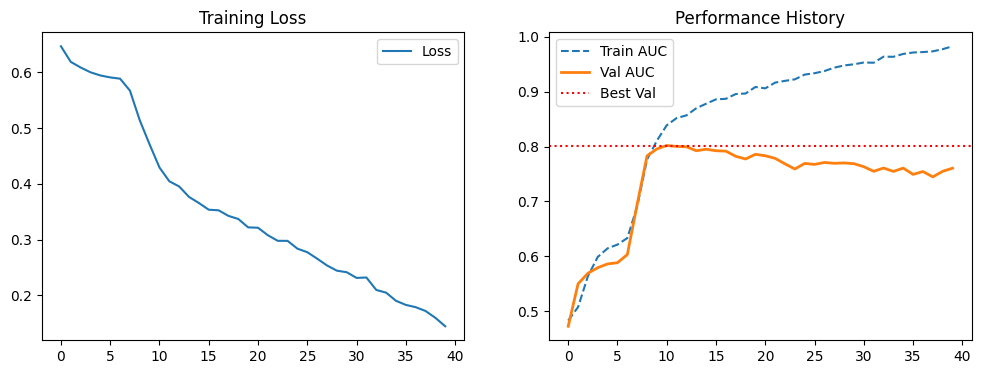

Saved weights of best model.


In [4]:
input_size = X_train.shape[-1]

# 1. Initialize Model
# Using a smaller hidden_size (32 instead of 64) helps prevent the 'memorization' 
model_gru = GRUModel(input_size=input_size, hidden_size=32, output_size=1, dropout_rate=0.5)

# 2. Train
history = utils.run_training_pipeline(
    model_gru, 
    X_train, y_train, 
    X_test, y_test, 
    save_path="best_model_gru.pth")

# 3. Visualize
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_auc'], label='Train AUC', linestyle='--')
plt.plot(history['val_auc'], label='Val AUC', linewidth=2)
plt.axhline(y=max(history['val_auc']), color='r', linestyle=':', label='Best Val')
plt.title('Performance History')
plt.legend()
plt.show()

# 4. Load Best Weights for XAI
model_gru.load_state_dict(torch.load('best_model_gru.pth'))
model_gru.eval()
print("Saved weights of best model.")

### LSTM Model

Epoch 05 | Loss: 0.5512 | Val AUC: 0.7656
Epoch 10 | Loss: 0.4135 | Val AUC: 0.7881
Epoch 15 | Loss: 0.3651 | Val AUC: 0.7850
Epoch 20 | Loss: 0.3273 | Val AUC: 0.7501
Epoch 25 | Loss: 0.3159 | Val AUC: 0.7834
Epoch 30 | Loss: 0.2740 | Val AUC: 0.7655
Epoch 35 | Loss: 0.2342 | Val AUC: 0.7678
Epoch 40 | Loss: 0.1864 | Val AUC: 0.7741


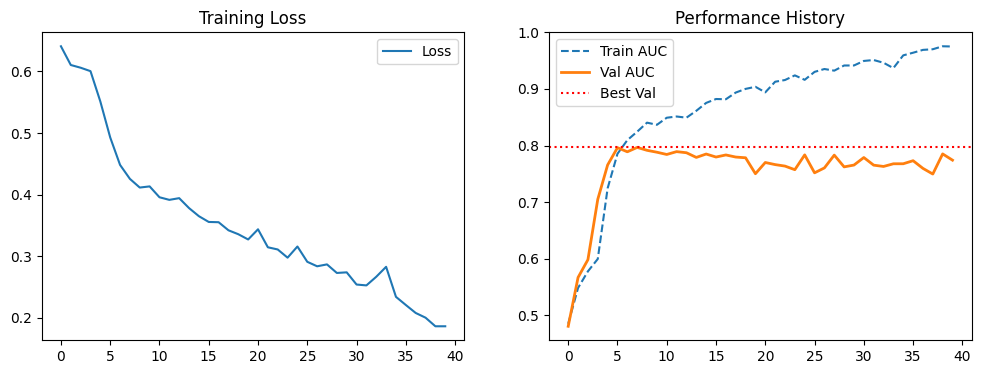

Saved weights of best model.


In [5]:
input_size = X_train.shape[-1]

# 1. Initialize Model
# Using a smaller hidden_size (32 instead of 64) helps prevent the 'memorization' 
model_lstm = LSTMModel(input_size=input_size, hidden_size=32, output_size=1, dropout_rate=0.5)

# 2. Train
history = utils.run_training_pipeline(model_lstm, X_train, y_train, X_test, y_test, save_path="best_model_lstm.pth")

# 3. Visualize
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_auc'], label='Train AUC', linestyle='--')
plt.plot(history['val_auc'], label='Val AUC', linewidth=2)
plt.axhline(y=max(history['val_auc']), color='r', linestyle=':', label='Best Val')
plt.title('Performance History')
plt.legend()
plt.show()

# 4. Load Best Weights for XAI
model_lstm.load_state_dict(torch.load('best_model_lstm.pth'))
model_lstm.eval()
print("Saved weights of best model.")

In [6]:
# --- 1. Traditional Models (Using your flattened data) ---
# Assuming lr_model and rf_model are already fitted from your code above
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

lr_results = {
    'Train': roc_auc_score(y_train, lr_model.predict_proba(X_train_flat)[:, 1]),
    'Test': roc_auc_score(y_test, lr_model.predict_proba(X_test_flat)[:, 1])
}

rf_results = {
    'Train': roc_auc_score(y_train, rf_model.predict_proba(X_train_flat)[:, 1]),
    'Test': roc_auc_score(y_test, rf_model.predict_proba(X_test_flat)[:, 1])
}

# --- 2. Deep Learning Models (Using your best saved weights) ---
def evaluate_rnn(model_obj, weights_path, X, y):
    # Load the best weights saved during your pipeline run
    model_obj.load_state_dict(torch.load(weights_path))
    model_obj.eval()
    with torch.no_grad():
        preds = model_obj(torch.Tensor(X)).numpy()
    return roc_auc_score(y, preds)

# Note: If you saved both as 'best_model.pth' sequentially, 
# make sure you use the correct object current state.
gru_results = {
    'Train': evaluate_rnn(model_gru, 'best_model_gru.pth', X_train, y_train),
    'Test': evaluate_rnn(model_gru, 'best_model_gru.pth', X_test, y_test)
}

lstm_results = {
    'Train': evaluate_rnn(model_lstm, 'best_model_lstm.pth', X_train, y_train),
    'Test': evaluate_rnn(model_lstm, 'best_model_lstm.pth', X_test, y_test)
}

# --- 3. Construct Final Table ---
summary_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'GRU', 'LSTM'],
    'Train AUC': [lr_results['Train'], rf_results['Train'], gru_results['Train'], lstm_results['Train']],
    'Test AUC': [lr_results['Test'], rf_results['Test'], gru_results['Test'], lstm_results['Test']]
})

# Calculate Generalization Gap (Overfitting measure)
summary_df['Gap'] = summary_df['Train AUC'] - summary_df['Test AUC']

print("====================================================")
print("           FINAL BENCHMARK PERFORMANCE              ")
print("====================================================")
print(summary_df.sort_values(by='Test AUC', ascending=False).to_string(index=False))
print("====================================================")

           FINAL BENCHMARK PERFORMANCE              
              Model  Train AUC  Test AUC      Gap
                GRU   0.872206  0.801922 0.070284
               LSTM   0.858092  0.796651 0.061442
      Random Forest   0.963601  0.775580 0.188021
Logistic Regression   1.000000  0.710908 0.289092


# Summary of used Models and their Parameters

* Logistic Regression (LR)
    - Parameters: penalty='l1', C=1.0
    - Why it makes sense:
        The L1 (Lasso) penalty is ideal for the 2,840 flattened features (20x142) because it forces irrelevant features to have zero weights.
        - Simplifies the model as this conducts automatic feature selection among the noise
        - Performance: The LR hit 1.0 Train AUC but a low 0.71 Test AUC. It was mostly memorizing the high-dimensional noise than learning general patterns.
* Random Forest (RF)
    - Parameters: n_estimators=200, max_depth=10
    - Why it makes sense: 
        - Limiting the max_depth to 10 prevents the trees from becoming overly complex and "memorizing" specific patients.
        - 200 trees provide enough "votes" to stabilize the feature importance scroes used in the benchmark.
* Deep Learning Models (Sequential)
     These models process the 20 visits chronologically, which is essential for the TRIGGER and ESCALATION phenotypes
     * Hidden size: 32
     * Dropout: 0.5 (50%)
     * Optimization: Adam with weight_decay=1e-4
     * Why it makes sense:
       - Hidden size of 32: Choosing a smaller "bottleneck" (32 neurons) forces the model to compress the patient's history into only the most significant signals, preventing overfitting
       - High dropout of 50%: By "turning off" half the neurons during training, the model is forced to find redundant, robust pathways to identify the CHRONIC or TRIGGER phenotypes rather than relying on a single feature
       - Weight decay: This acts as L2 regularization, keeping the weights small and the model's decision boundaries smooth, which is critical for getting stable heatmaps from IG. 

# XAI Methods

## Gradient-based Methods

#### 1. Integrated Gradients (IG)

Integrated Gradients (IG) explain **how much each input feature contributed to a model’s prediction** for a specific example.

* Attribution-based XAI method  
* Local; can be applied to any differentiable DNN model  
* A reference baseline must be defined  
* IG generates feature attributions relative to this baseline  

---

##### Rough Idea

We move from a **baseline patient** (e.g., no events) slowly towards the real patient.

* Baseline: $x'$
* Real input: $x$
* We move along the straight-line path:

$$
z(\alpha) = x' + \alpha (x-x')
$$

* $\alpha$ runs from 0 to 1
* For every intermediate point, we calculate the slope at that point:

$$
\frac{\partial F(z(\alpha))}{\partial x_i}
$$

* Then we average those slopes over the whole path:

$$
\int_{0}^{1} 
\frac{\partial F(z(\alpha))}{\partial x_i} d\alpha
$$

→ This represents the **average sensitivity along the way**.

* Finally, we multiply with $(x_i - x_i')$  
  because we want to know how large the *actual change* was, not just how strongly the model reacts per unit of change.

---

##### Geometric Intuition

* x-axis: feature value  
* y-axis: model output  
* The gradient is the slope  
* IG is the **area under the slope curve** from the baseline point to the real point  

---

##### Formal Definition

For a model $F(x)$, input $x$, and baseline $x'$:

$$
IG_i(x) =
(x_i - x_i')
\cdot
\int_{0}^{1} 
\frac{\partial F(x' + \alpha (x - x'))}{\partial x_i}
d\alpha
$$

---

##### Baseline

* Example: A patient with no recorded events  
* Question: How does the prediction change when moving from a "no-information patient" to this real patient? 
    * *baseline = torch.zeros_like(input_tensor)*

##### Interpolate between baseline and real input

* IG creates intermediate inputs: 
$$
x^{(\alpha)} = x' + \alpha (x-x')
$$
* $\alpha = 0$ -> baseline
* $\alpha = 1$ -> real patient
* Values in between -> partial versions of the patient

##### Compute gradients along the path

* At each interpolation step, IG computes:
$$
\frac{\partial F(x)}{\partial x_i}
$$
* Measures: "If we slightly increase this feature, how much does the prediction change?"

##### Integrate (average) these gradients

* Instead of using the gradient at just on point (which can be unstable), IG:
    * computes gradients at many steps (e.g., *n_steps=64*)
    * averages them along the path
* Makes explanations smoother and more reliable

##### Scale by feature difference

* Finally, IG multiplies by:
$$
(x_i - x'_i)
$$
* For binary features:
    * If feature = 1 -> it contributes
    * If feature = 0 -> attribution = 0
* So IG tells you: "How much turning this feature from 0 -> 1 contributed to the prediction."

---

##### Why use logits and not probabilities?

* Sigmoid squases gradients
* Logits are linear before activation
* IG is more stable and faifthful on logits

##### What IG actually computes here for GRU and LSTM

* For every element $x_{t,f}$ IG computes $\frac{\partial logit}{\partial x_{t,f}}$
* That means: every visit and every feature gets its own attribution
* For each interpolation step (for every $\alpha$)
    * A partial patient is fed into the GRU/LSTM
    * The GRU/LSTM computes all hidden states
    * The final hidden state $h_t$ is computed
    * The logit is computed
    * Backprop computes: $\frac{\partial logit}{\partial x_{t,f}}$ 
* IG averages then those gradients

---

##### 1.1 Global Attribution

Calculating Global Attribution for GRU (95 patients)...
Calculating Global Attribution for LSTM (101 patients)...


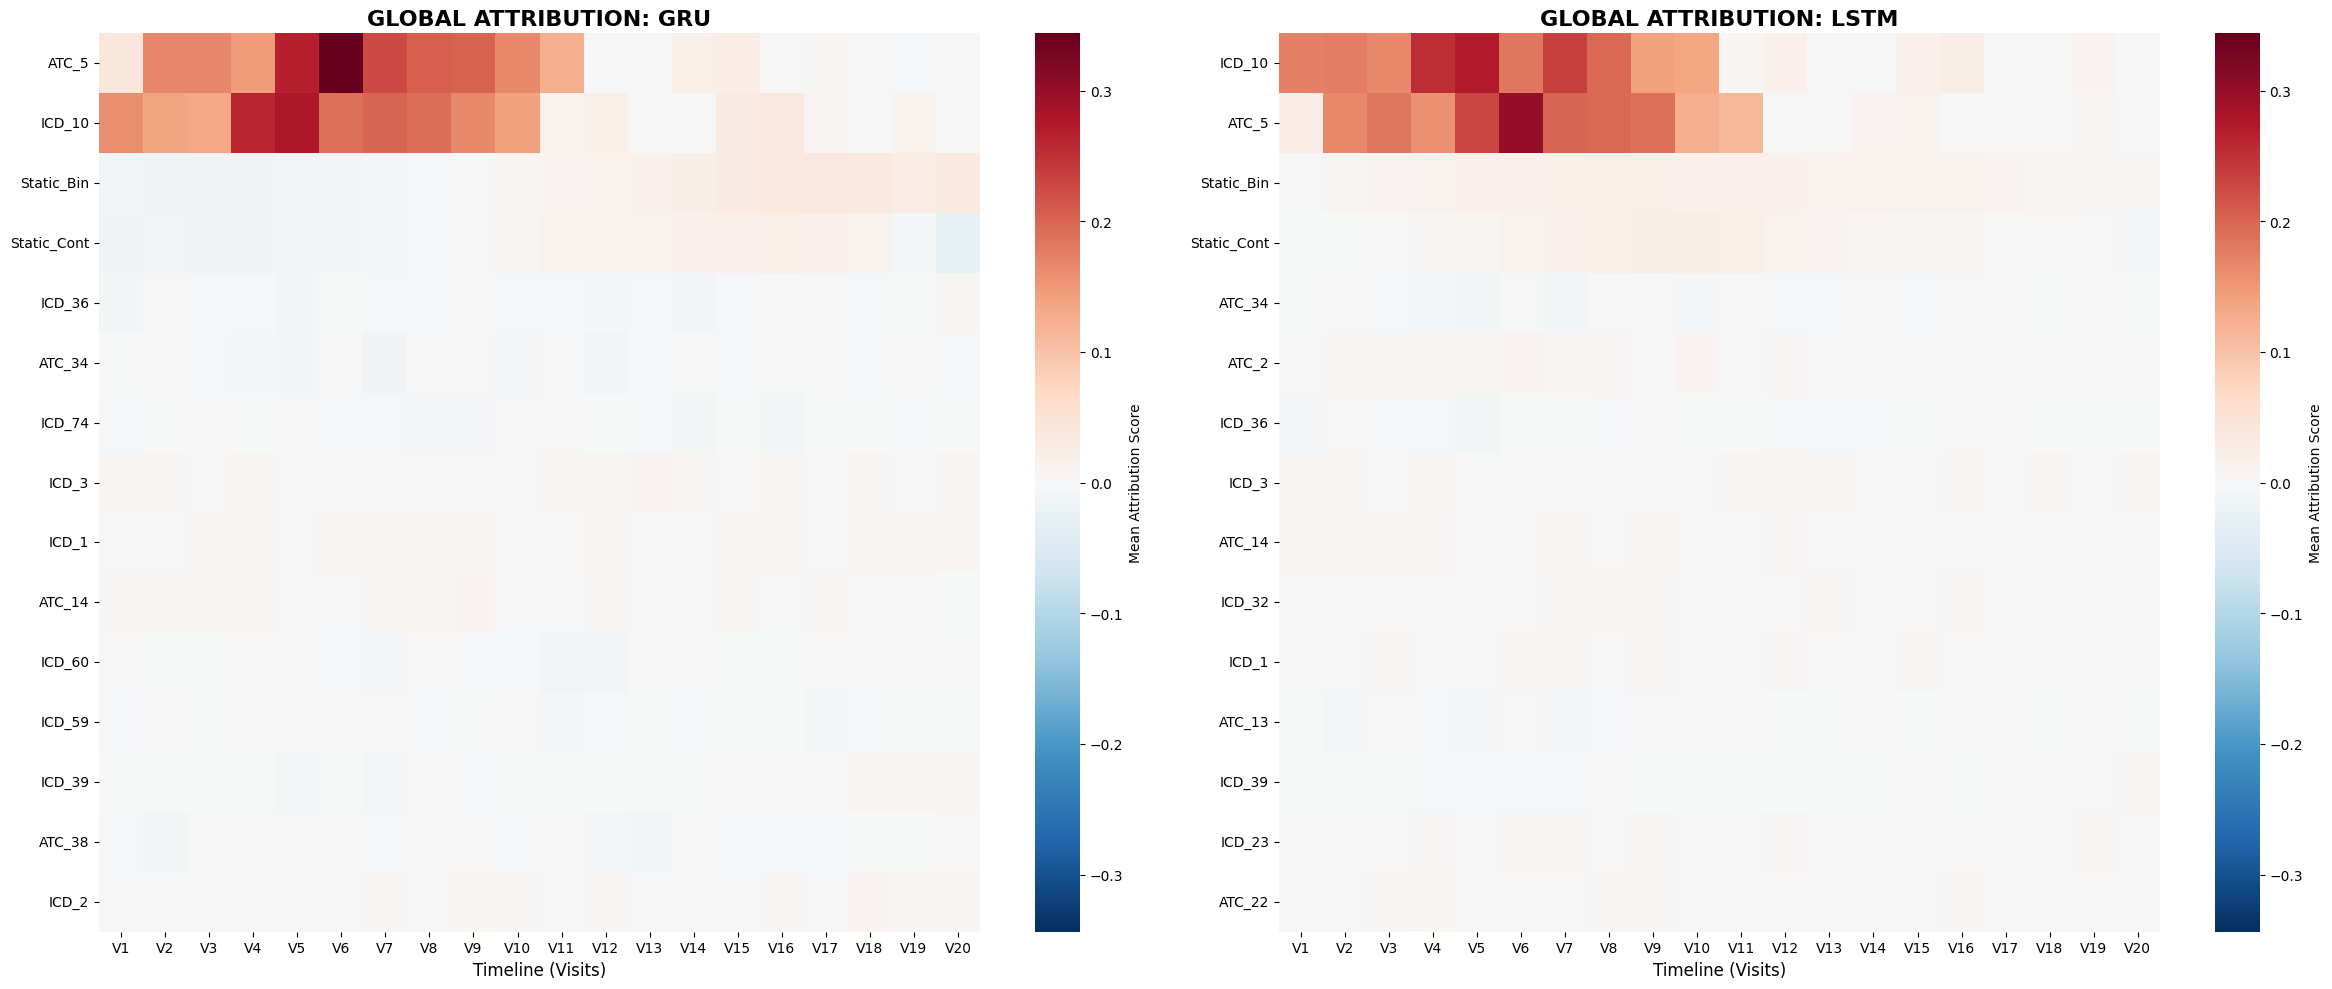

In [7]:
# ------------------------------------------------------------------------------
# 1. SETUP
# ------------------------------------------------------------------------------

# Ensure your test data is in Tensor format for the models
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_numpy = np.array(y_test)

# Dictionary containing your trained models for iteration
model_dict = {
    "GRU": model_gru,
    "LSTM": model_lstm
}

# Ensure both models are in evaluation mode
for m in model_dict.values():
    m.eval()

# Feature names mapping
feature_names = list(tokens) + ["Static_Bin", "Static_Cont"]

# ------------------------------------------------------------------------------
# 2. GLOBAL COMPARISON SIDE-BY-SIDE
# ------------------------------------------------------------------------------
# sharey=False: it allows different feature sets to appear for each model if they have learned different priorities.
fig, axes = plt.subplots(1, 2, figsize=(24, 10), sharey=False)

plot_data = {}  # store the matrix you actually plot for each model

# -------- First pass: compute global_map and top-20 per model, store plotted slice
for name, model in model_dict.items():

    ig = IntegratedGradients(model.forward_logits)

    probs = model(X_test_tensor).detach().cpu().numpy().flatten()
    tp_indices = np.where((y_test == 1) & (probs > 0.5))[0]

    global_map = np.zeros((20, len(feature_names)))

    print(f"Calculating Global Attribution for {name} ({len(tp_indices)} patients)...")

    for idx in tp_indices:
        input_tensor = X_test_tensor[idx:idx+1].clone().detach().requires_grad_(True)
        baseline = torch.zeros_like(input_tensor)

        attr = ig.attribute(input_tensor, baselines=baseline, target=0, n_steps=64)
        global_map += attr.squeeze().cpu().detach().numpy()

    global_map /= len(tp_indices)

    # Optional: normalize per model so scale reflects pattern, not magnitude
    #global_map = global_map / (np.sum(np.abs(global_map)) + 1e-8)

    model_top_idx = np.argsort(np.abs(global_map).sum(axis=0))[-15:][::-1]


    # this is exactly what is plotted (shape [20, 20])
    plot_data[name] = (global_map[:, model_top_idx], model_top_idx)

# -------- Compute shared color scale across BOTH plotted matrices
shared_vmax = max(np.max(np.abs(mat)) for (mat, _) in plot_data.values())

# -------- Second pass: plot using shared vmin/vmax
for i, (name, (mat, top_idx)) in enumerate(plot_data.items()):

    sns.heatmap(
        mat.T,  # [20, 20] -> features x time
        cmap="RdBu_r",
        center=0,
        vmin=-shared_vmax,
        vmax=shared_vmax,
        ax=axes[i],
        xticklabels=[f"V{t+1}" for t in range(20)],
        yticklabels=[feature_names[j] for j in top_idx],
        cbar_kws={'label': 'Mean Attribution Score'}
    )

    axes[i].set_title(f"GLOBAL ATTRIBUTION: {name}", fontsize=16, fontweight='bold')
    axes[i].set_xlabel("Timeline (Visits)", fontsize=12)

plt.tight_layout()
plt.show()

What the plot shows: **Average Integrated Gradients across all true positive patients** 
* "On average, how much did this feature at this visit push the model toward predicting class 1?"
* Population-level mechanism
* Red pushes toward positive
* Blue pushes toward negative
* White means little influence

Interpretation:
* Sequential trigger is real and dominant
    * ICD 10 and ATC 5 show the strongest red signals
    * Strongest around visits 6-10, especially peak around V8-V9 
    * Across the population, the model has learned that ICD 10 followed by ATC 5 in mid-timeline strongly predicts class 1
* Temporal concentration:
    * Early visits are weak, middle visits are strong(er) and late visits are weaker again
    * Model is not just using presence of features, it is using when they occur
* Static features:
    * Have mild consistent attribution across time
    * Static risk contributes but is not the main driver
* GRU vs LSTM differences:
    * GRU: slightly stronger magnitude peak; more sharply concentrated around V8-V9
    * LSTM: slightly more diffuse; slightly weaker peak magnitude
    * -> GRU seems to encode the trigger more sharply, LSTM spreads importance more broadly across nearby visits
    * -> Aligns with known behavior (GRUs often react more sharply to short sequential motifs, LSTMs sometimes smooth signals over time due to memory gating)



##### 1.2 Special Cases

In [8]:
labels_test["group_gt"].value_counts()

escalation_only       142
none                  131
chronic_only          118
escalation+chronic    111
trigger_only           33
all_three              25
trigger+escalation     22
trigger+chronic        18
Name: group_gt, dtype: int64

In [9]:
def pick_best(test_indices, probs):
    test_indices = np.array(test_indices, dtype=int)
    if len(test_indices) == 0:
        return None
    return int(test_indices[np.argmax(probs[test_indices])])

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

with torch.no_grad():
    y_probs_ref = model_gru(X_test_tensor).cpu().numpy().flatten()

case_studies = {}

# Pure phenotypes (and mixed)
for group, title in [
    ("trigger_only", "Pure Trigger"),
    ("chronic_only", "Pure Chronic"),
    ("escalation_only", "Pure Late Escalation"),
    ("trigger+chronic", "Mixed: Trigger + Chronic"),
    ("trigger+escalation", "Mixed: Trigger + Escalation"),
    ("escalation+chronic", "Mixed: Chronic + Escalation"),
    ("all_three", "Mixed: All Three"),
]:
    cand = labels_test.loc[labels_test["group_gt"] == group, "test_idx"].dropna().astype(int).values
    # optional: only true positives
    cand = cand[y_test[cand] == 1]
    p = pick_best(cand, y_probs_ref)
    if p is not None:
        case_studies[title] = p

# False positive (GRU high but y=0)
fp = np.where((y_test == 0) & (y_probs_ref > 0.6))[0]
p = pick_best(fp, y_probs_ref)
if p is not None:
    case_studies["False Positive"] = p


# --- feature indices you want to always show ---
idx_icd10 = feature_names.index("ICD_10")
idx_atc5  = feature_names.index("ATC_5")
chronic_ids = [feature_names.index(n) for n in ["ICD_1", "ICD_2", "ICD_3"]]

gt_indices = [idx_icd10, idx_atc5] + chronic_ids

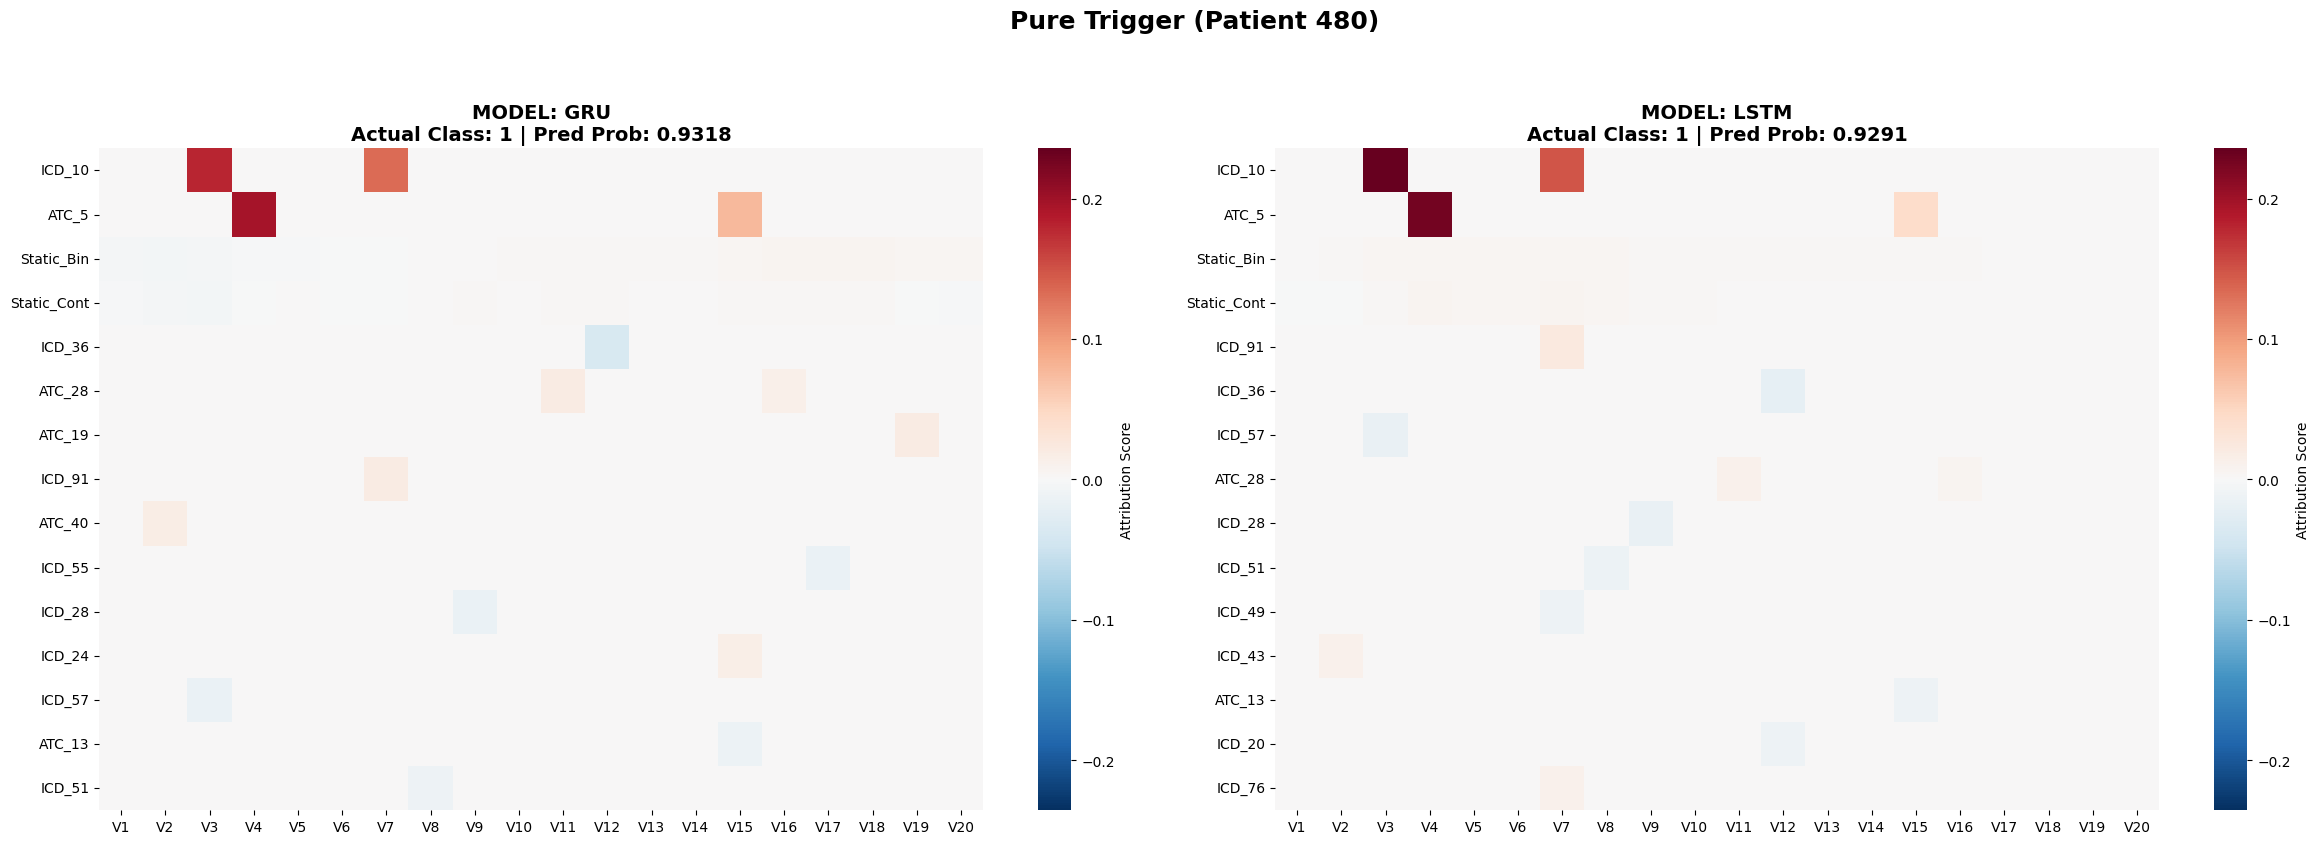

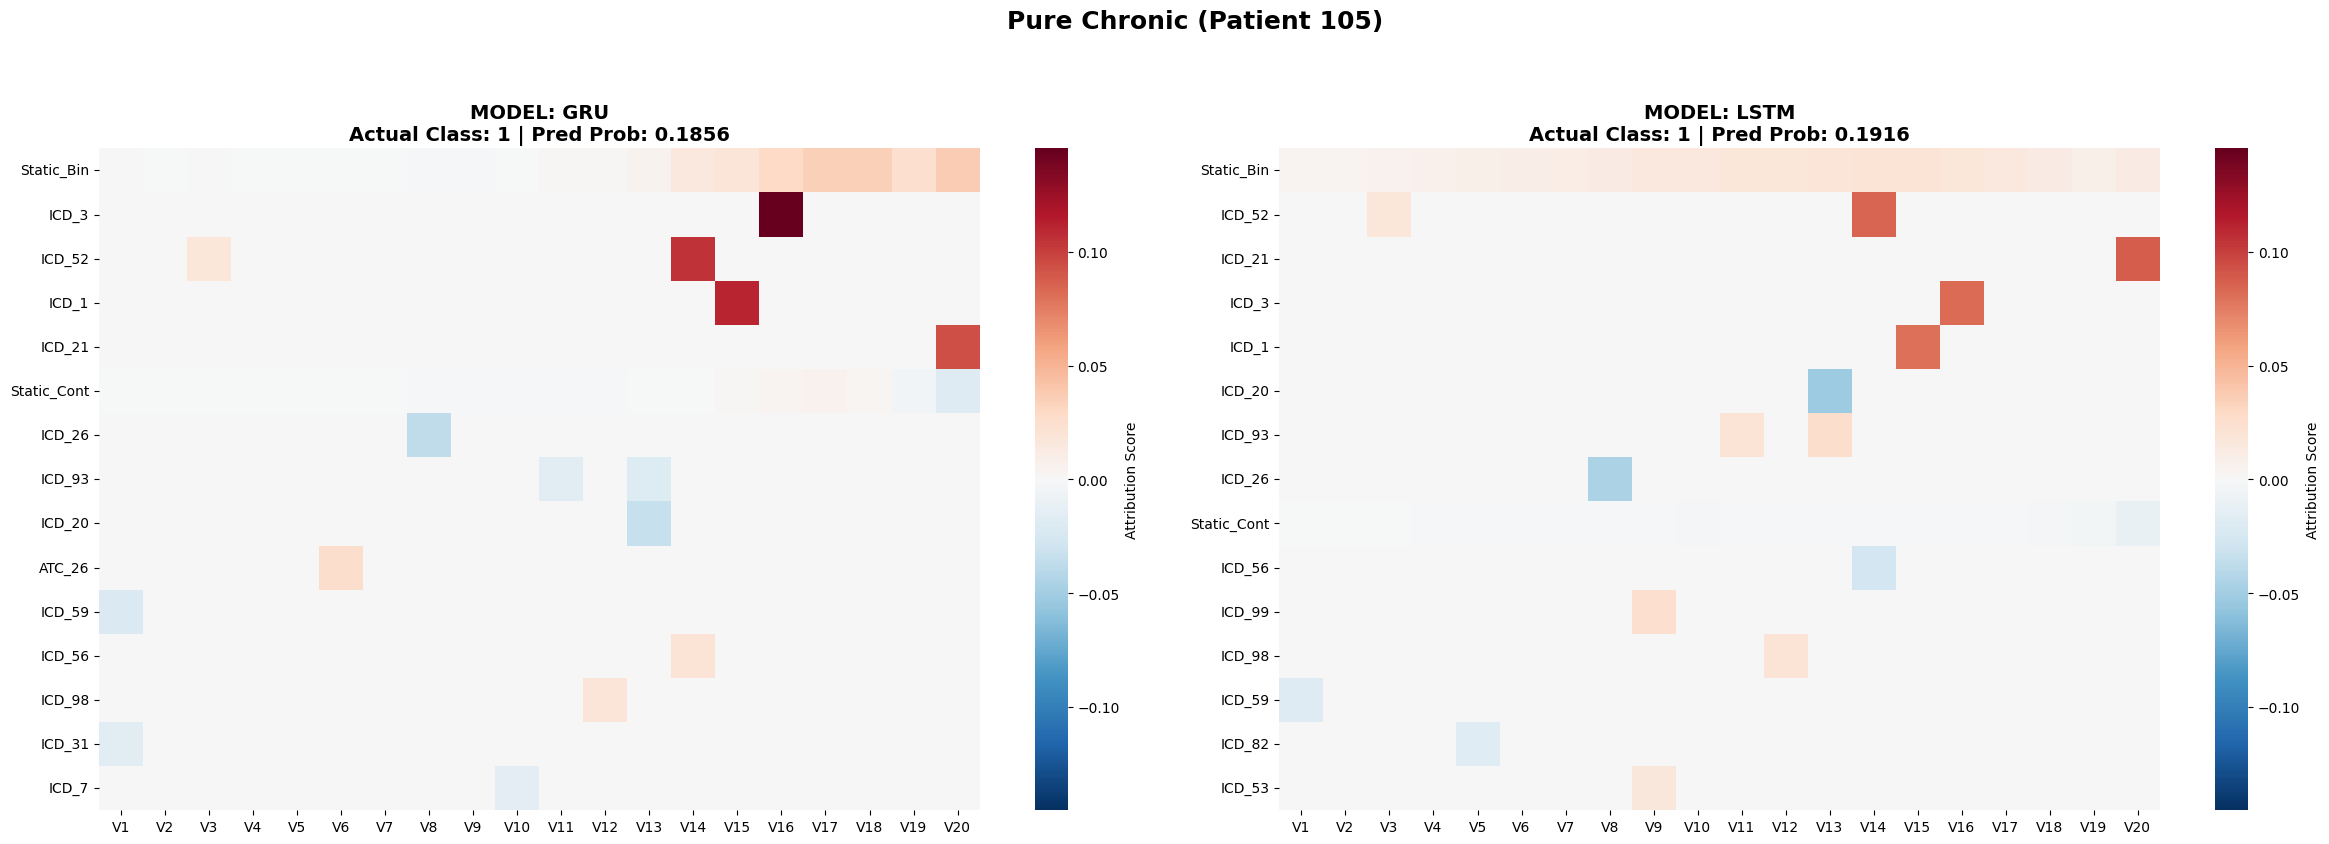

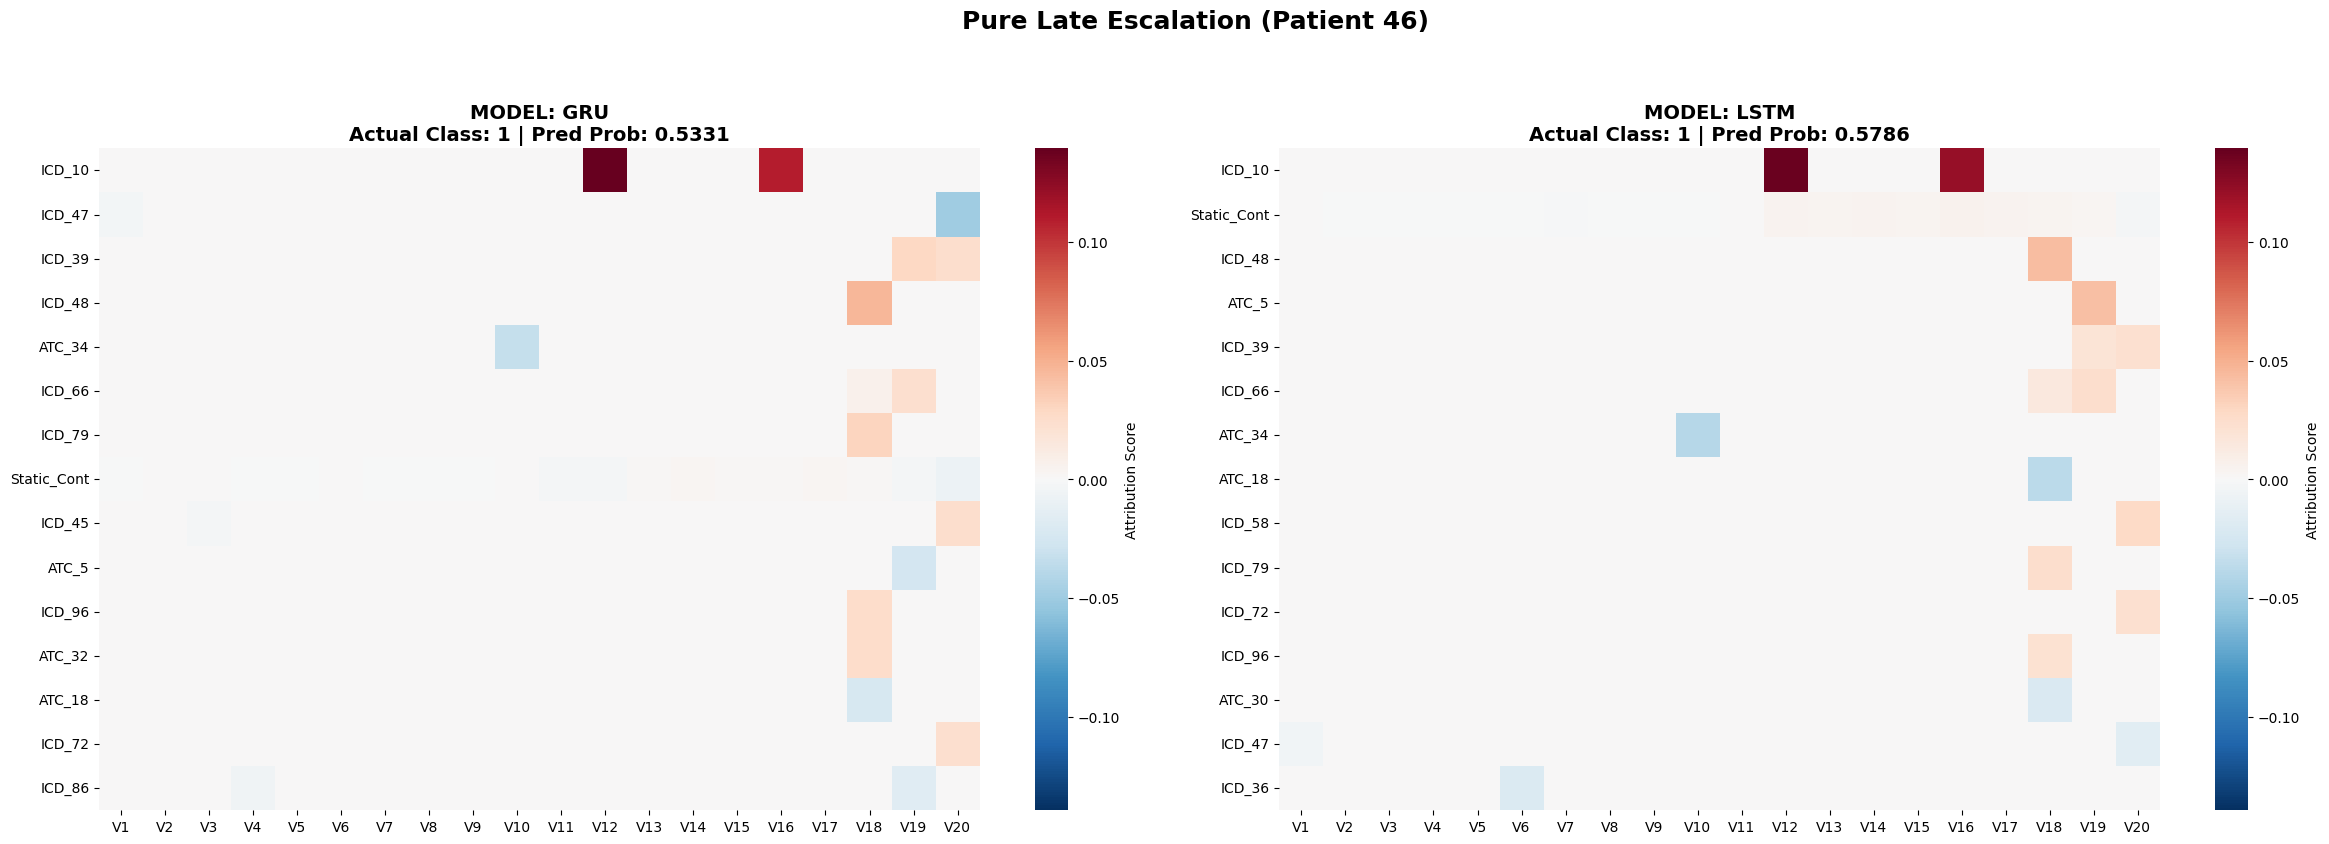

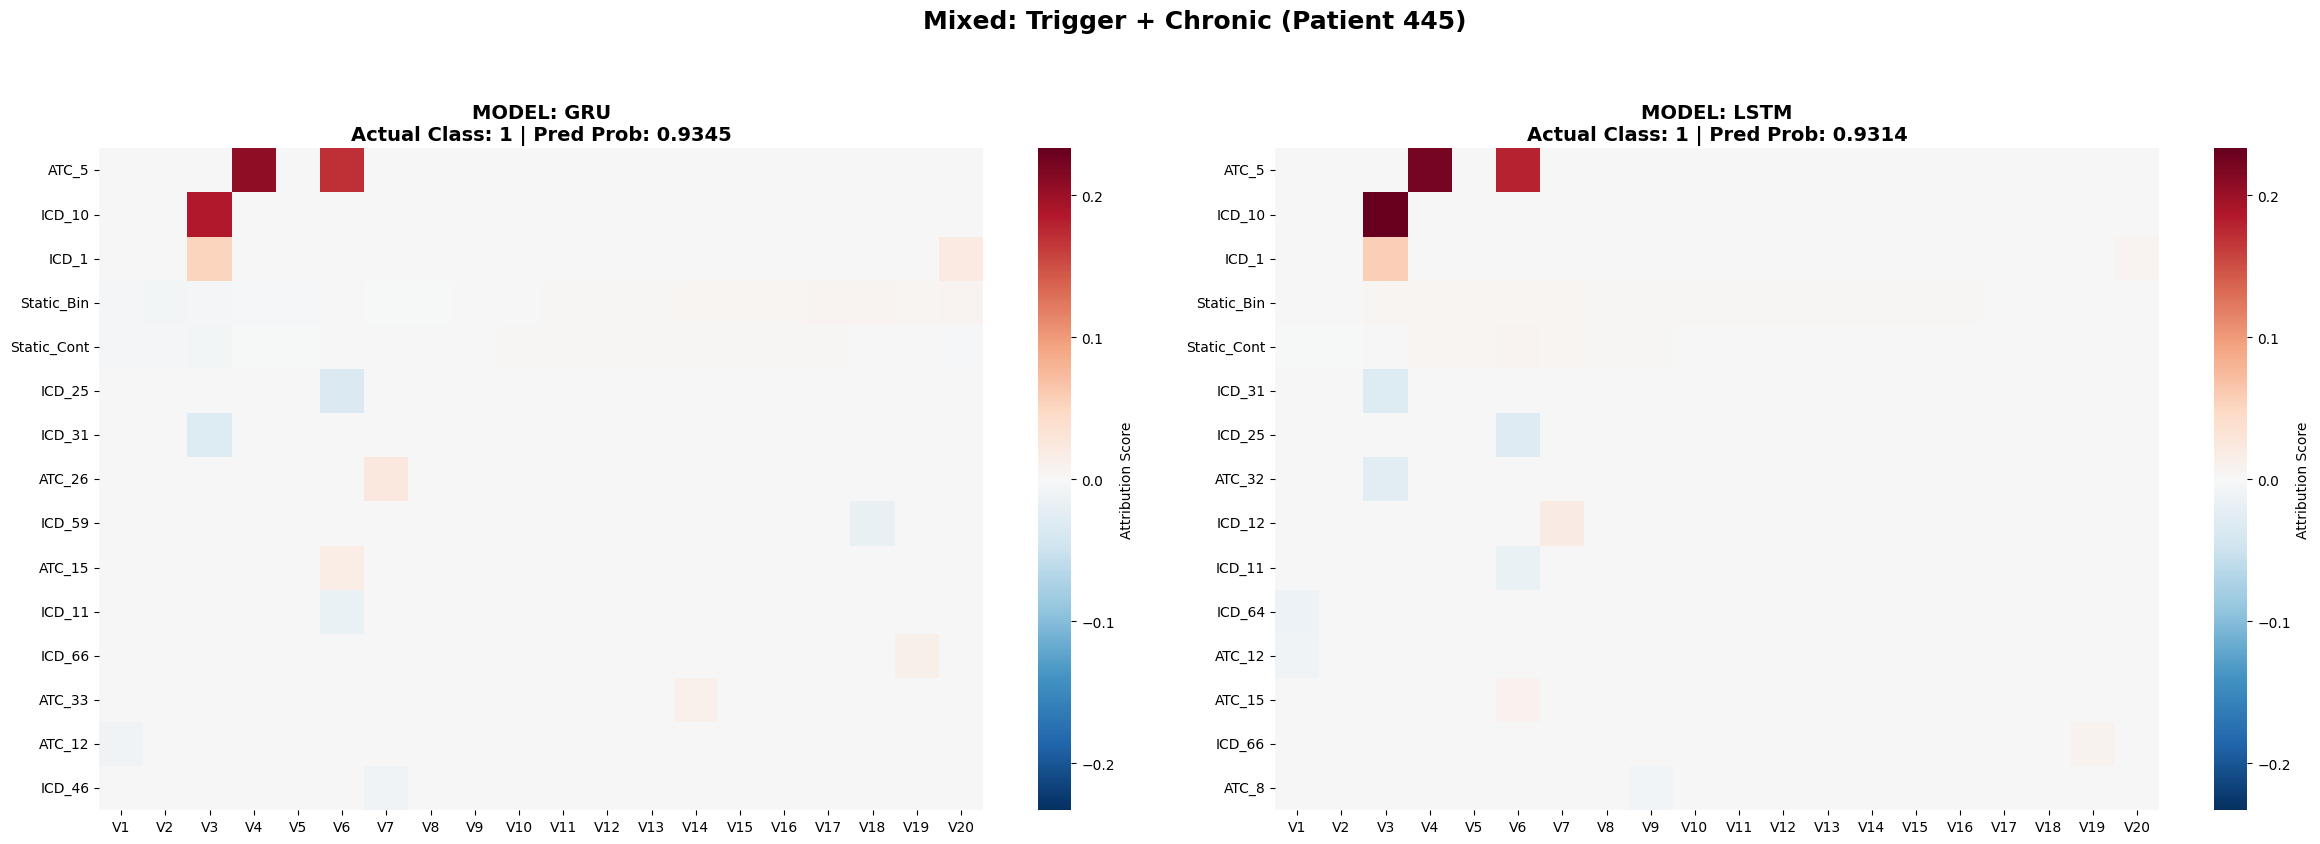

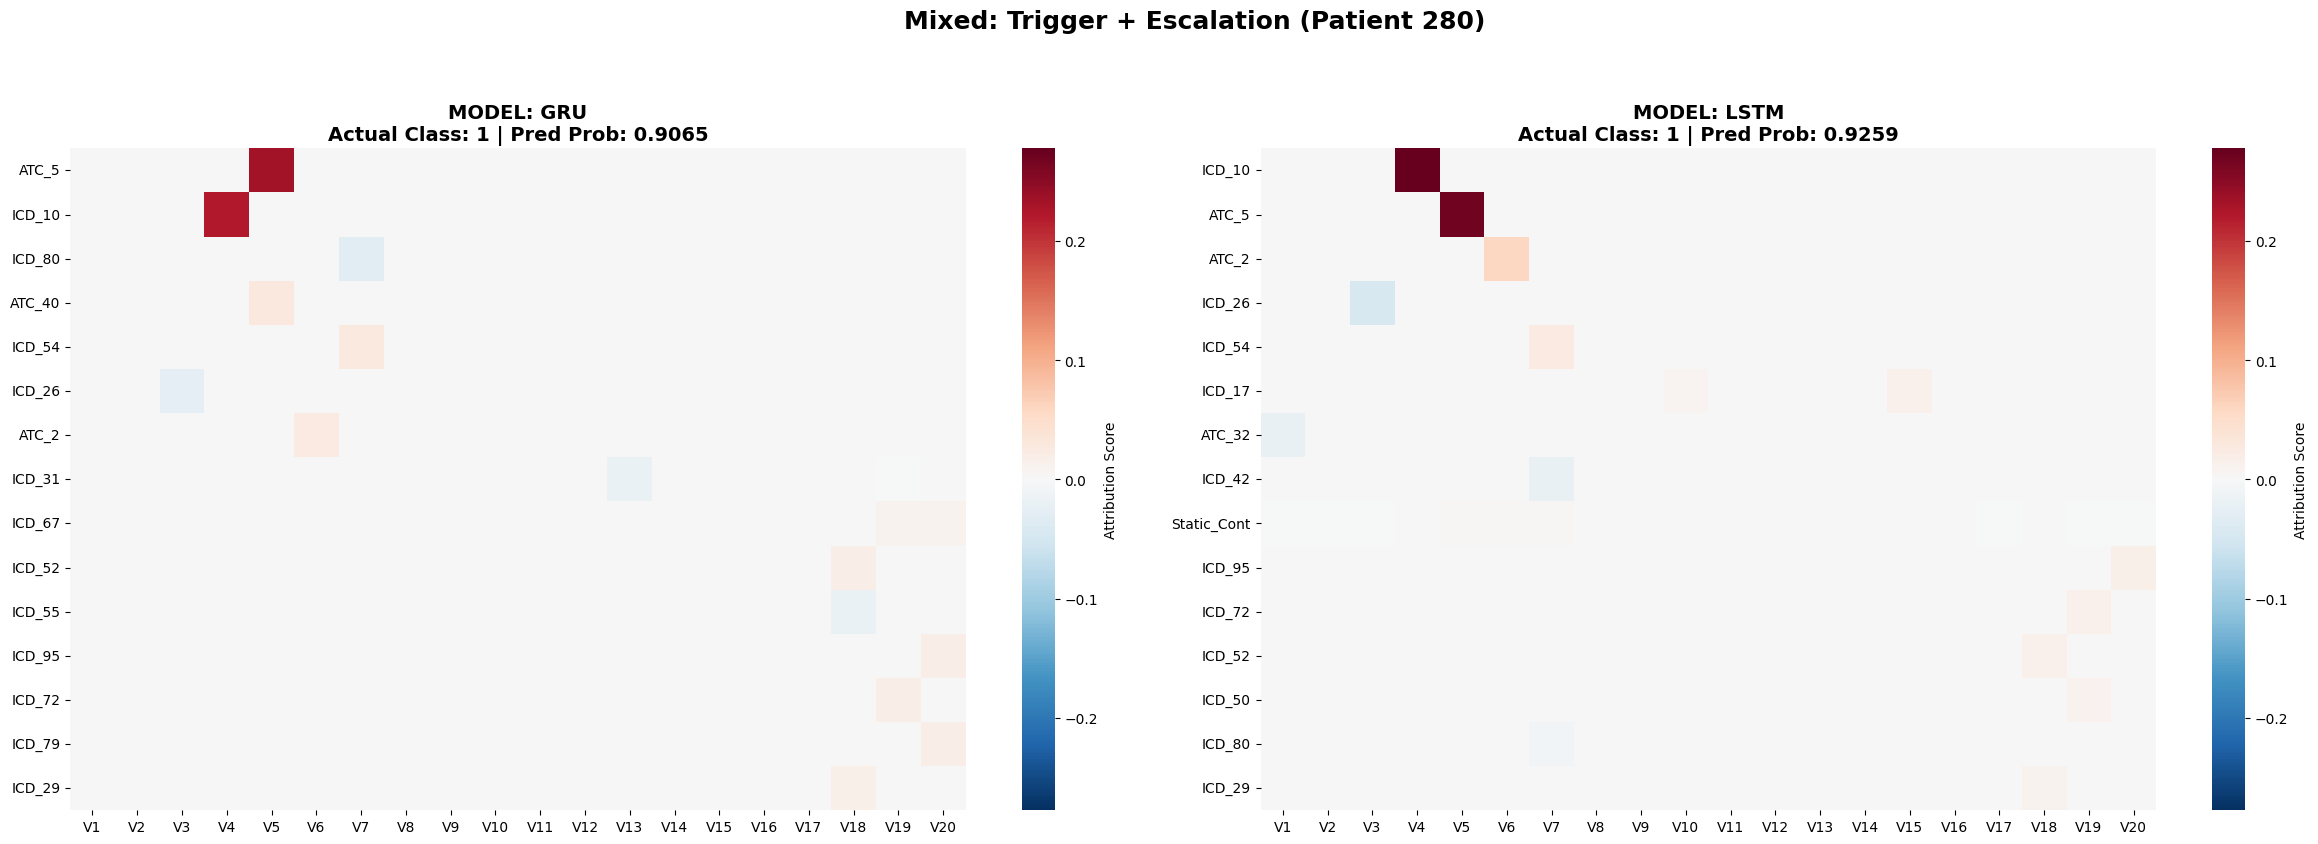

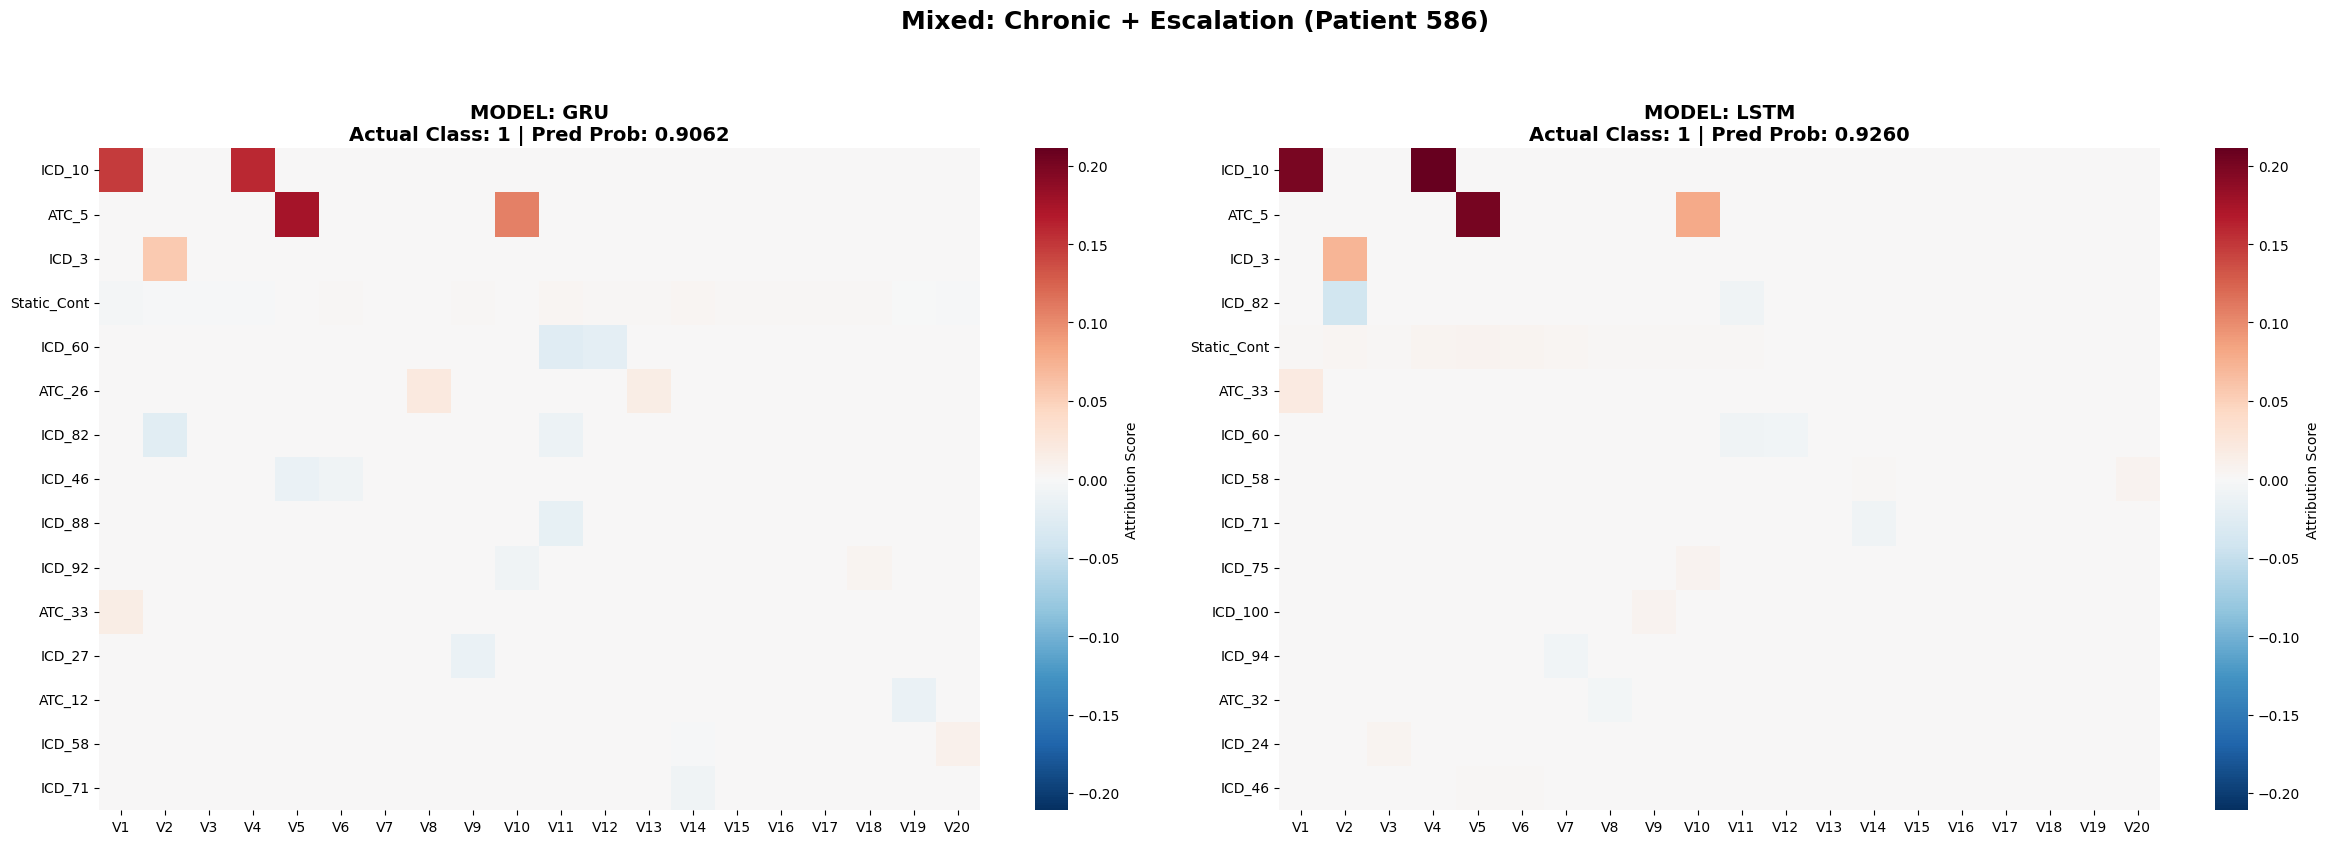

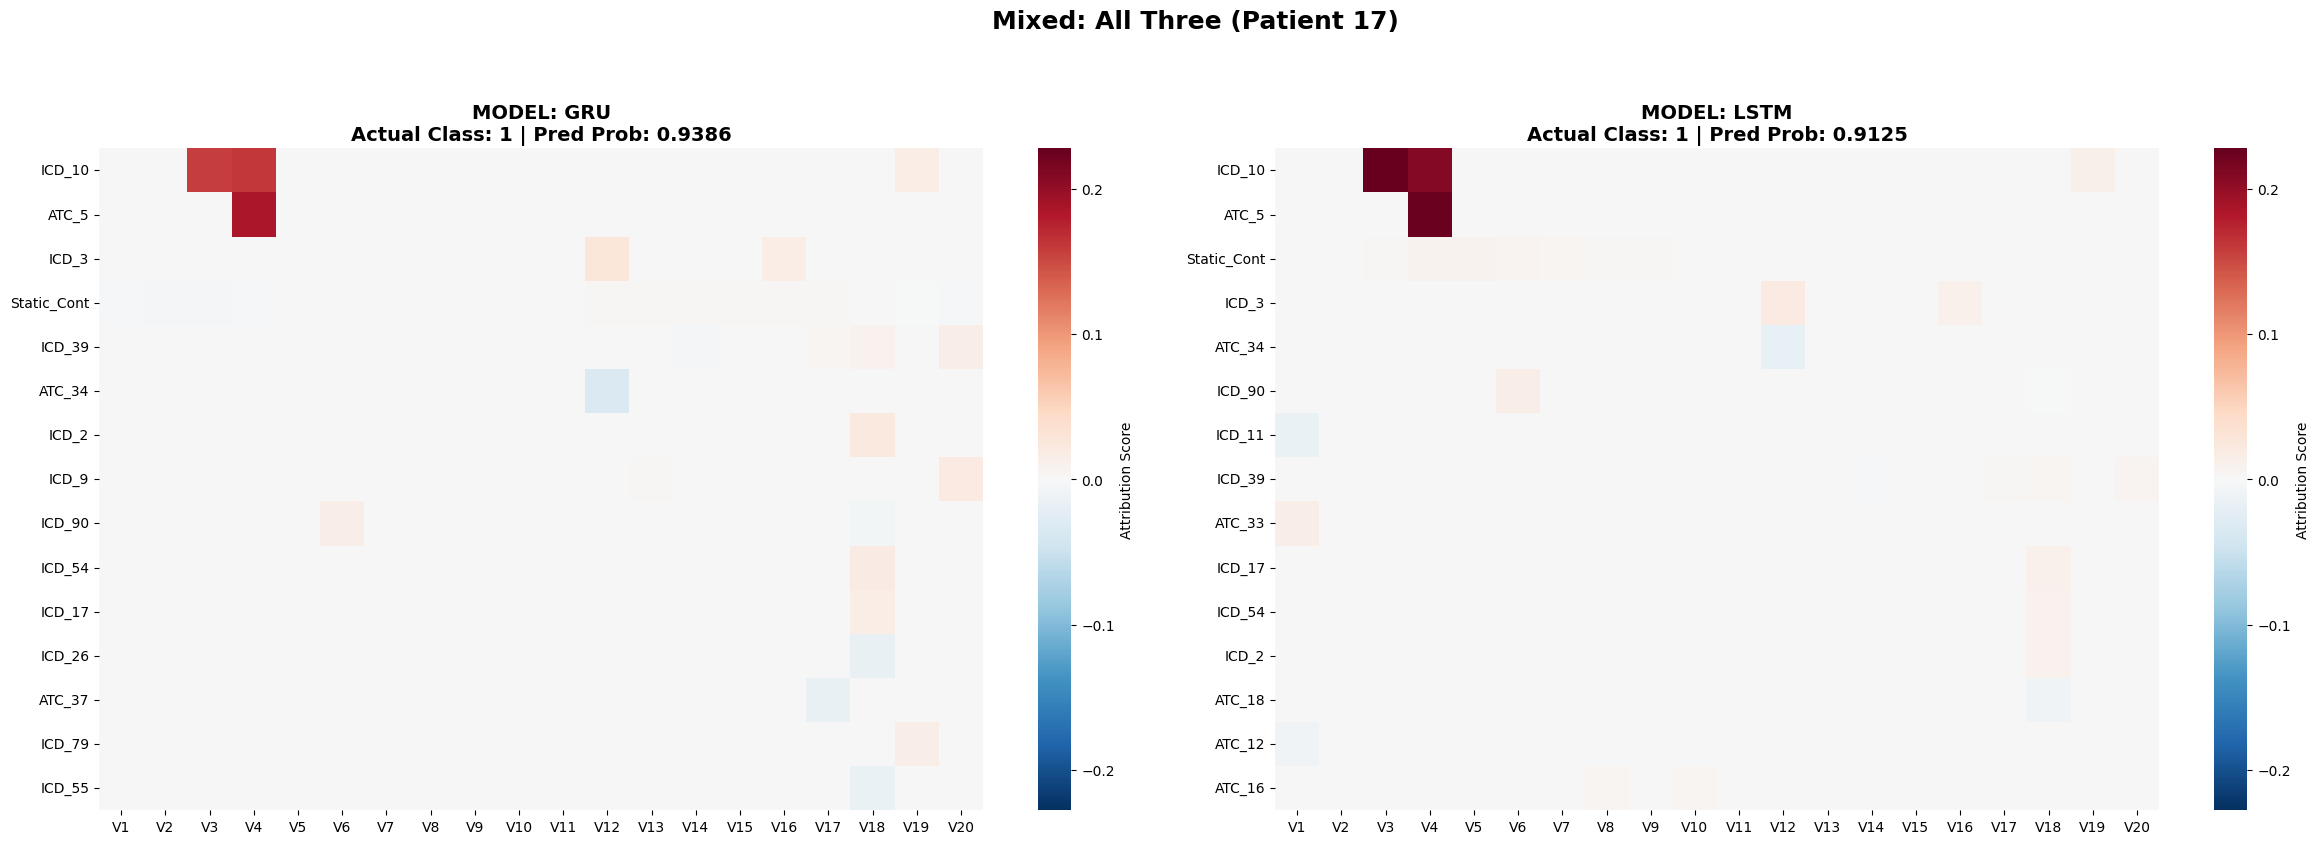

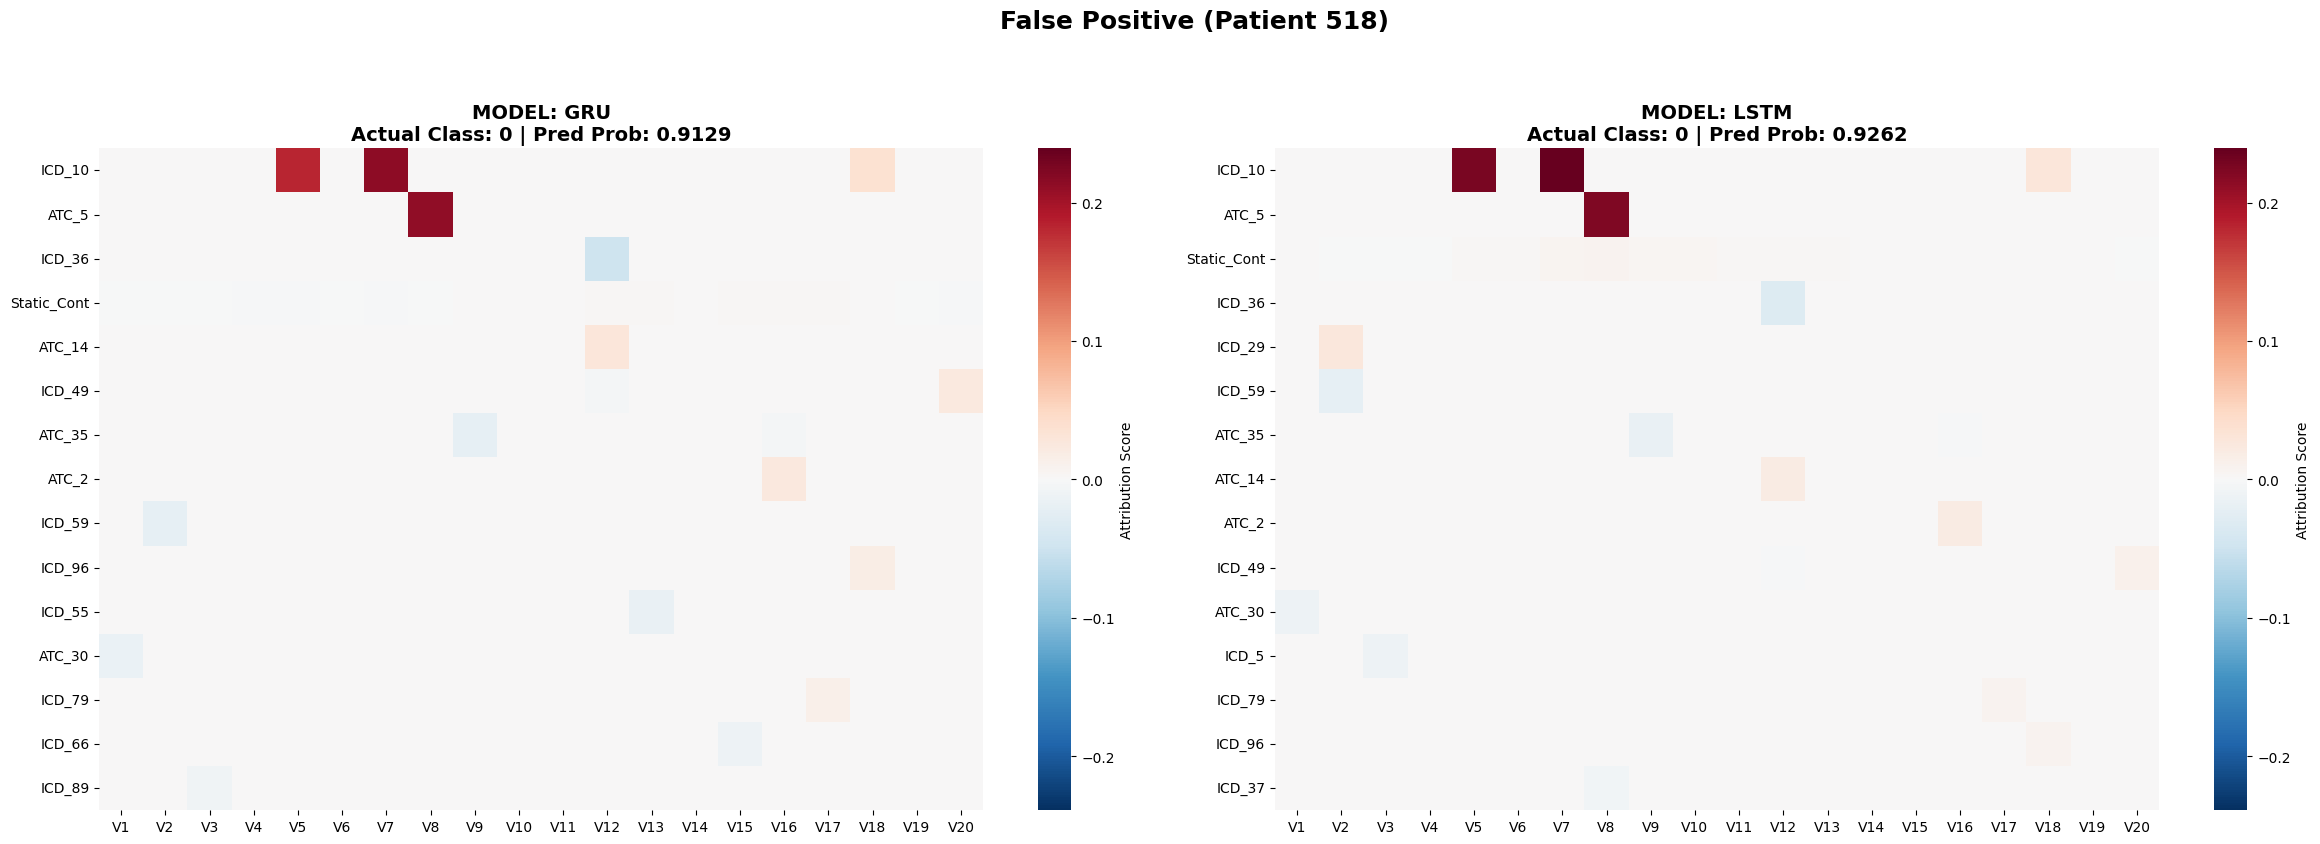

Selected case studies: {'Pure Trigger': 480, 'Pure Chronic': 105, 'Pure Late Escalation': 46, 'Mixed: Trigger + Chronic': 445, 'Mixed: Trigger + Escalation': 280, 'Mixed: Chronic + Escalation': 586, 'Mixed: All Three': 17, 'False Positive': 518}


In [10]:
# ==============================================================================
# 3) SIDE-BY-SIDE INTEGRATED GRADIENTS PLOTS (GRU vs LSTM)
# ==============================================================================

T = X_test_tensor.shape[1]
TOP_K = 15
FORCE_GT = True   # force ICD_10/ATC_5/ICD_1/2/3 always visible
MAX_FEATURES_SHOWN = 20  # after forcing GT, cap total

# Loop over each selected case study phenotype and patient index
for title, p_idx in case_studies.items():

    # Create a 1x2 subplot for GRU and LSTM
    # sharey=False allows different feature lists per model (since top-k may differ)
    fig, axes = plt.subplots(1, 2, figsize=(24, 8), sharey=False)

    # The true label for this patient (0 or 1)
    actual_label = int(y_test[p_idx])

    # --------------------------------------------------------------------------
    # We compute attributions for BOTH models first, so we can:
    # 1) normalize attributions per model
    # 2) set a shared color scale (same vmin/vmax) for fair comparison
    # --------------------------------------------------------------------------
    attr_by_model = {}  # name -> attribution matrix [T, F]
    vmax_by_model = {}  # name -> max absolute attribution value (after normalization)

    for name, model in model_dict.items():

        # Use logits for IG (more stable than attributing sigmoid probabilities).
        # This requires your models to implement forward_logits(x).
        ig = IntegratedGradients(model.forward_logits)

        # Select this patient and keep a batch dimension: [1, T, F]
        # requires_grad=True because IG needs gradients w.r.t. the input.
        input_tensor = X_test_tensor[p_idx:p_idx+1].clone().detach().requires_grad_(True)

        # Baseline for IG: "all features absent" (zero tensor).
        # This is common for binary/multi-hot medical event data.
        baseline = torch.zeros_like(input_tensor)

        # Compute IG attributions:
        # - target=0 because model.forward_logits returns shape [B,1]
        # - n_steps controls approximation quality; higher is smoother/more stable
        attr = ig.attribute(
            input_tensor,
            baselines=baseline,
            target=0,
            n_steps=64
        ).squeeze().cpu().detach().numpy()  # -> [T, F]

        # Normalize per model/per patient so:
        # - attribution patterns are comparable even if raw scales differ
        # - heatmaps emphasize "where the mass is" rather than absolute magnitude
        attr = attr / (np.sum(np.abs(attr)) + 1e-8)

        # Store attribution and its max absolute value for shared scaling
        attr_by_model[name] = attr
        vmax_by_model[name] = np.max(np.abs(attr))

    # Shared color scale across GRU and LSTM for THIS patient:
    # Ensures the same "red/blue intensity" means the same magnitude in both plots.
    shared_vmax = max(vmax_by_model.values())

    # --------------------------------------------------------------------------
    # Plot each model's heatmap using the shared scale
    # --------------------------------------------------------------------------
    for i, (name, model) in enumerate(model_dict.items()):
        attr = attr_by_model[name]  # [T, F]

        # Force some clinically meaningful features to always appear in the plot
        gt_indices = [idx_icd10, idx_atc5] + chronic_ids

        # GLOBAL SORTING LOGIC:
        # Sum absolute attribution across all 20 visits (axis 0)
        # and take the top 15 highest-scoring features for this patient
        model_top_idx = np.argsort(np.abs(attr).sum(axis=0))[-15:][::-1]

       # Extract prob for title
        prob = model(X_test_tensor[p_idx:p_idx+1]).item()

        sns.heatmap(
            attr[:, model_top_idx].T,  # Transpose to put features on Y-axis
            cmap="RdBu_r",
            center=0,
            vmin=-shared_vmax,
            vmax=shared_vmax,
            ax=axes[i],
            xticklabels=[f"V{t+1}" for t in range(20)],
            yticklabels=[feature_names[j] for j in model_top_idx],
            cbar_kws={'label': 'Attribution Score'}
        )

        axes[i].set_title(
            f"MODEL: {name}\nActual Class: {actual_label} | Pred Prob: {prob:.4f}",
            fontsize=14, fontweight='bold'
        )

    plt.suptitle(f"{title} (Patient {p_idx})", fontsize=18, fontweight='bold', y=1.05)
    plt.tight_layout()
    plt.show()

print("Selected case studies:", case_studies)

#### 2. Expected Gradients (EG)

* Basline: multiple baselines sampled from background
* Approximates Shapley values
* = multi-baseline IG
* It may be more stable than IG
* It may be more expensive
* SHAP GradientExplainer

##### 2.1 Setup

In [11]:
X_train_np = np.array(X_train)
X_test_np  = np.array(X_test)

T = X_test_np.shape[1]
F = X_test_np.shape[2]
assert len(feature_names) == F, f"len(feature_names)={len(feature_names)} but F={F}"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# -----------------------------
# 1) Wrapper: enforce SHAP-friendly output shape [B,1]
# -----------------------------
class LogitWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        out = self.model.forward_logits(x)  # should be [B,1] or [B]
        if out.dim() == 1:
            out = out.unsqueeze(1)          # -> [B,1]
        return out




##### 2.2 GRU

In [ ]:
# How many test samples to explain (SHAP can be slow; start small)
#N_EXPLAIN = min(256, len(X_test_np))
#X_explain = X_test_np[:N_EXPLAIN]
X_explain = X_test_np  # all patients

# ---- GRU ----
expl_gru, shap_gru_ntf, base_gru = utils.compute_eg_rnn(
    model_gru, X_train_np, X_explain,
    device=device,
    background_size=128, nsamples=200
)
print("GRU EG:", shap_gru_ntf.shape)  # (N_EXPLAIN, T, F)

p = 2

base_val_gru = utils._scalar_base_value(base_gru) 
print("base_val_gru:", base_val_gru)                 

GRU shap: (600, 20, 142)
base_val_gru: 0.0


##### 2.2.1 Global feature importance

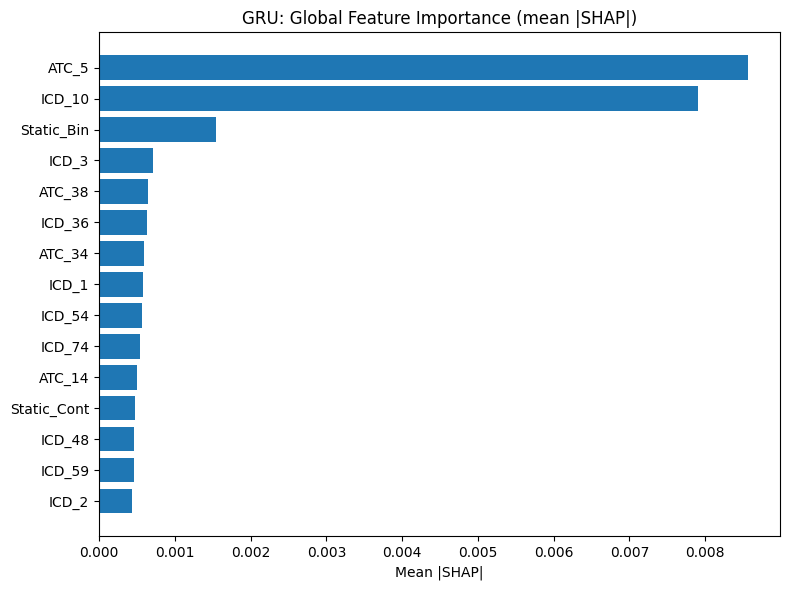

feature  mean_abs_shap
35         ATC_5       0.008558
41        ICD_10       0.007908
140   Static_Bin       0.001536
63         ICD_3       0.000709
31        ATC_38       0.000651
70        ICD_36       0.000631
27        ATC_34       0.000598
40         ICD_1       0.000584
90        ICD_54       0.000570
112       ICD_74       0.000546
5         ATC_14       0.000505
141  Static_Cont       0.000475
83        ICD_48       0.000463
95        ICD_59       0.000461
52         ICD_2       0.000438

In [ ]:
# Global feature importance
imp_gru = utils.global_importance_per_feature(shap_gru_ntf)

# Global feature importance as table and with concrete values
df_top_gru = utils.plot_global_bar(imp_gru, feature_names, "GRU: Global Feature Importance (mean |EG|)", top_k=15)
display(df_top_gru)

##### 2.2.2 Temporal plot

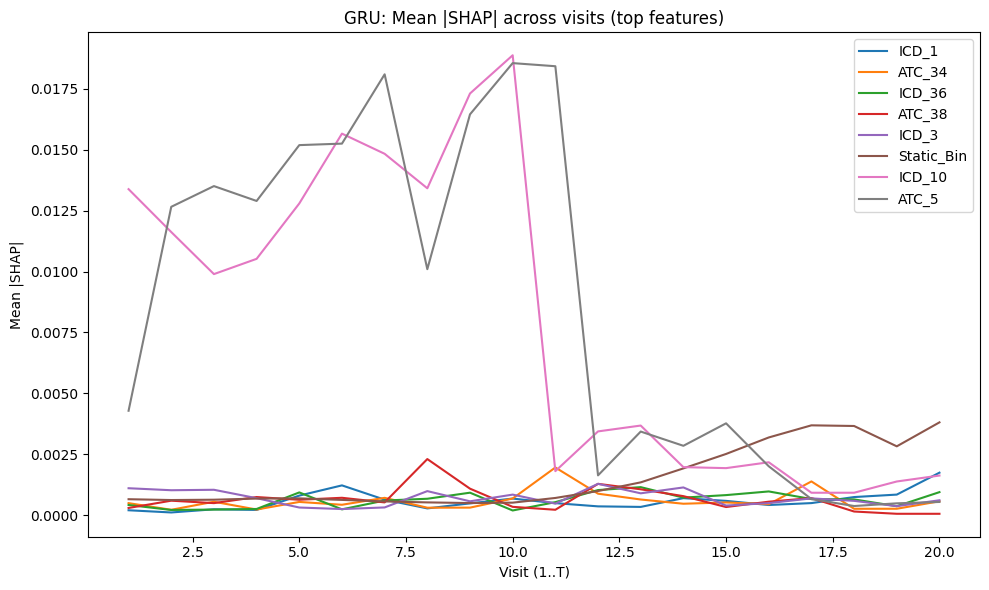

In [ ]:
# Temporal plots
utils.plot_shap_over_time(shap_gru_ntf, feature_names, top_k=8, title="GRU: Mean |EG| across visits (top features)")
#plot_shap_heatmap_top_features(shap_gru_ntf, feature_names, top_k=15, title="GRU: Temporal EG heatmap (top 15)")

##### 2.2.3 Beeswarm plot over all visits (global view)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


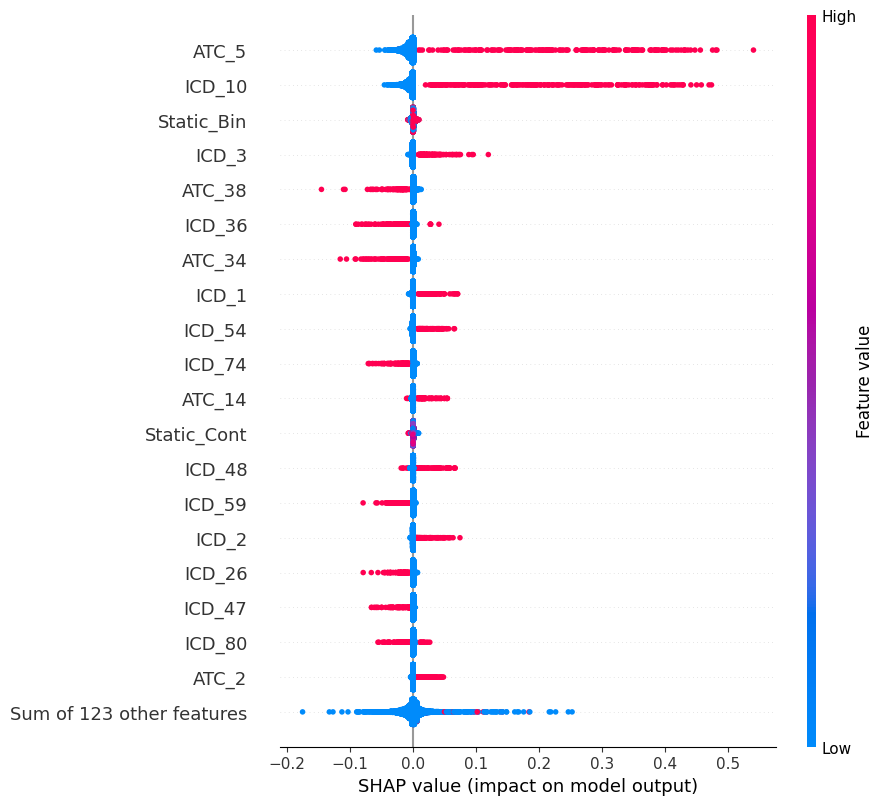

In [15]:
utils.shap_beeswarm_all_visits(
    shap_gru_ntf,
    X_explain,
    feature_names,
    max_display=20
)

##### 2.2.4 Local plots

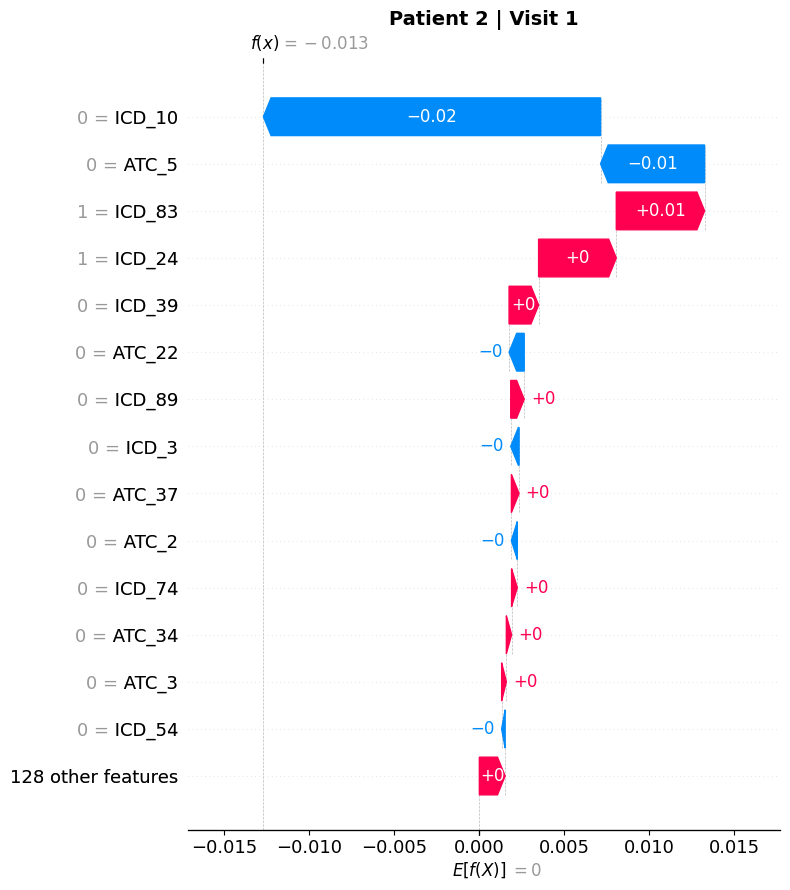

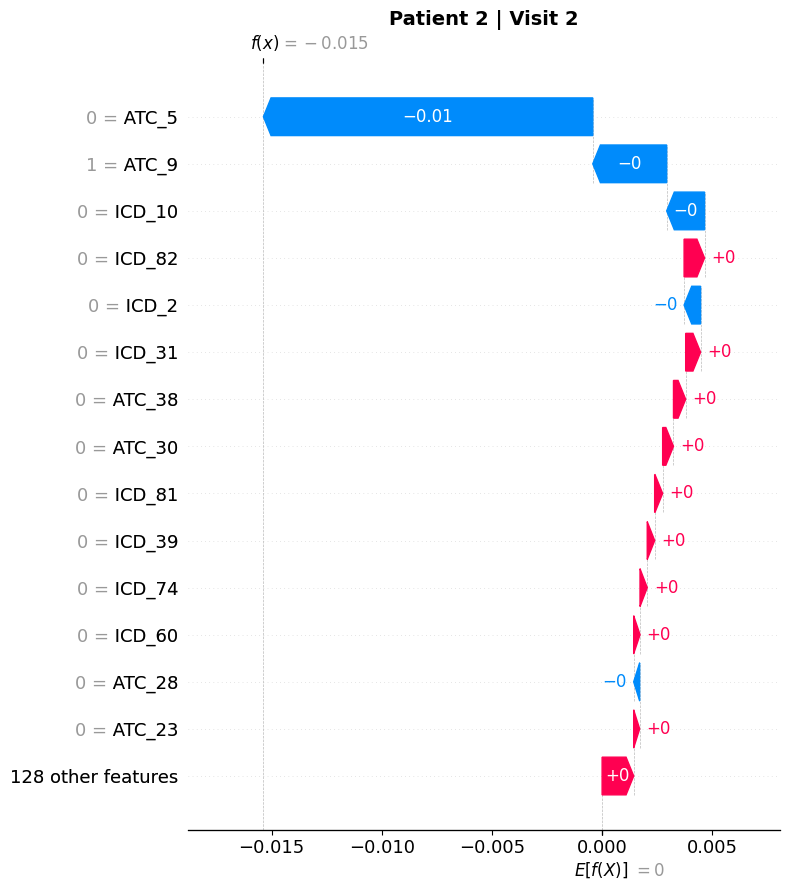

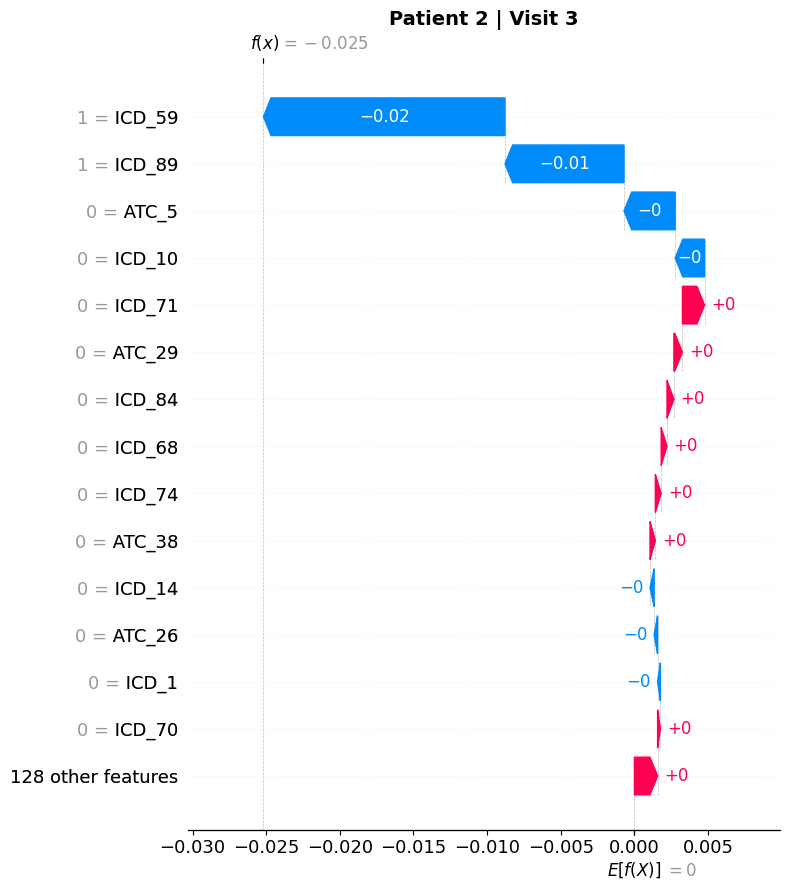

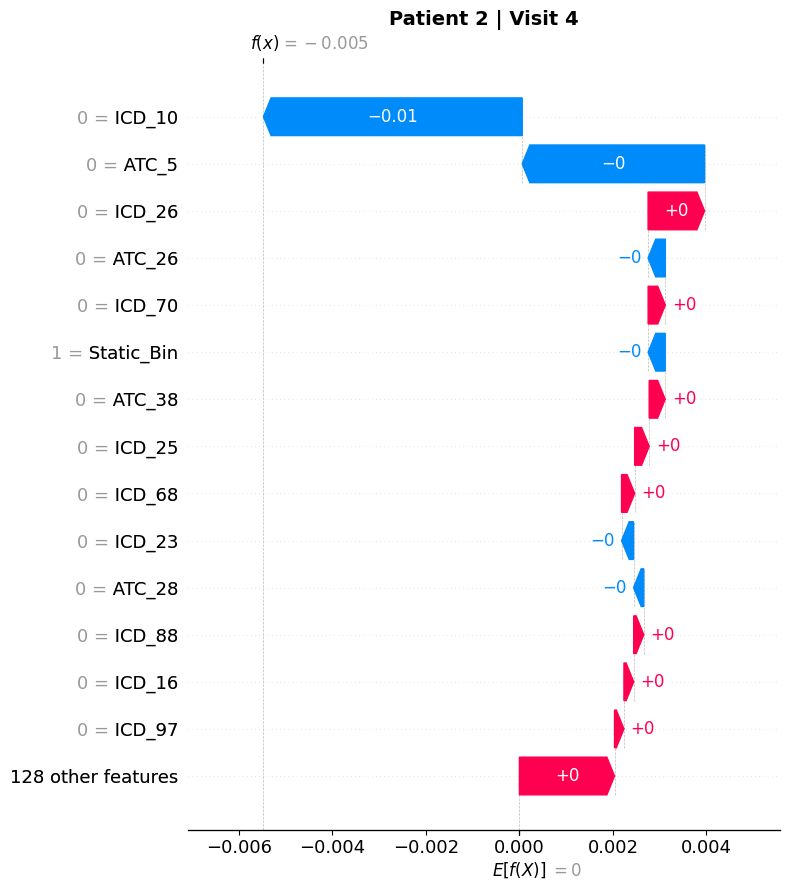

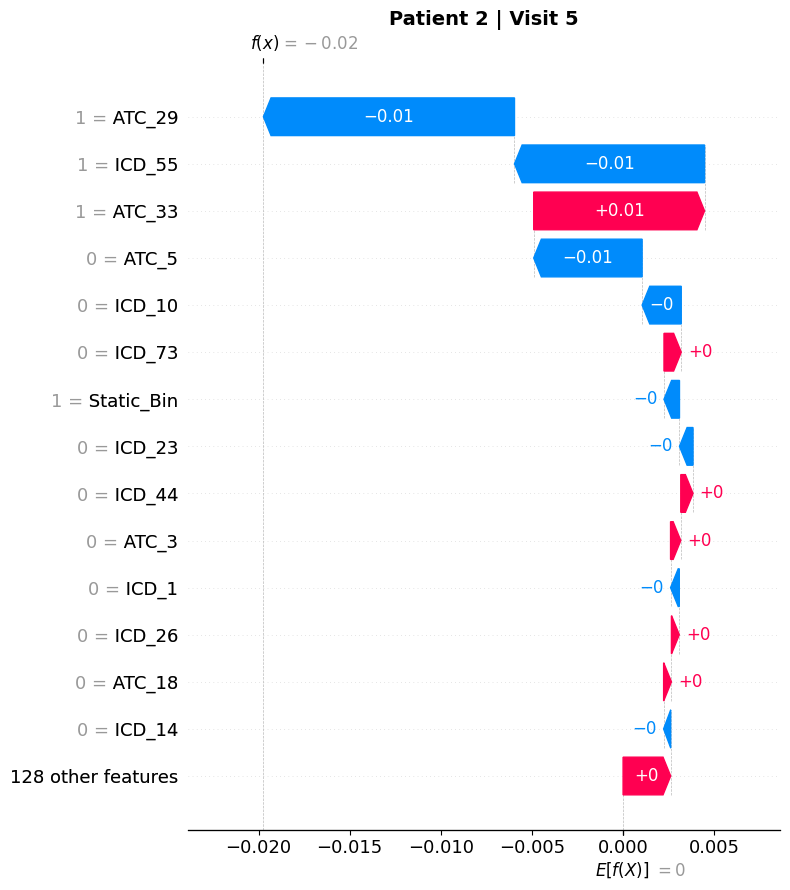

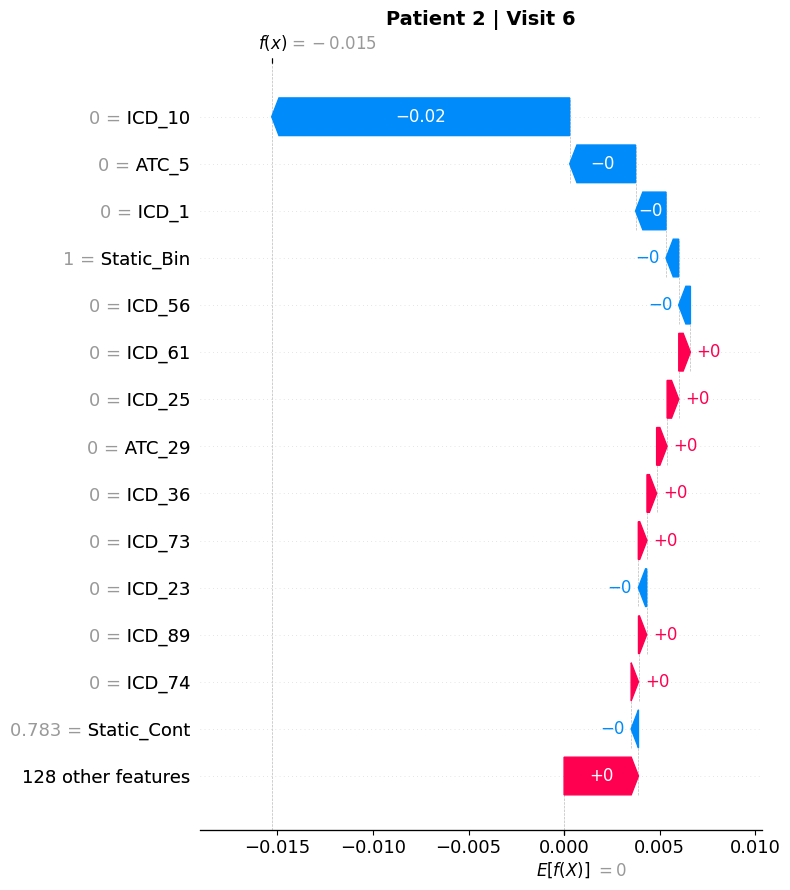

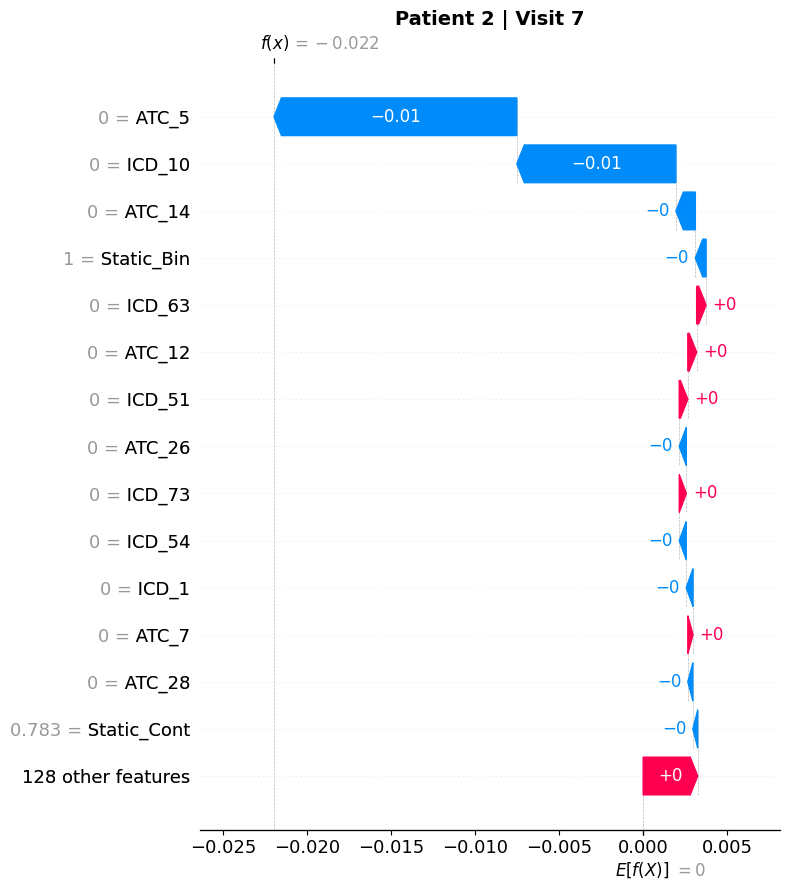

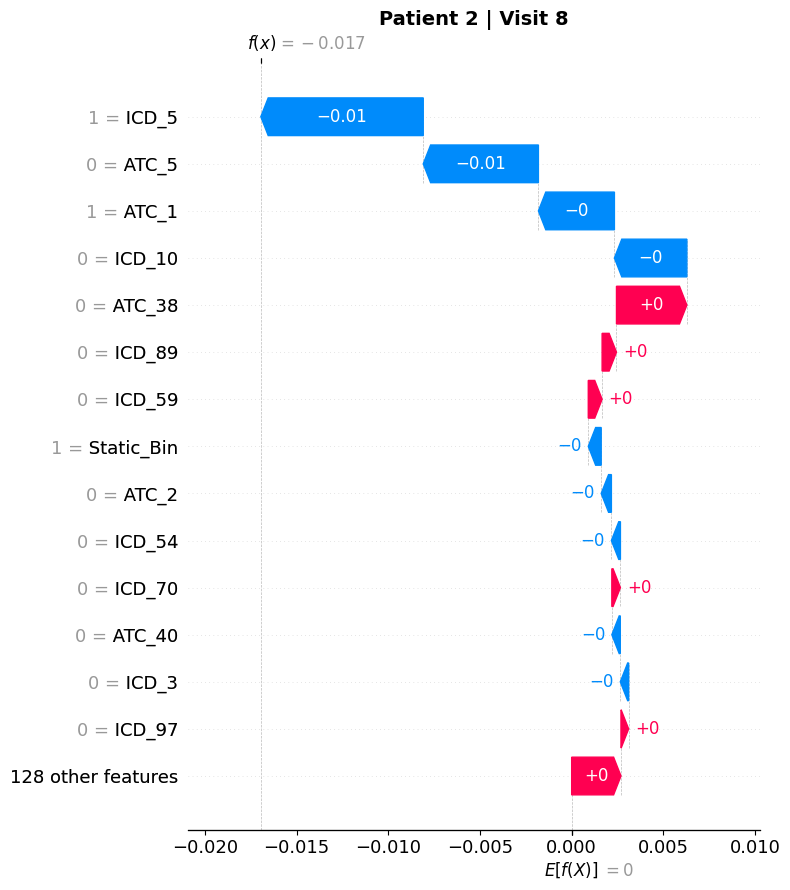

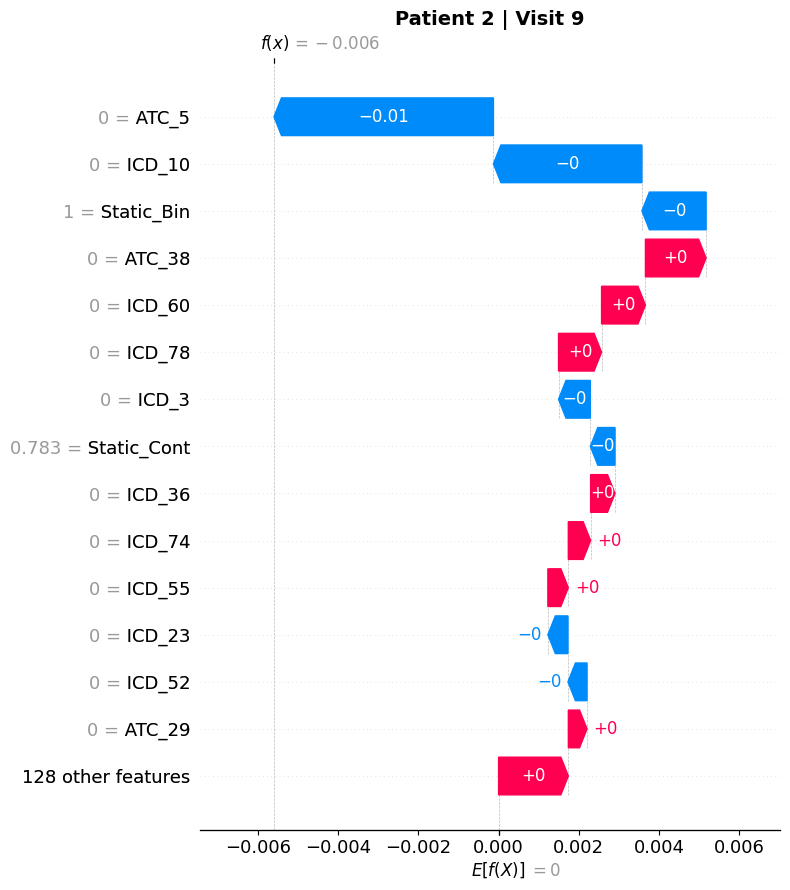

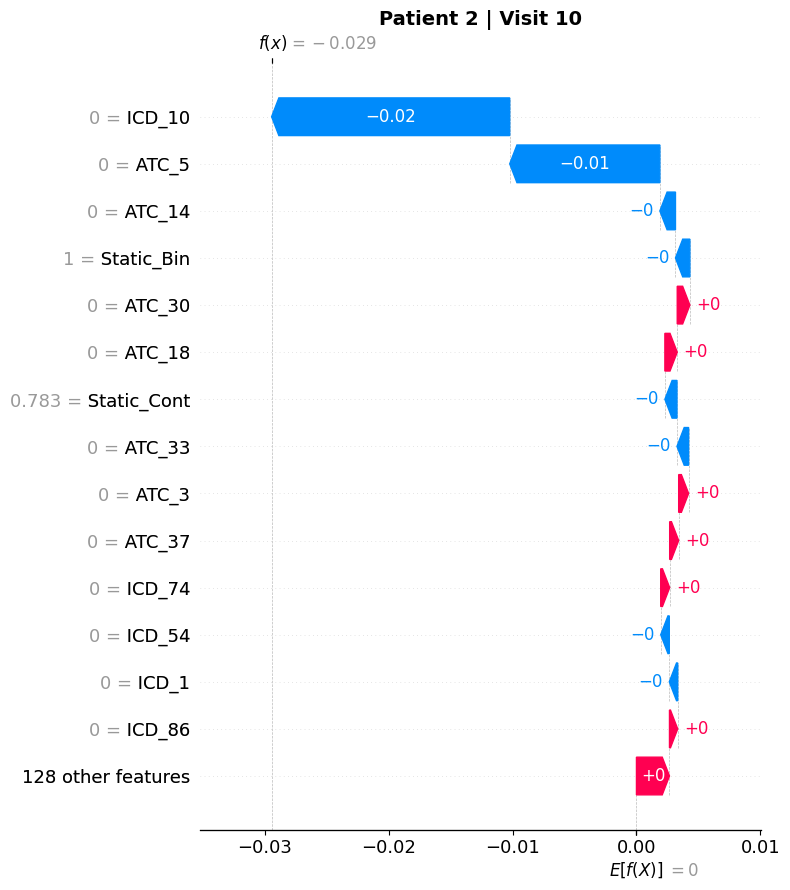

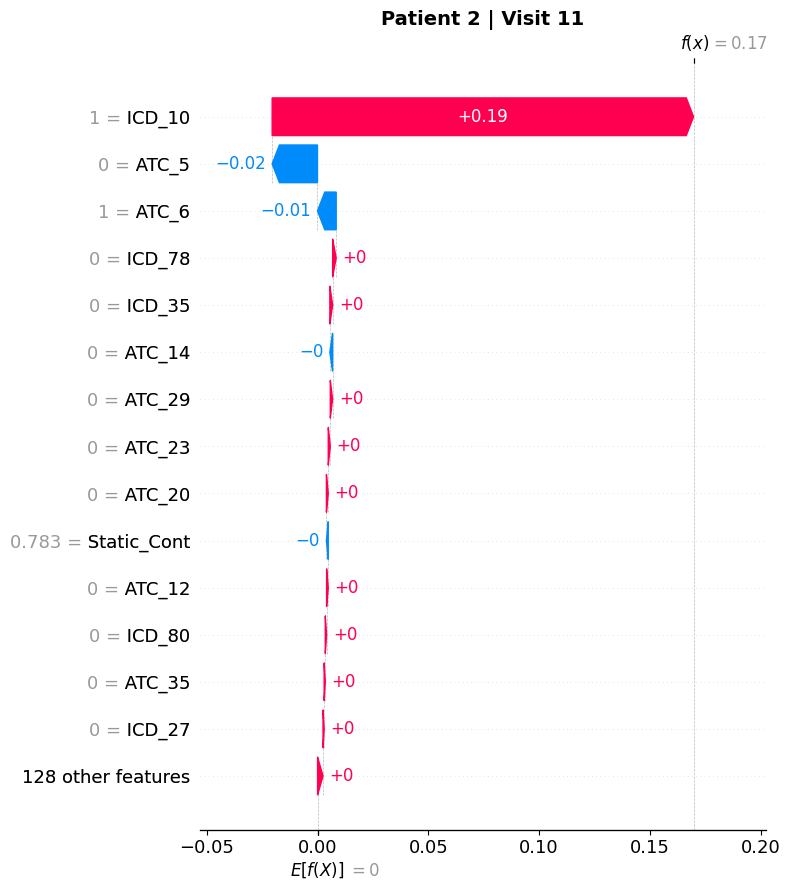

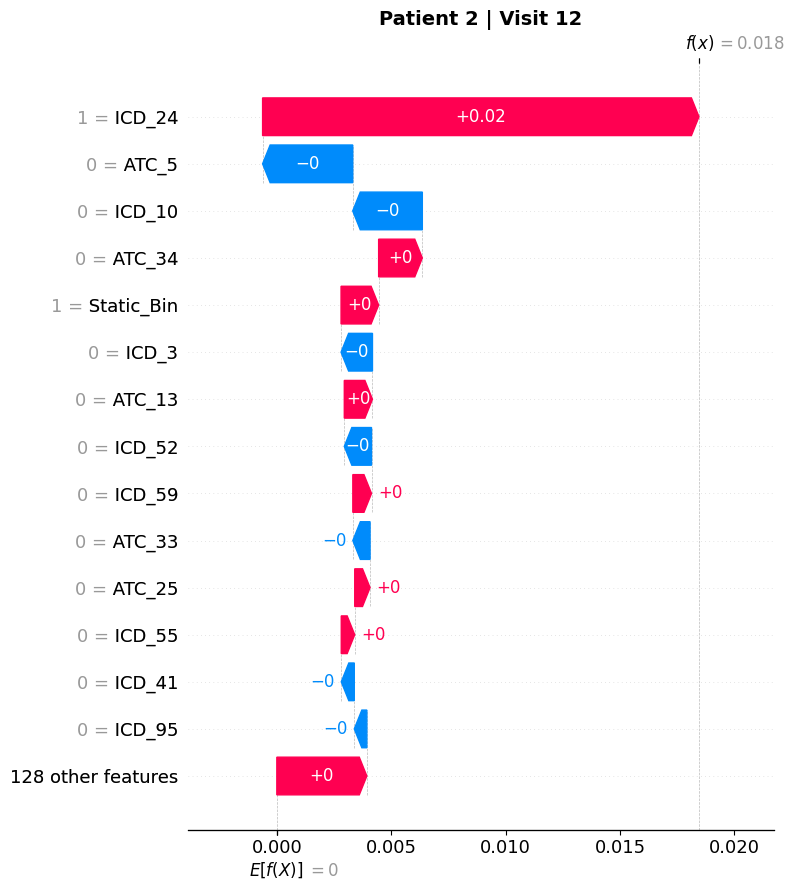

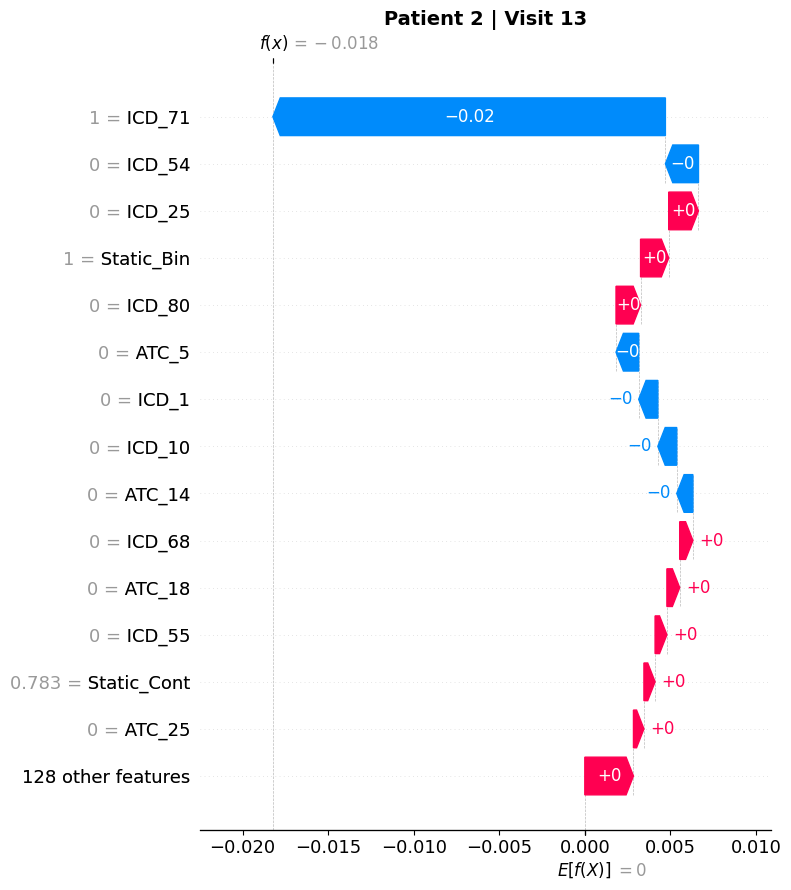

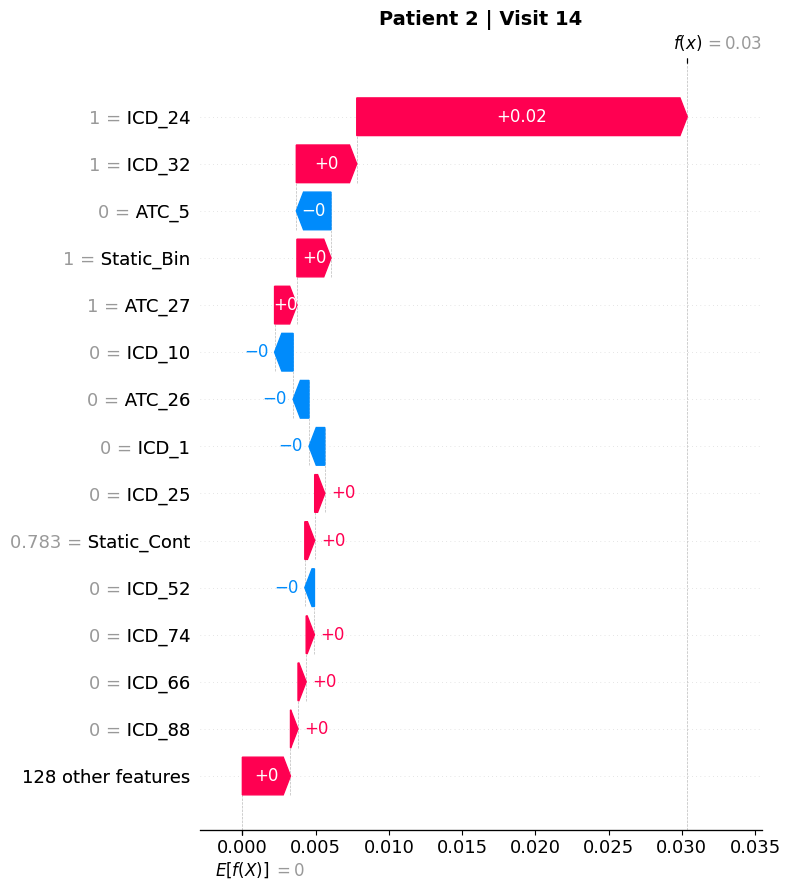

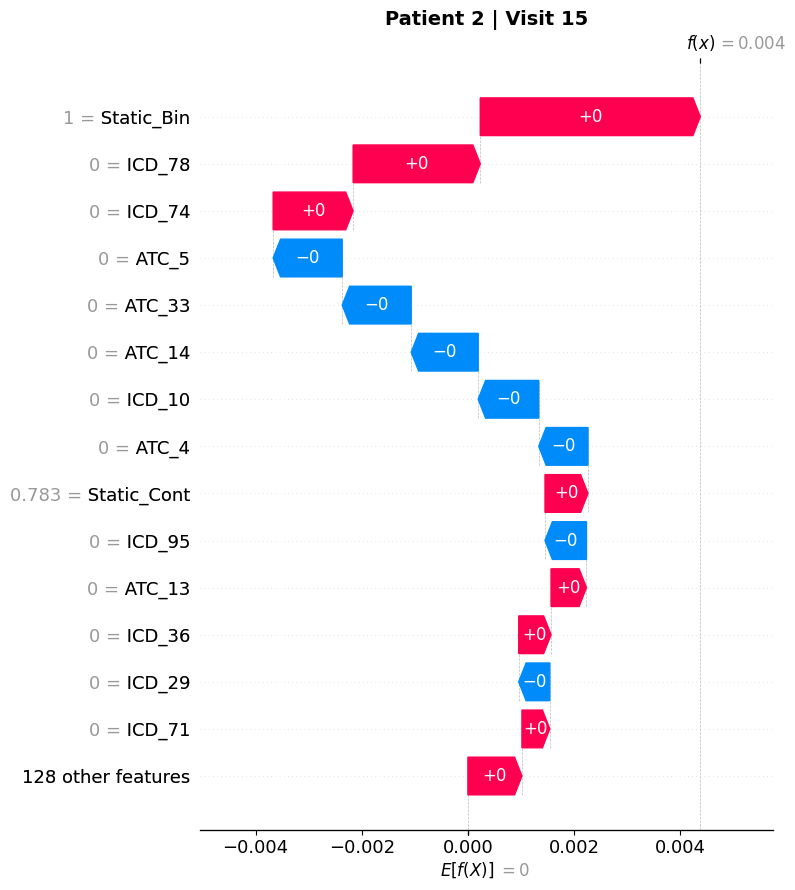

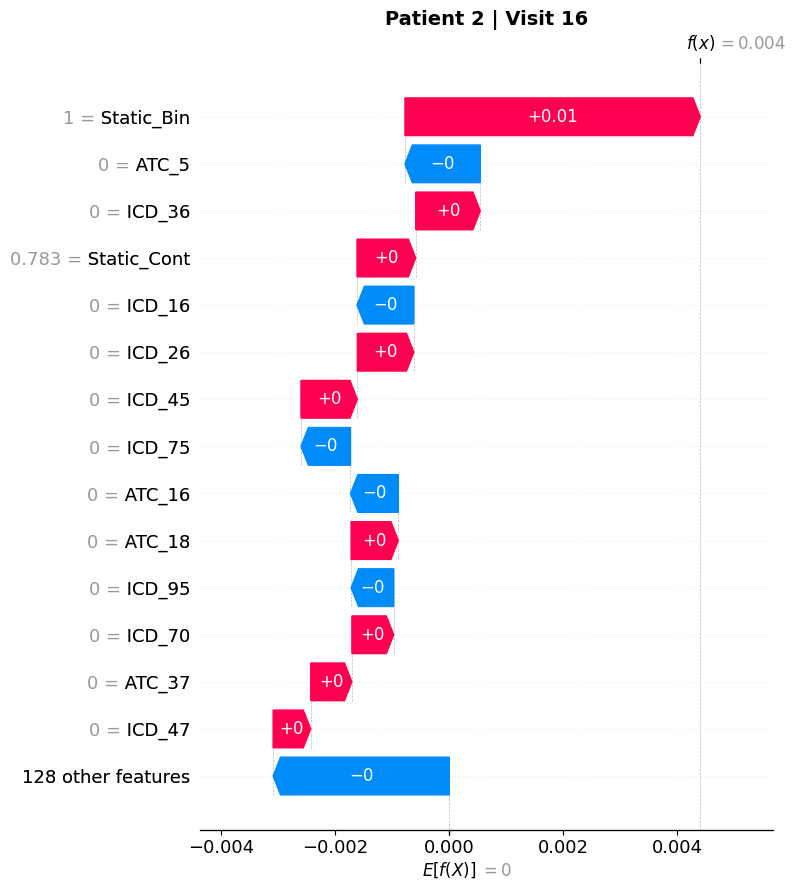

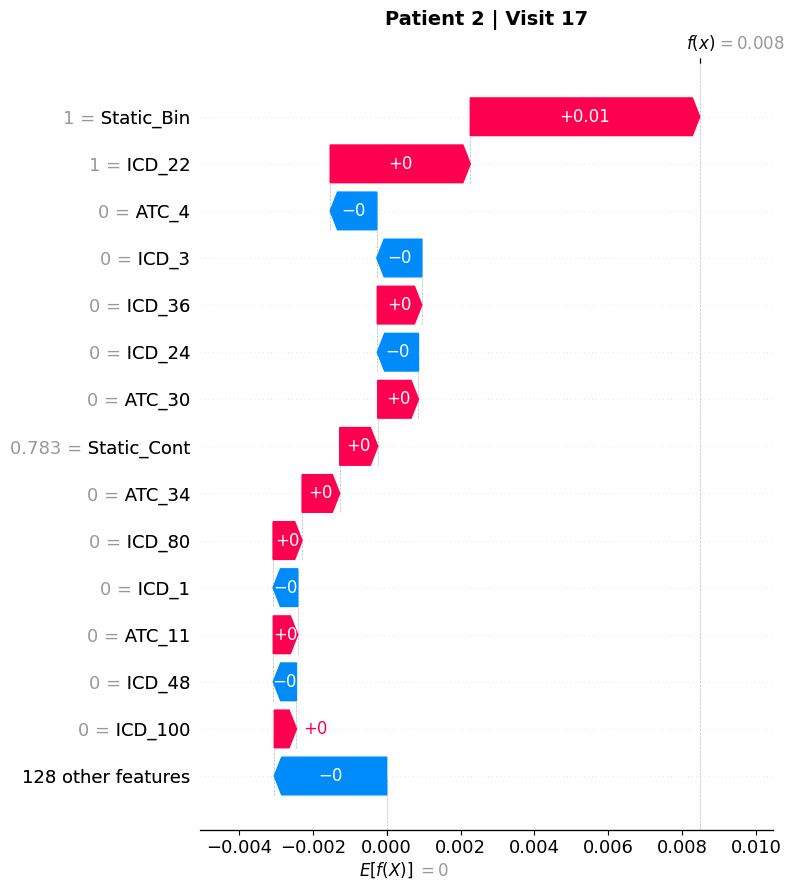

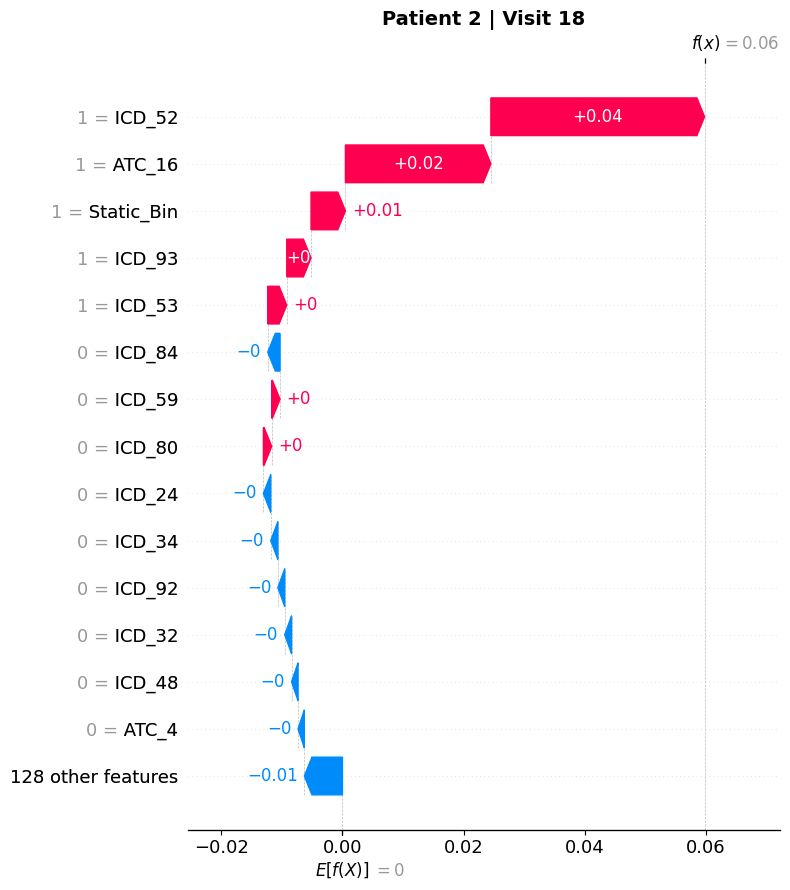

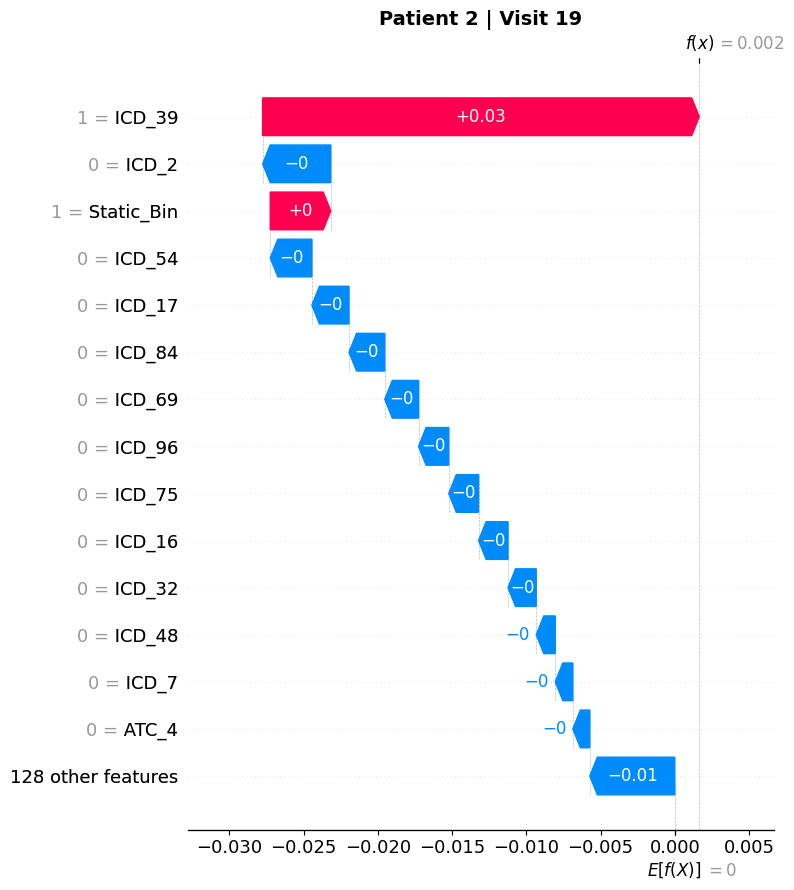

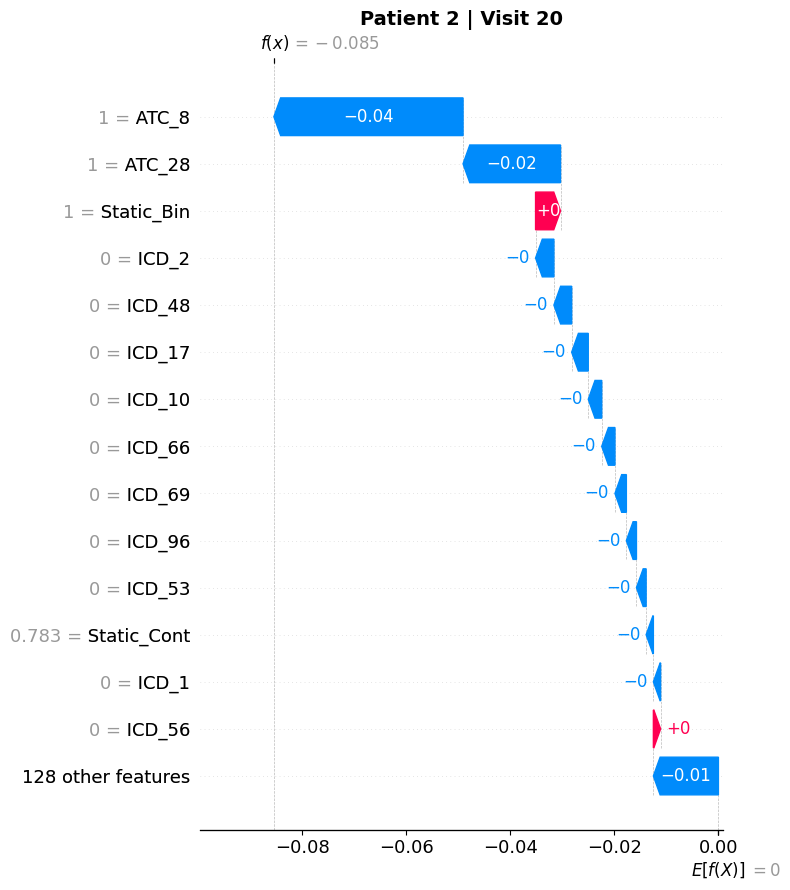

In [16]:
# Per-visit waterfall plots for every visit of patient 2
utils.plot_patient_per_visit_waterfalls(shap_gru_ntf, X_explain, feature_names, patient_idx=p, base_value=base_val_gru, top_k_visit=15)

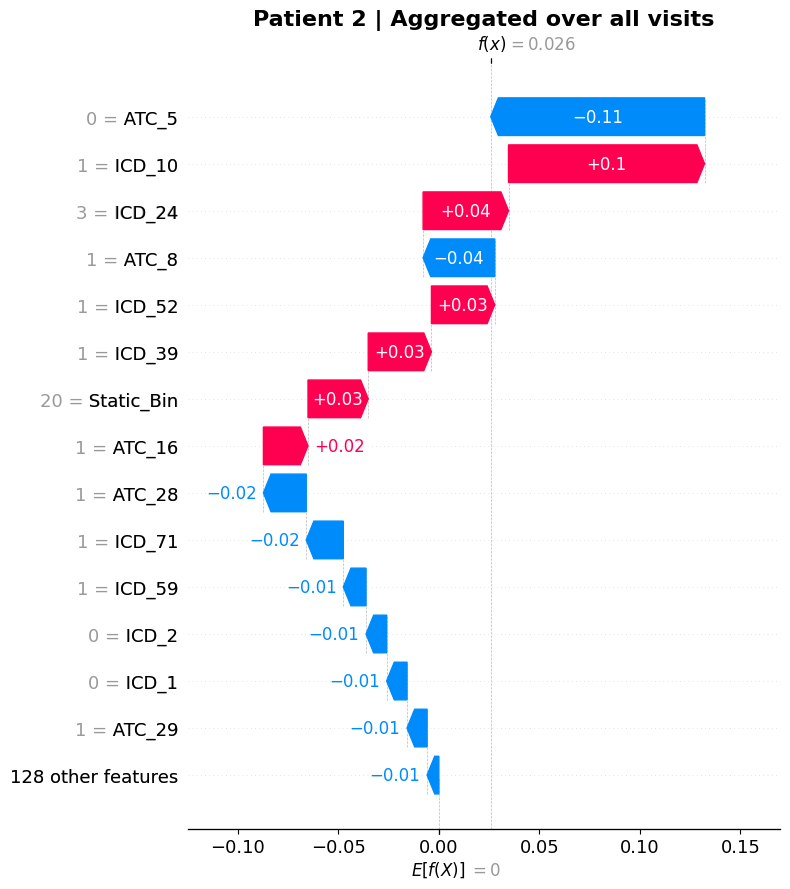

In [17]:
# Aggregated waterfall plot over all 20 visits for patient 2
utils.plot_patient_aggregated_waterfall(shap_gru_ntf, X_explain, feature_names, patient_idx=p, base_value=base_val_gru, top_k_agg=15)

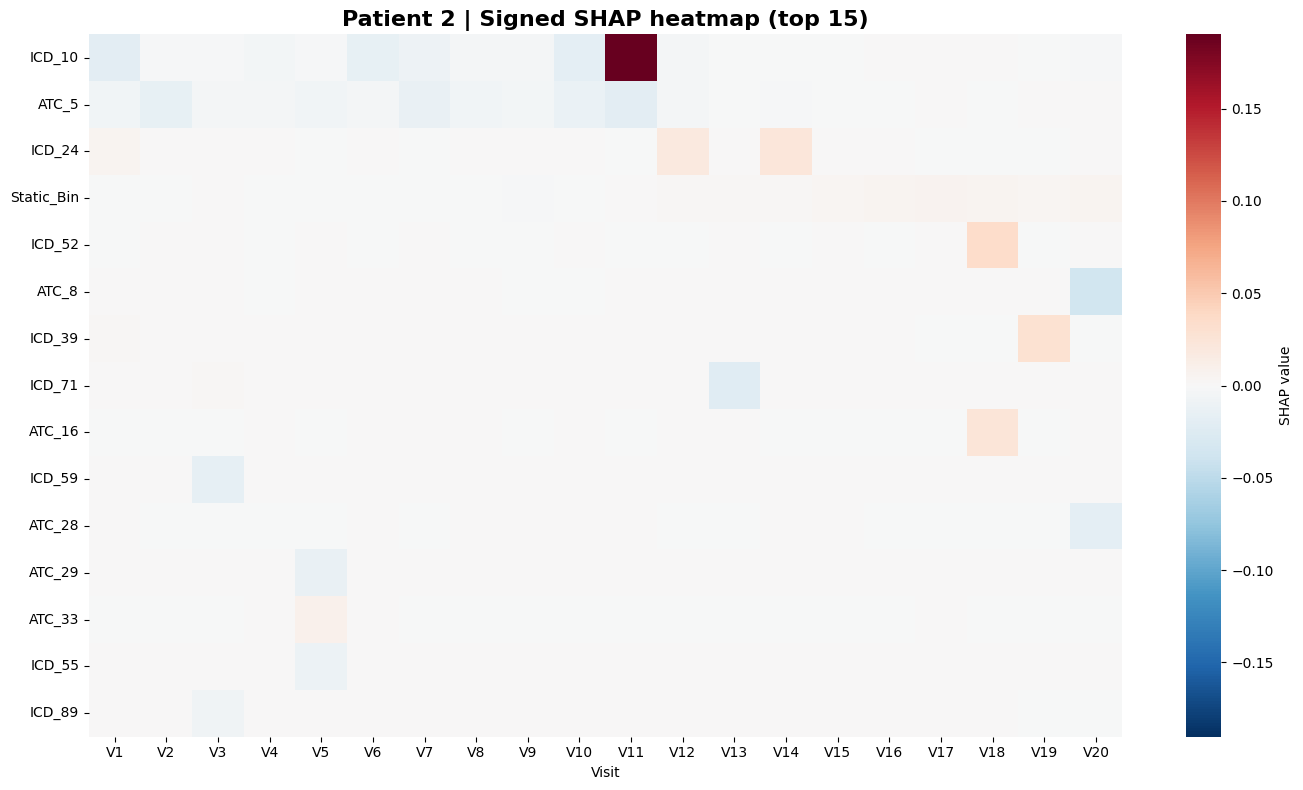

In [18]:
# Heatmap for patient 2, showing absolute SHAP values for the 15 most important features over all 20 visits
utils.plot_patient_signed_shap_heatmap(shap_gru_ntf, feature_names, patient_idx=p, top_k=15)

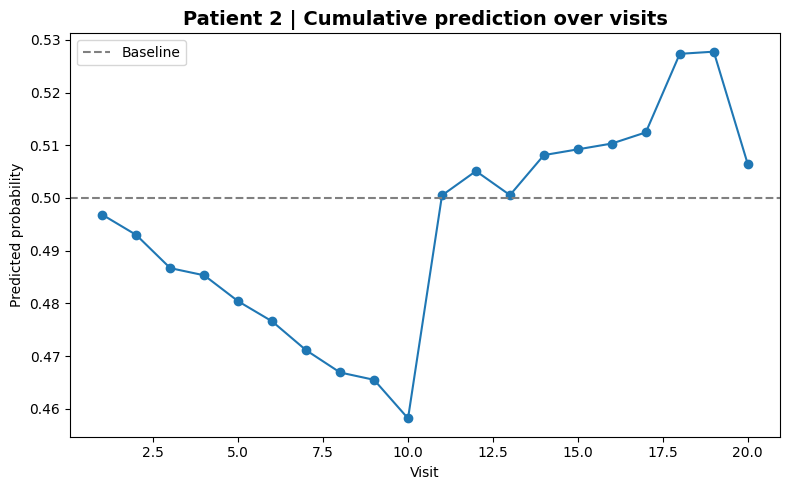

In [19]:
# Cumulative prediction over all 20 visits for patient 2
utils.plot_patient_cumulative_prediction(
    shap_gru_ntf,
    patient_idx=2,
    base_value=base_val_gru,
    convert_to_probability=True
)

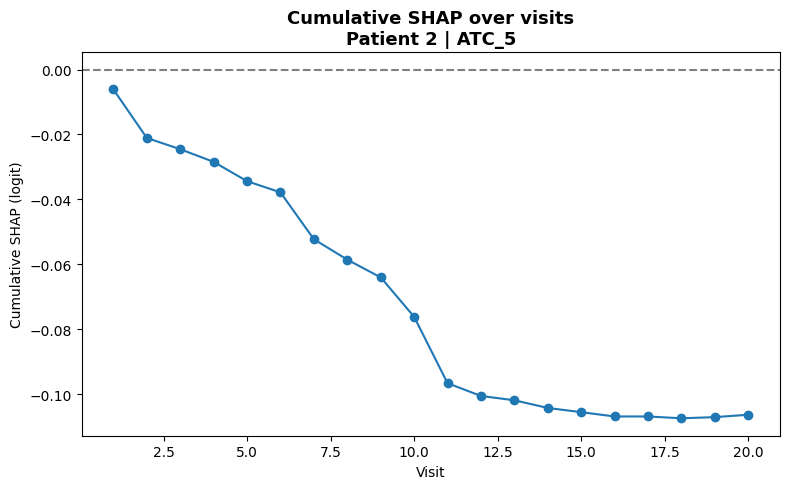

In [20]:
# Cumulative SHAP for patient 2 over all 20 visits for feature ATC 5
utils.plot_feature_cumulative(
    shap_gru_ntf,
    feature_names,
    patient_idx=2,
    feature_name="ATC_5"
)


##### 2.3 LSTM

In [ ]:
# How many test samples to explain
#N_EXPLAIN = min(256, len(X_test_np))
#X_explain = X_test_np[:N_EXPLAIN]
X_explain = X_test_np  # all patients

# ---- LSTM ----
expl_lstm, shap_lstm_ntf, base_lstm = utils.compute_eg_rnn(
    model_lstm, X_train_np, X_explain,
    background_size=128, nsamples=200
)
print("LSTM shap:", shap_lstm_ntf.shape)  # (N, T, F)


LSTM shap: (600, 20, 142)


##### 2.4 Special cases - GRU vs LSTM

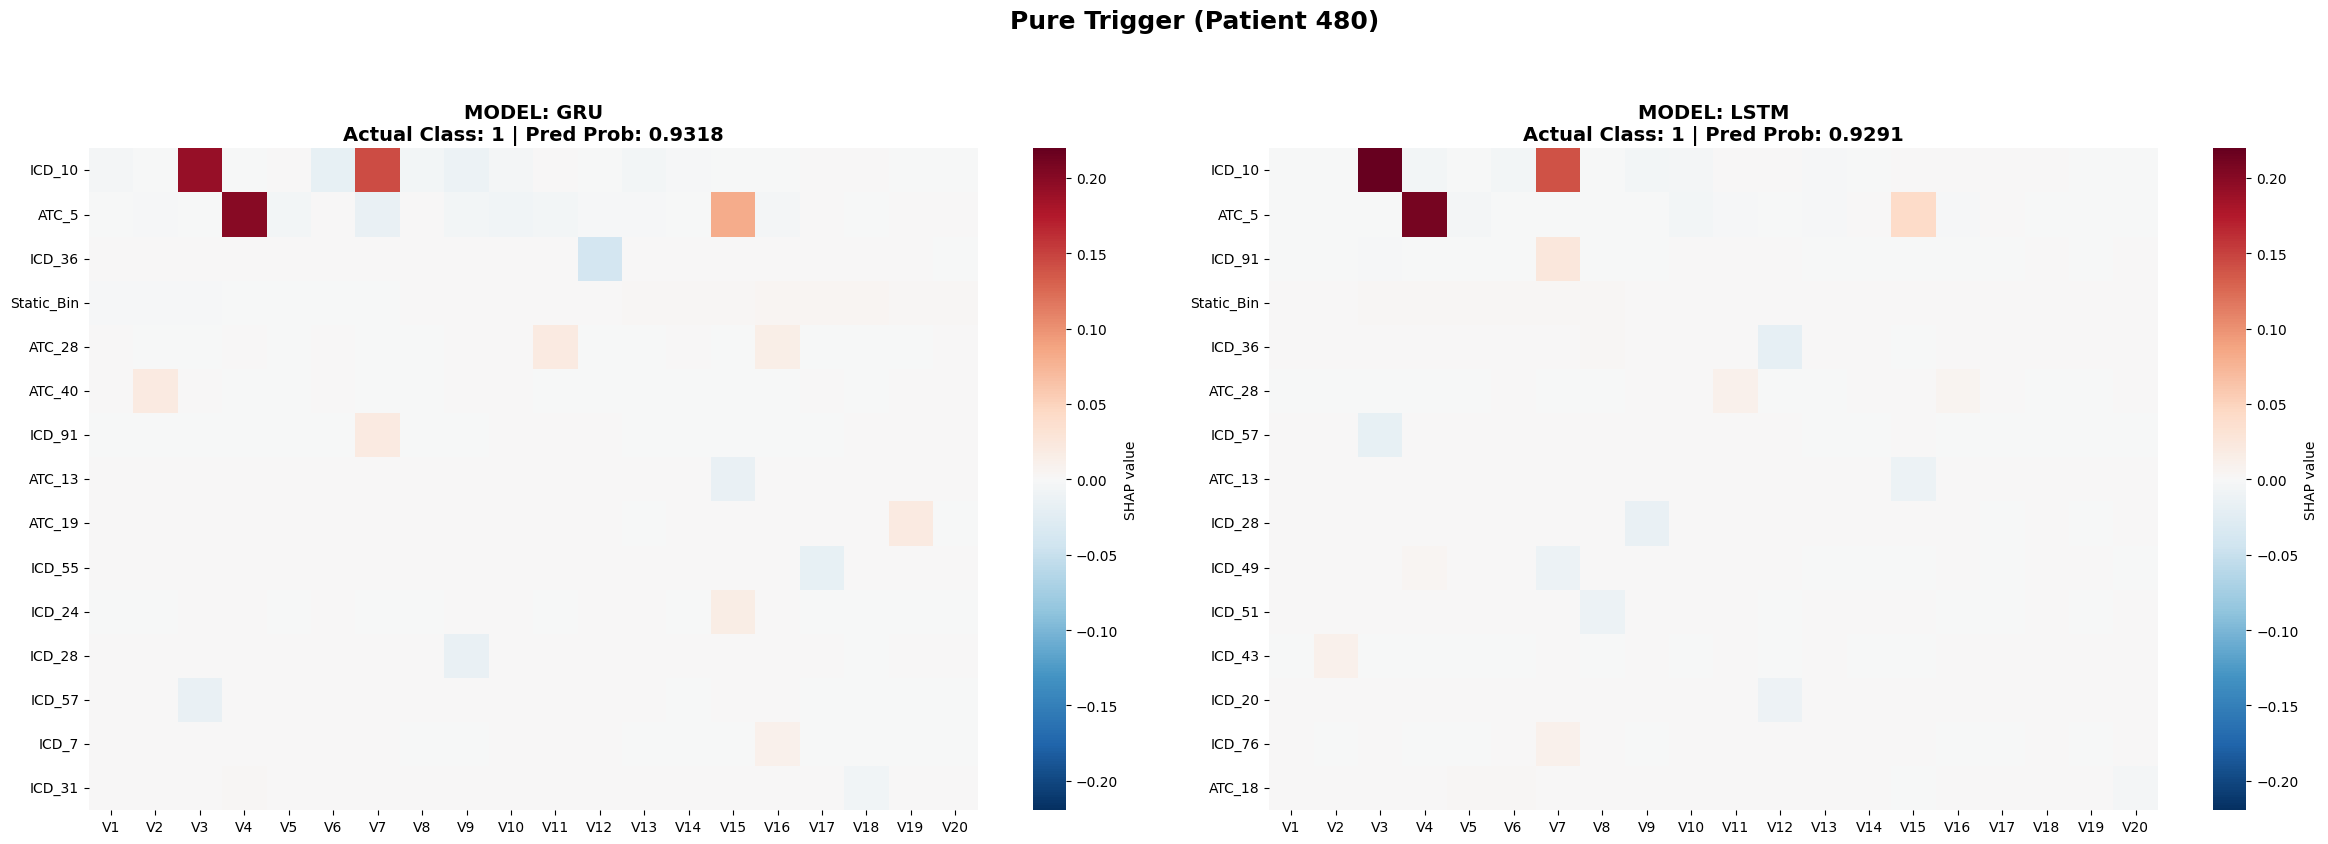

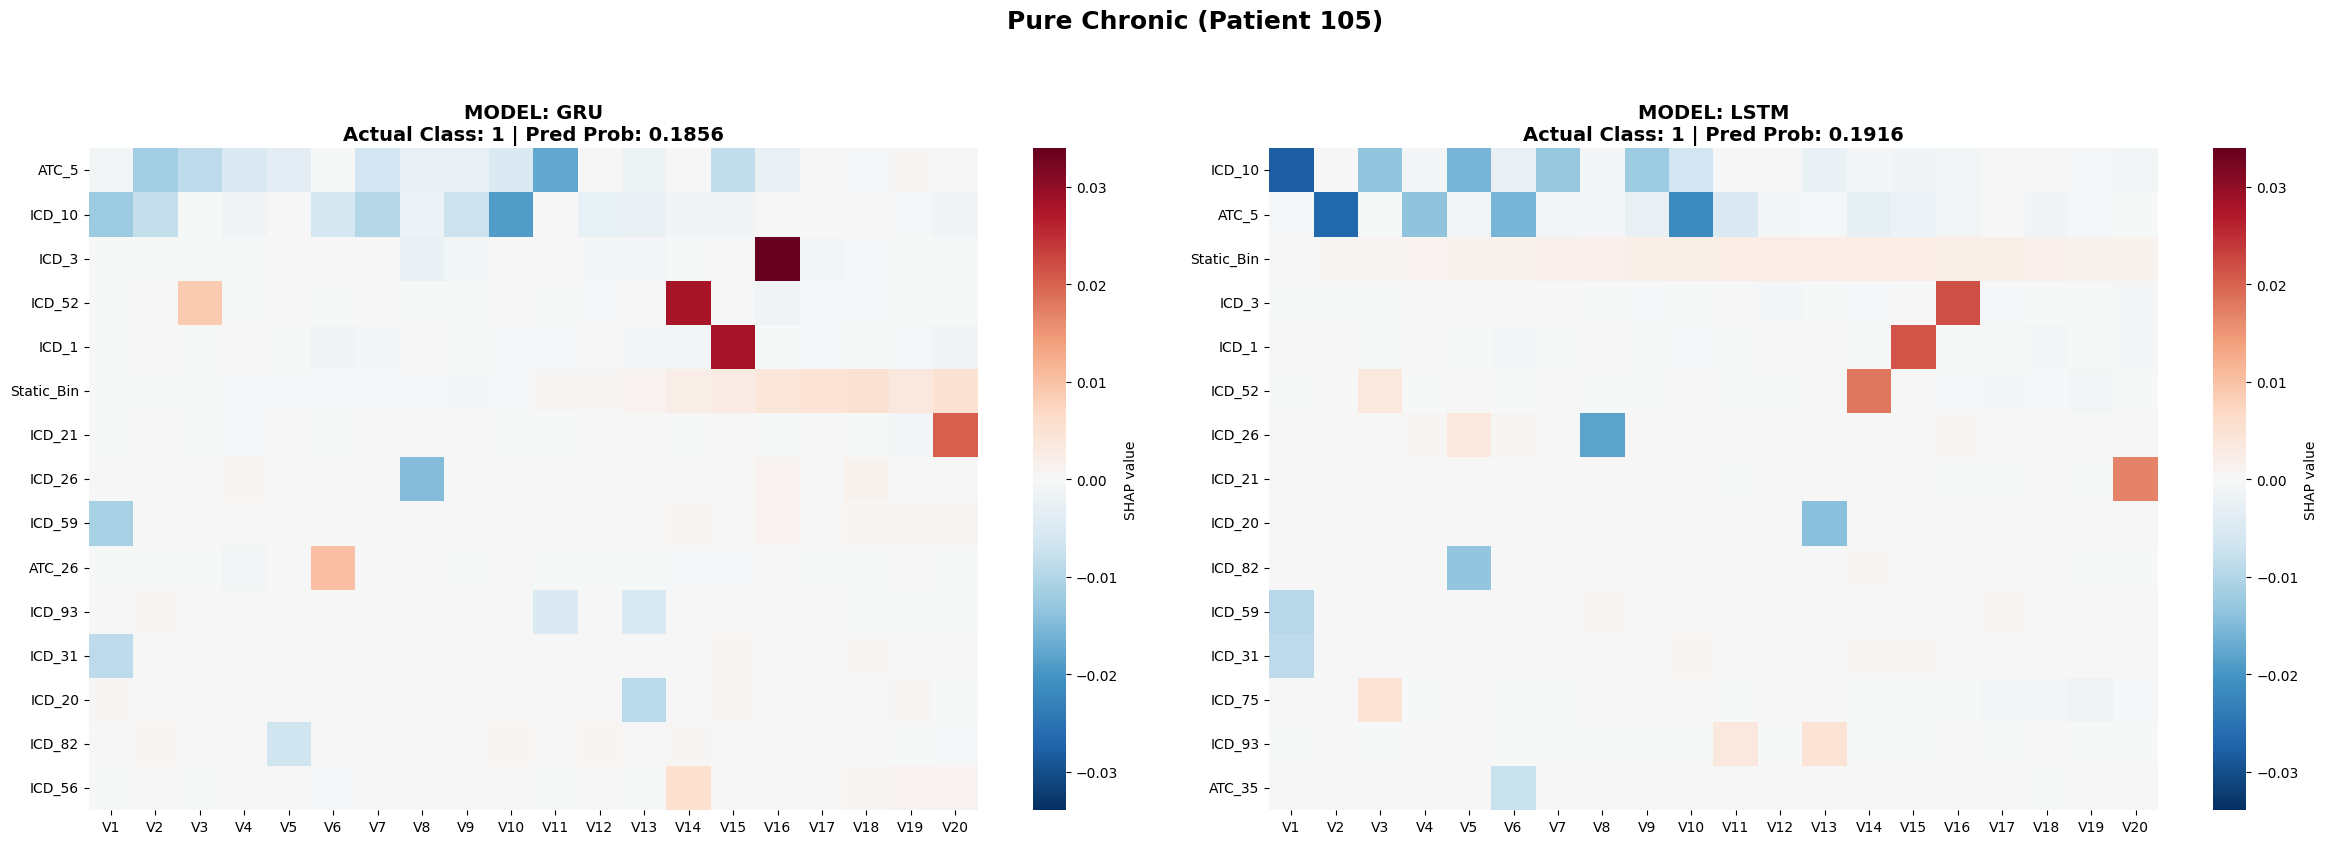

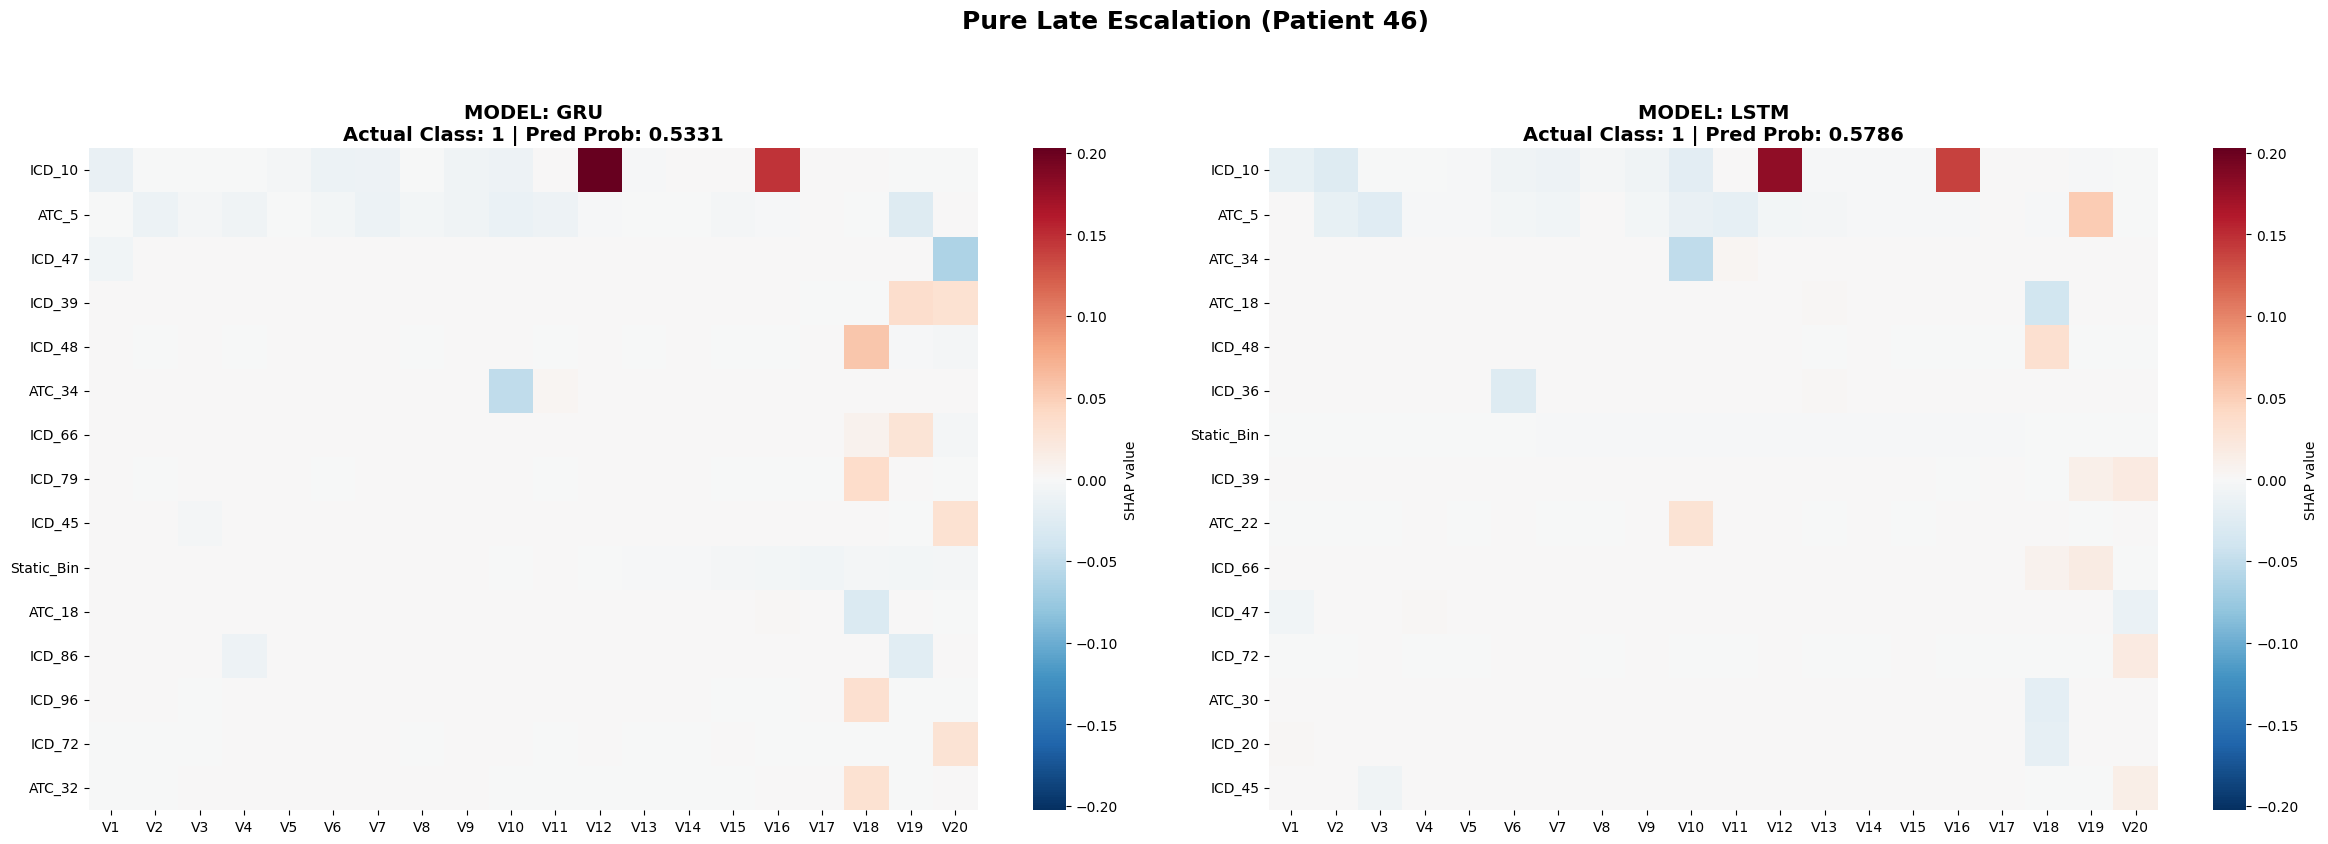

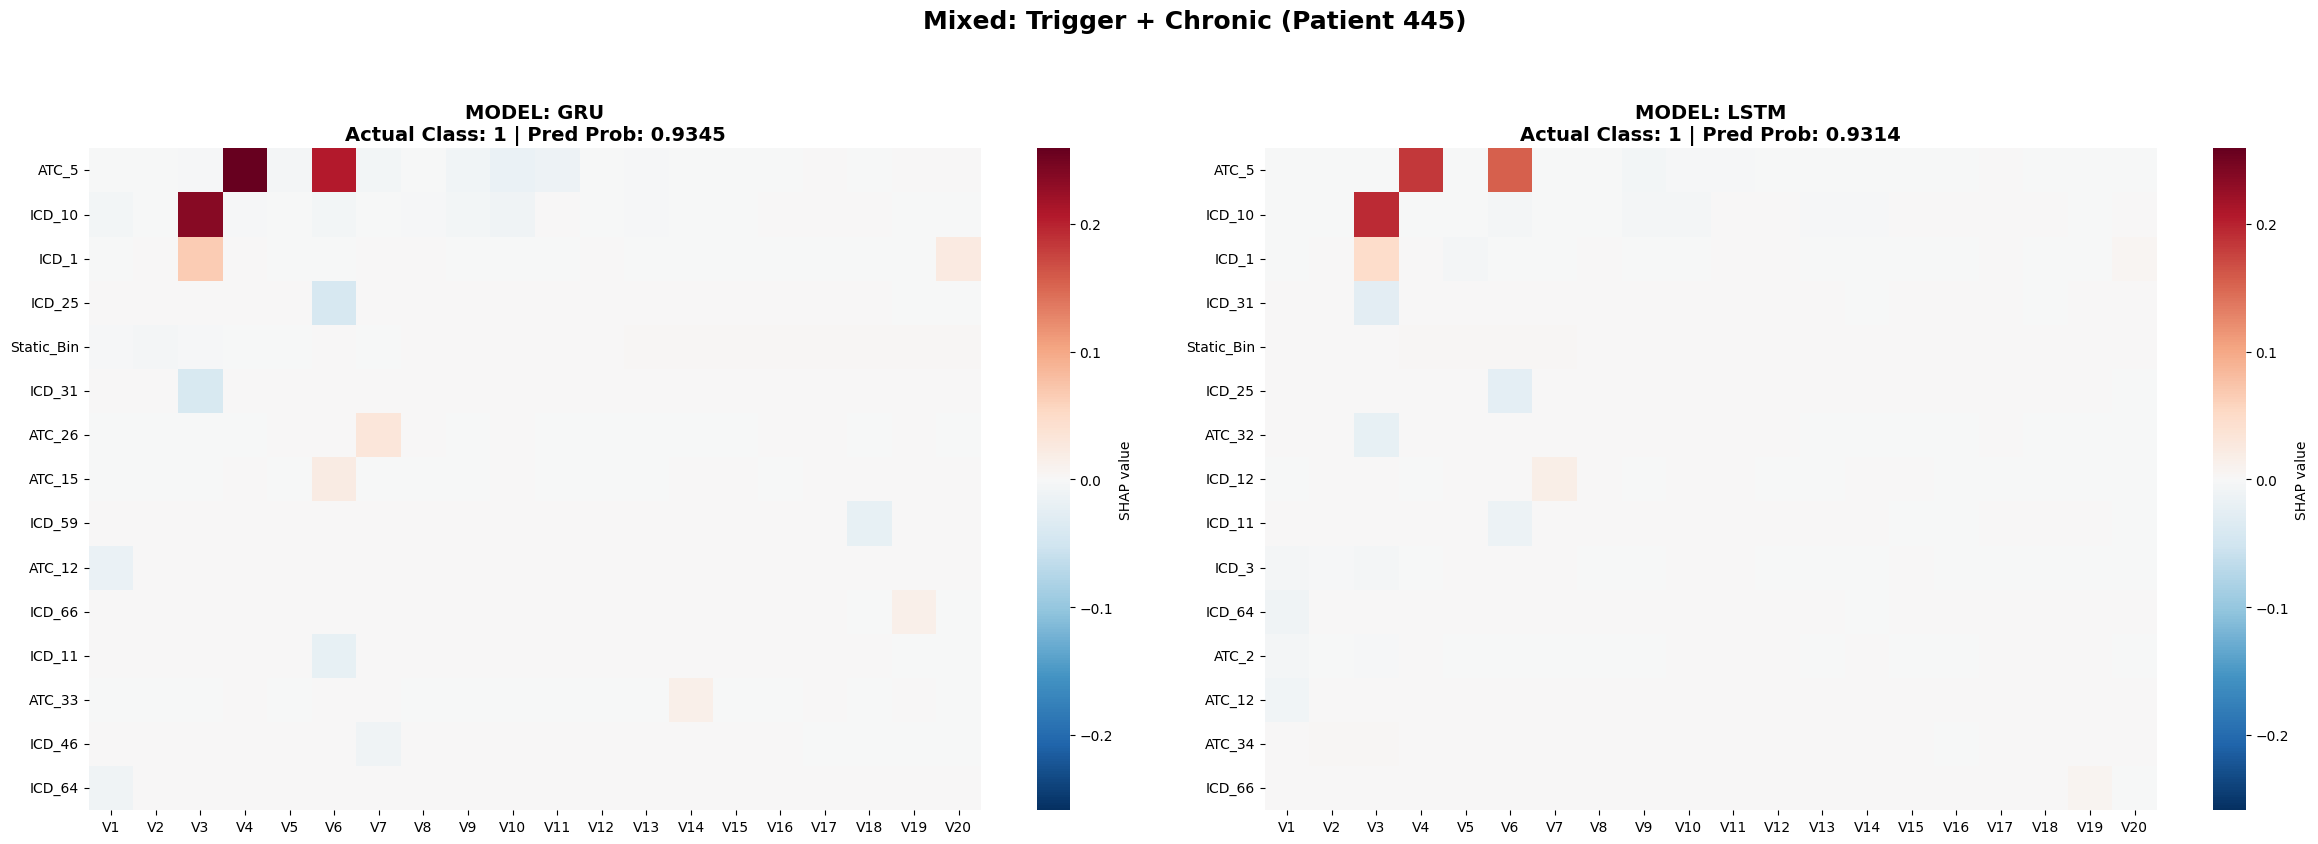

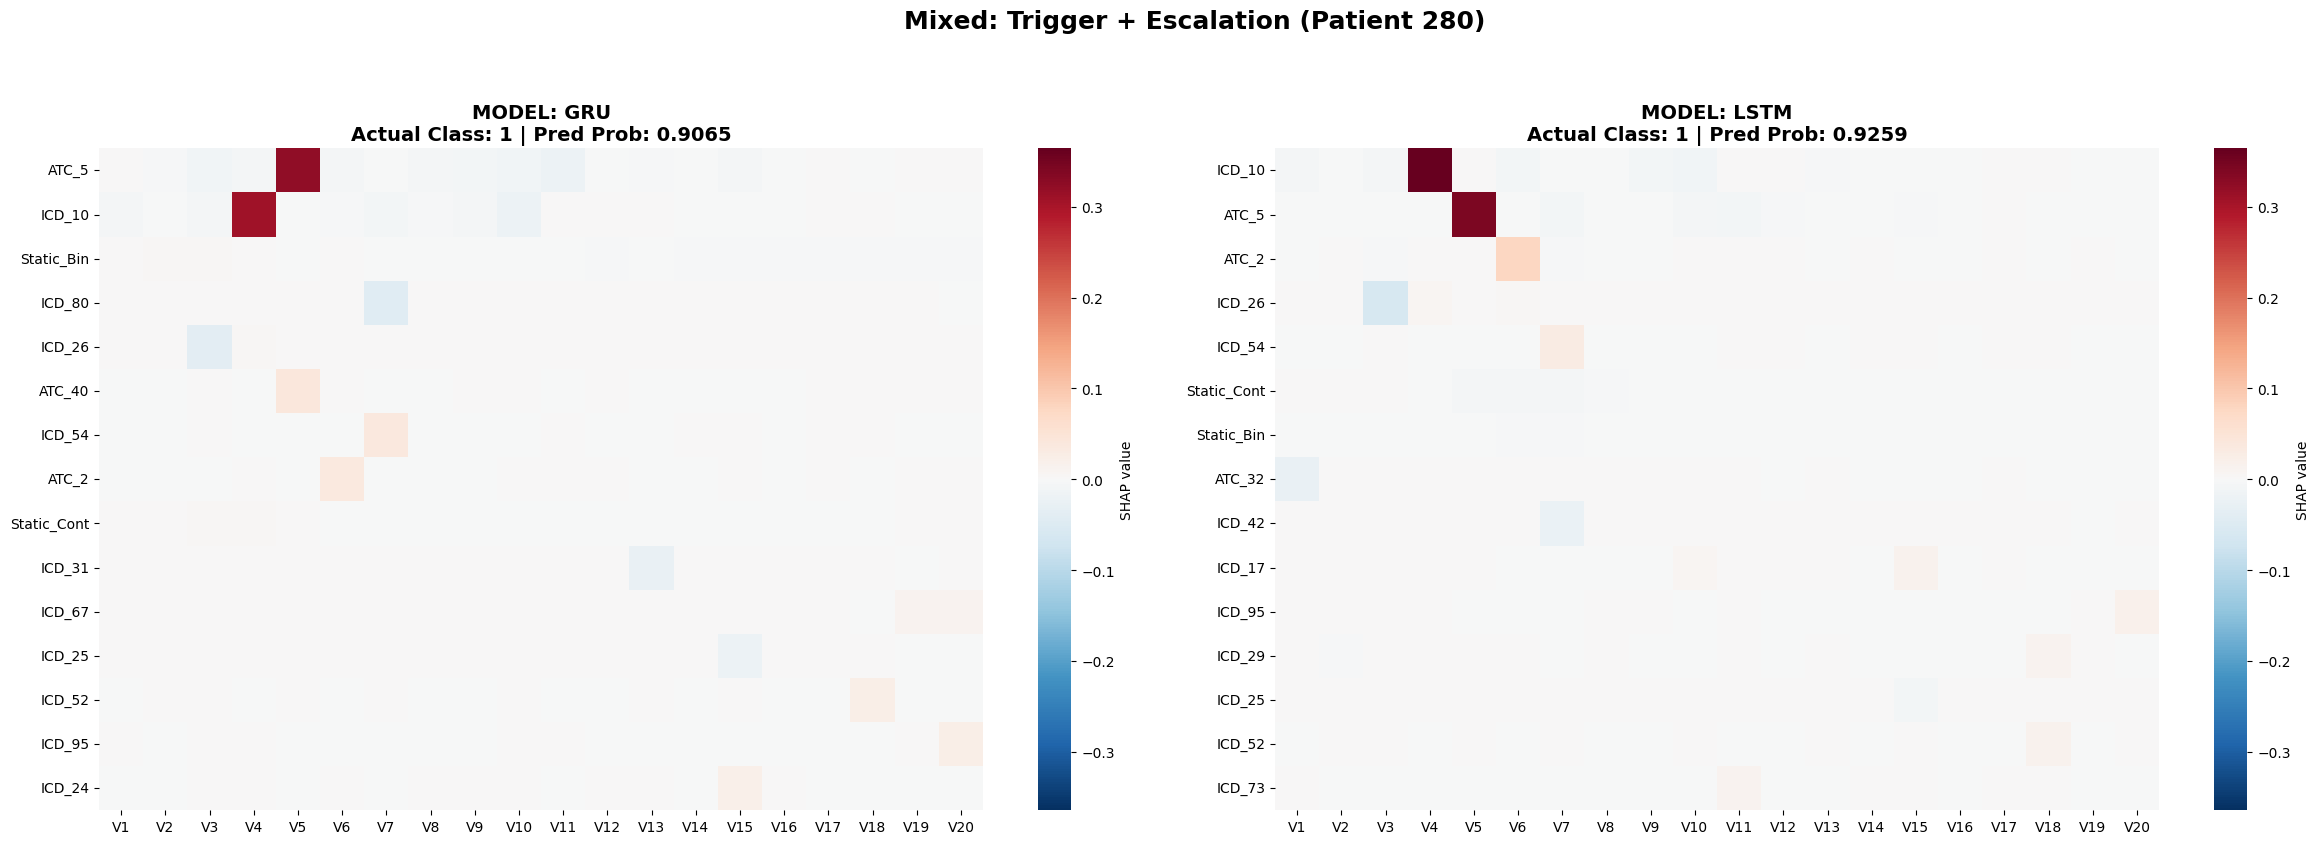

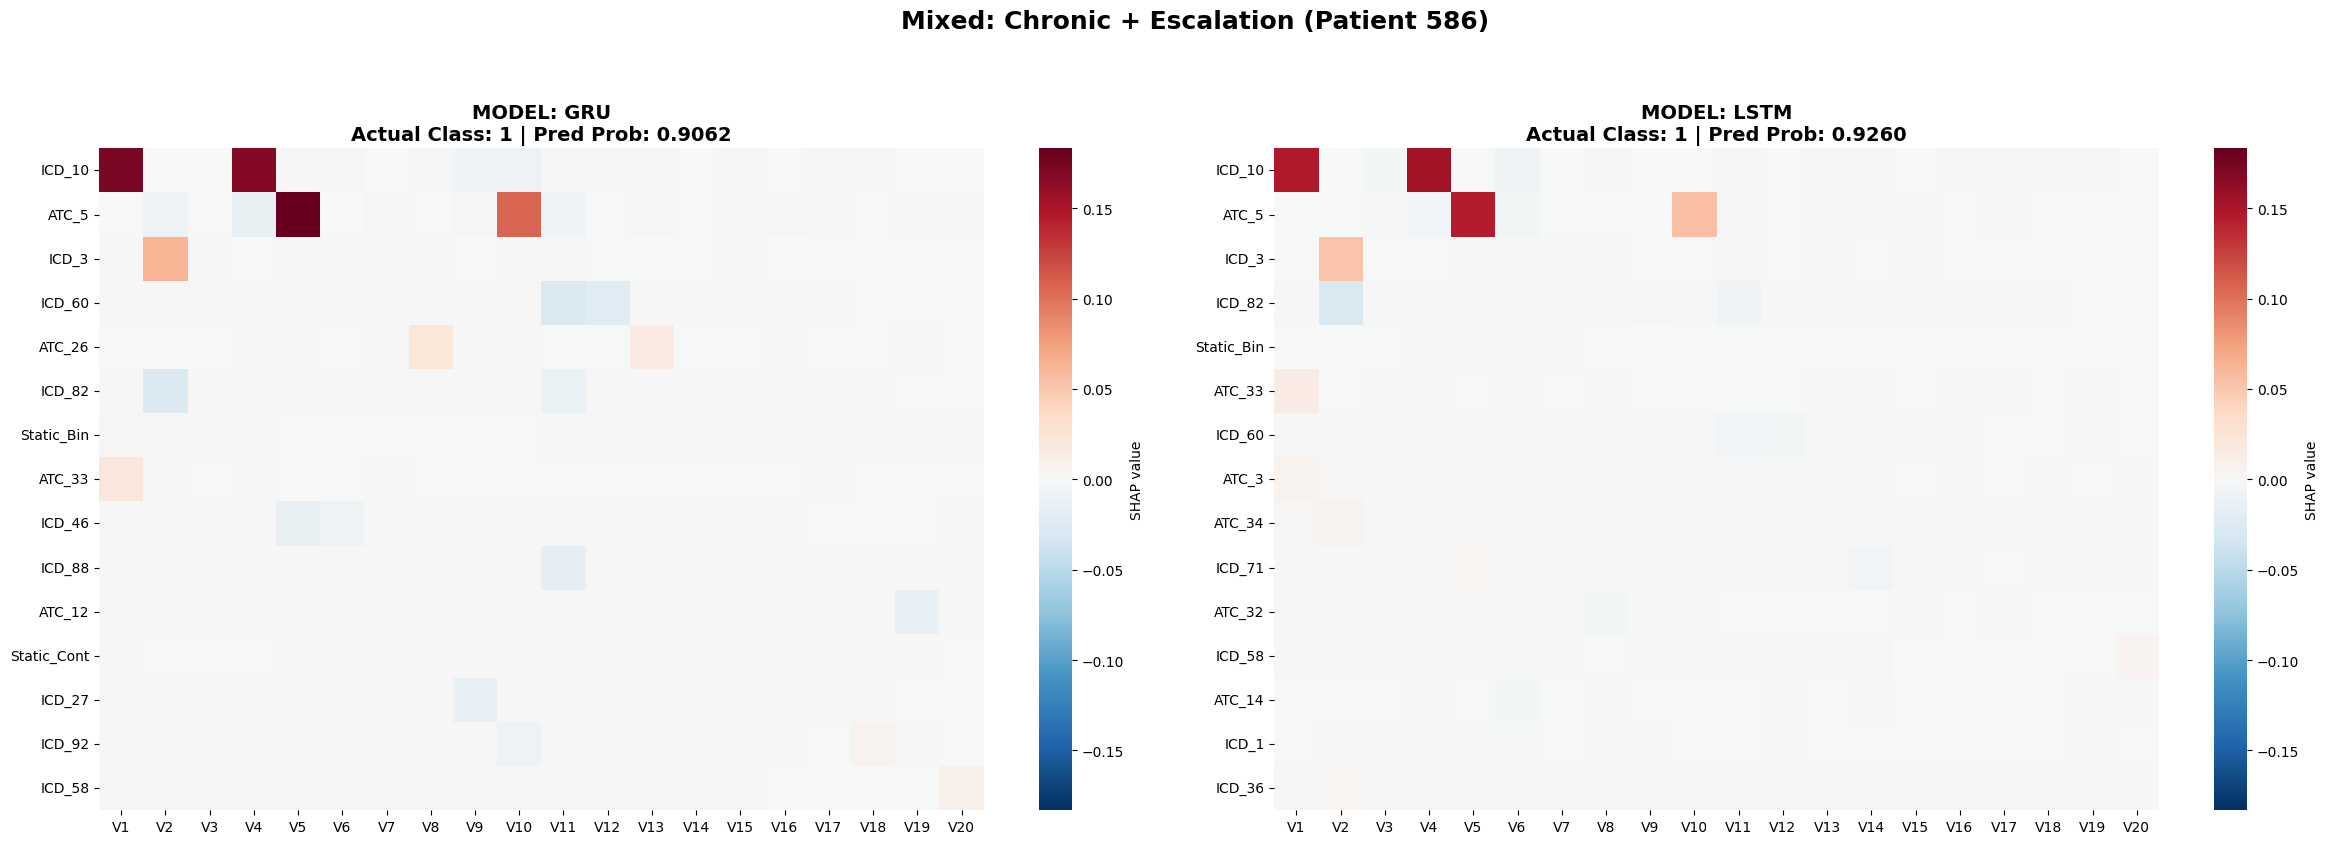

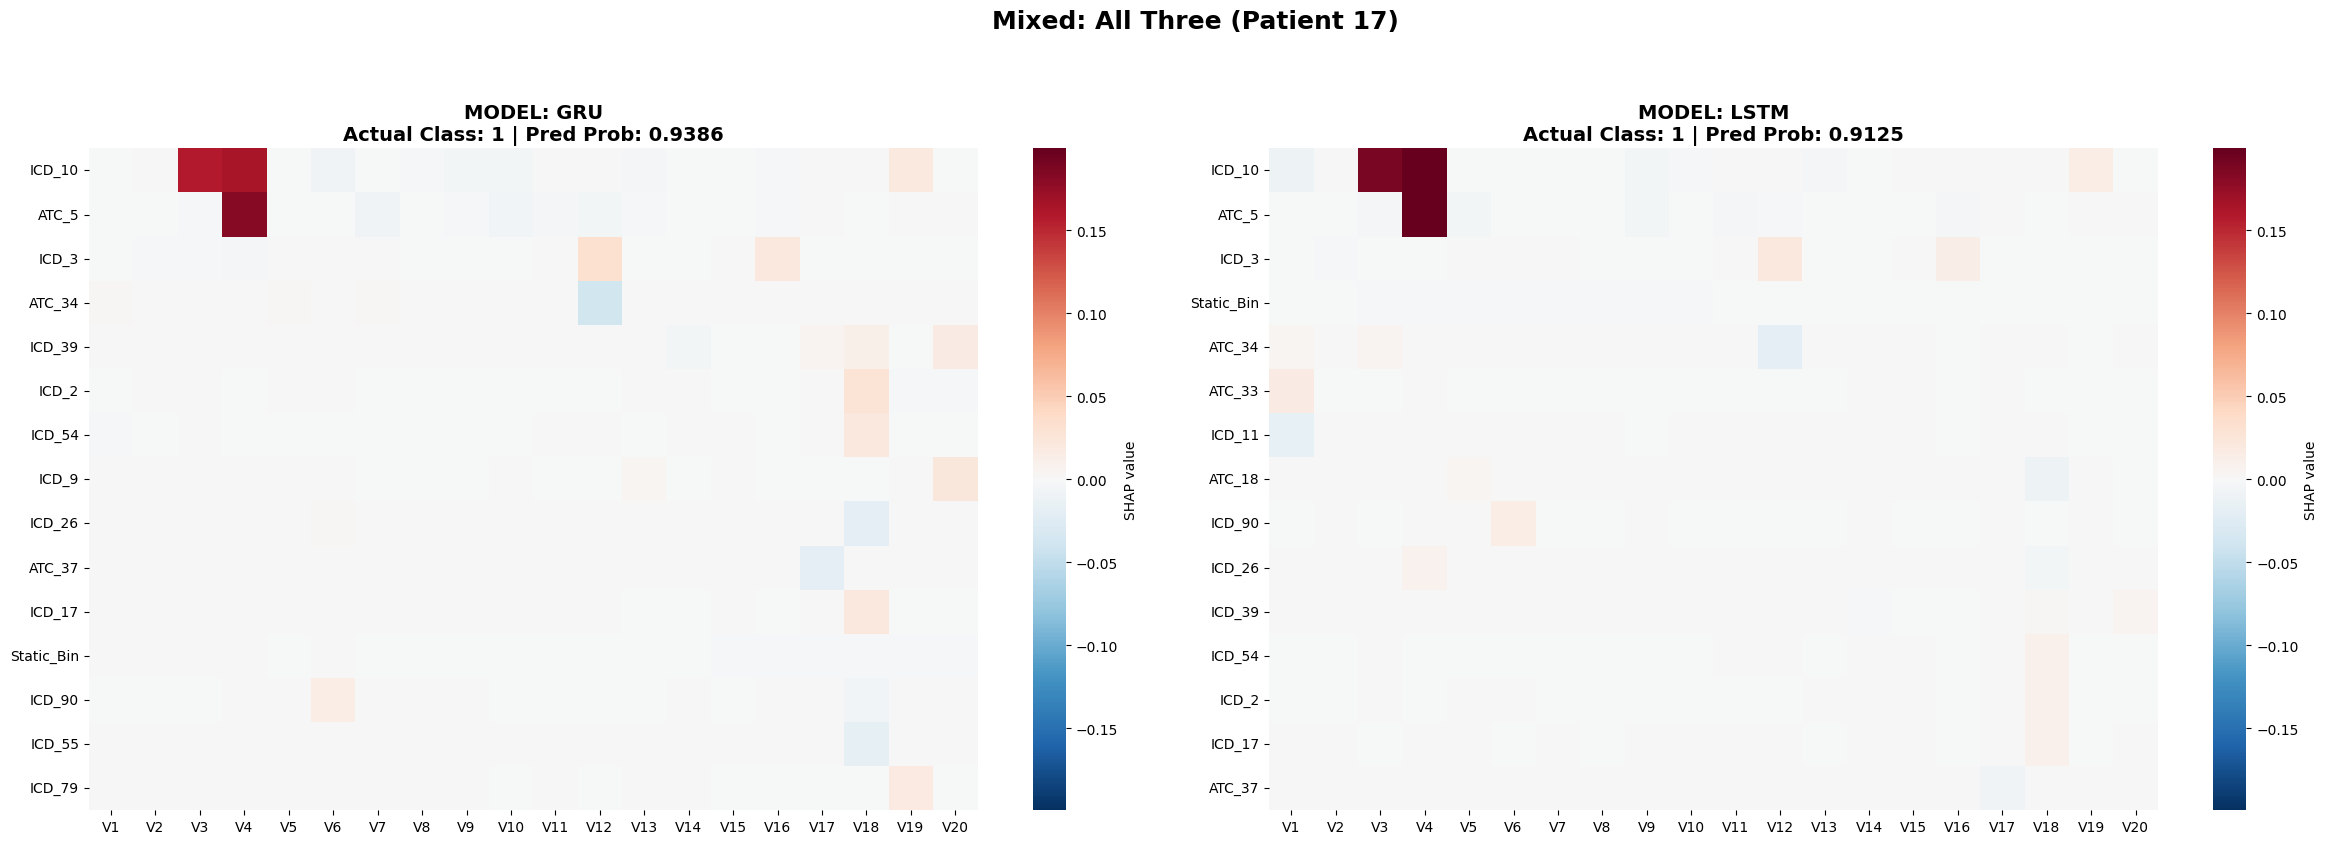

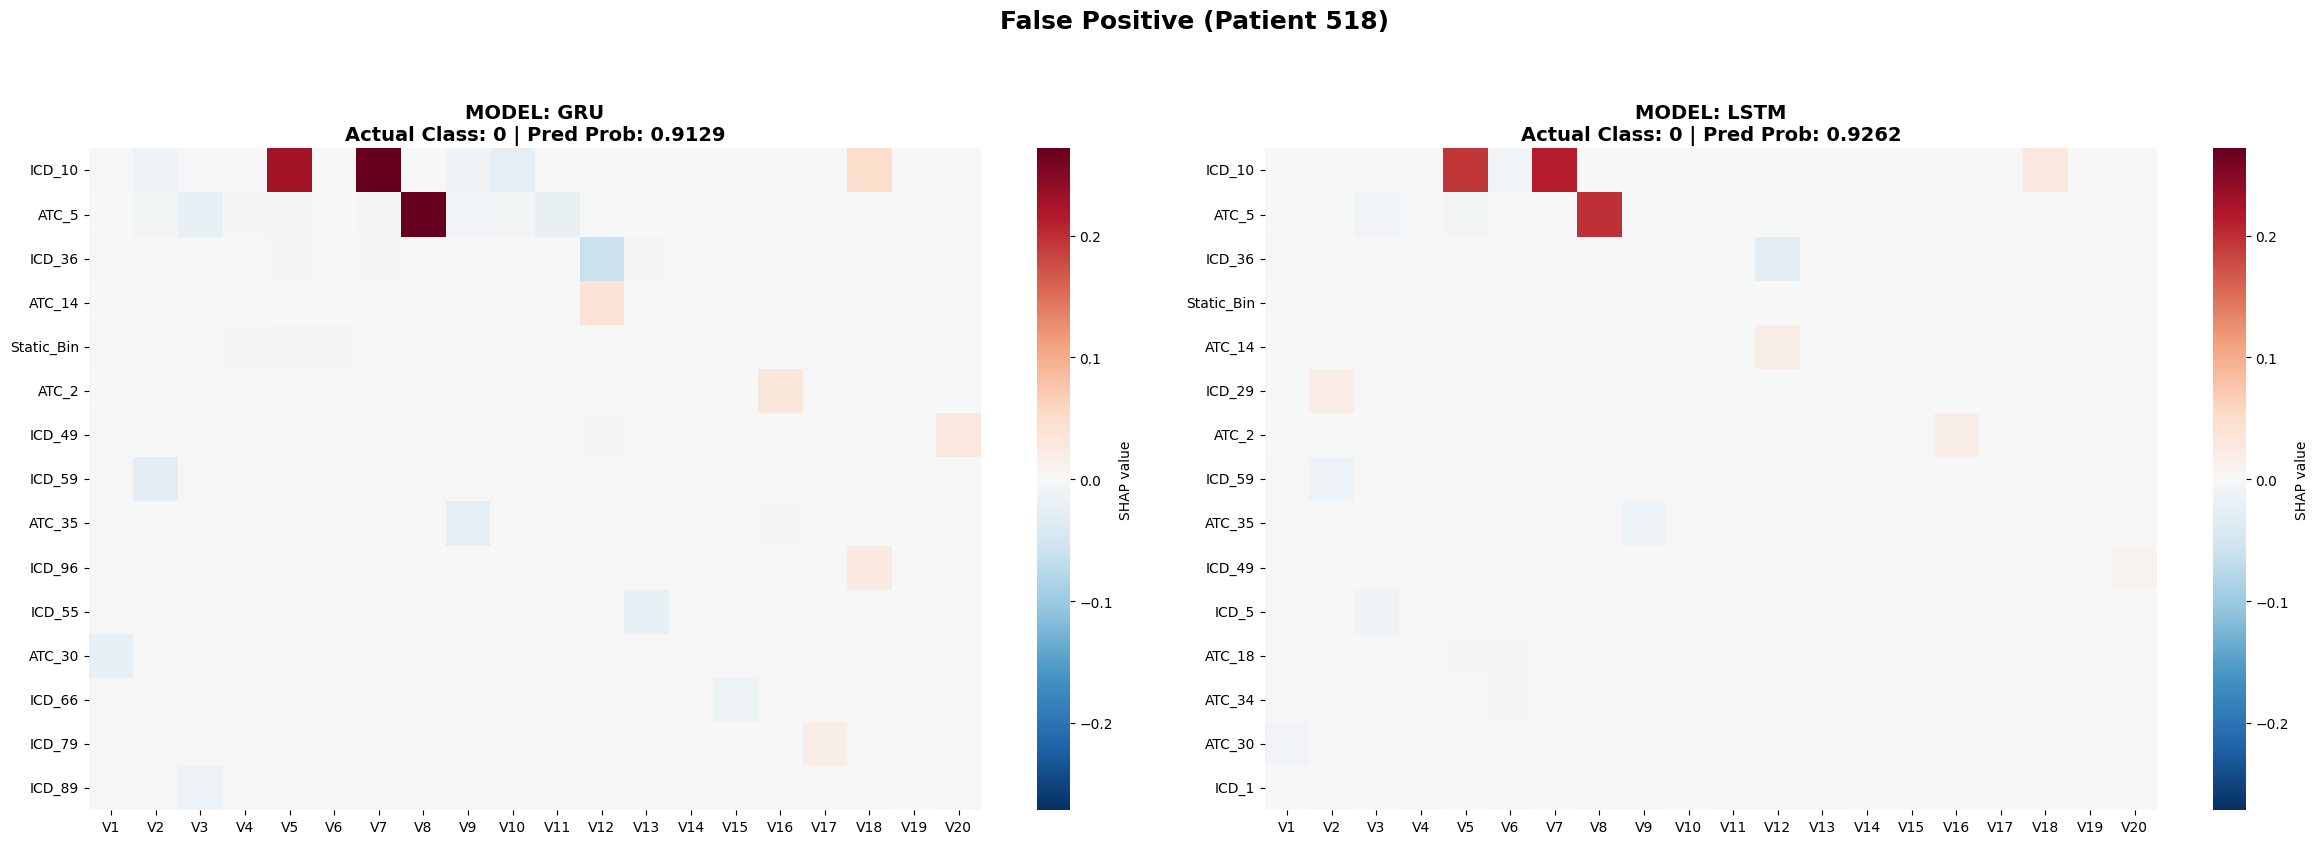

In [22]:
shap_by_model = {"GRU": shap_gru_ntf, "LSTM": shap_lstm_ntf}
utils.shap_patient_heatmap_side_by_side(
    shap_by_model, feature_names, case_studies, model_dict, X_test_tensor, y_test,
    top_k=15, normalize=False   # set normalize=True if you want same “pattern emphasis” as IG
)

In [23]:
# Correlation between EG and IG:
ig = IntegratedGradients(model_gru)

X_tensor = torch.tensor(X_explain, dtype=torch.float32).to(device)

baseline = torch.zeros_like(X_tensor)


attributions, delta = ig.attribute(
    X_tensor,
    baselines=baseline,
    return_convergence_delta=True
)

ig_gru_ntf = attributions.detach().cpu().numpy()

np.corrcoef(
    shap_gru_ntf[p].flatten(),
    ig_gru_ntf[p].flatten()
)[0,1]


0.9664633961068839

## Counterfactual Explanations

*In IML, counterfactual explanations can be used to explain predictions of individual instances. Displayed as a graph below, the relationship between the inputs and the prediction is very simple: The feature values cause the prediction. Even if in reality the relationship between the inputs and the outcome to be predicted might not be causal, we can see the inputs of a model as the cause of the prediction.* (see https://christophm.github.io/interpretable-ml-book/counterfactual.html)

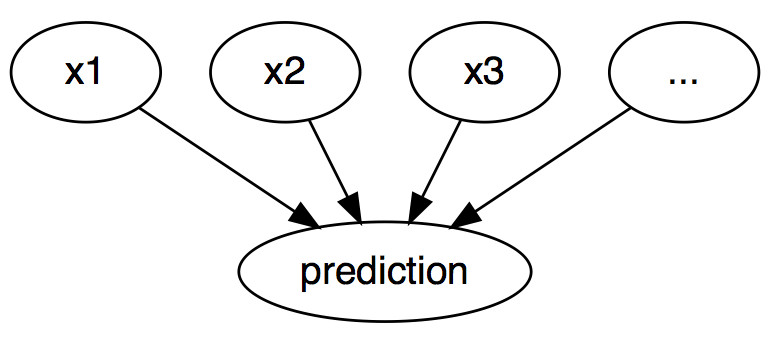

**$\rightarrow$ "What is the smallest, plausible change to this patient's sequence that flips the prediction (or moves it below/above a threshold)?"**

**This section provides:**
1) A prediction wrapper that returns a scalar probability for a single sequence
2) A greedy counterfactual search that removes evidence (tokens or full timesteps) until the predicted probability drops below a chosen threshold
3) A small pretty-printer for human-readable output
4) Convenience code to run the method for one test patient or multiple case studies

**Data shape conventions: Each patient sequence is a 3D tensor: (N, T, F)**
* N: number of sequences (patients) in a batch
* T: number of timesteps/visits (here 20)
* F: number of features per timestep (n_tokens + 2 static)

**Important note on static features:**
You broadcast static features across time, so the same static value appears at each timestep. When doing counterfactuals, we typically do NOT allow edits to those static features (or treat them separately), otherwise the algorithm may propose unrealistic changes.

**General notes:**
* For classification tasks, it is better to define the counterfactual in terms of predicted probabilities than class outcomes
* Because the event features are discrete one-hot codes, the most practical counterfactual methods are search/perturbation-based

### Greedy "remove codes/visits"

In [24]:
# ------------------------------------------------------------
# 1) Define a prediction function for the trained PyTorch GRU
# ------------------------------------------------------------

# Determine which device (CPU/GPU) the model currently lives on.
# This avoids device mismatch errors when creating input tensors.
device = next(model_gru.parameters()).device

# Put model in evaluation mode:
# - disables dropout
# - uses running stats for batch norm (if present)
# - ensures deterministic inference (as much as possible)
model_gru.eval()

def predict_proba(x_np: np.ndarray) -> float:
    """
    Predict the probability for a single sequence using the GRU model.

    Parameters
    ----------
    x_np : np.ndarray
        Input sequence as a numpy array with shape (1, T, F).
        We assume batch size = 1.

    Returns
    -------
    float
        Predicted probability for the positive class (scalar).
    """
    # Convert numpy -> torch tensor and move to the same device as the model.
    x_t = torch.tensor(x_np, dtype=torch.float32, device=device)

    # Disable autograd to speed up inference and reduce memory use.
    with torch.no_grad():
        # Forward pass.
        # Depending on your model implementation, output might be shape (1,) or (1,1).
        p = model_gru(x_t)

        # Flatten to 1D (length N) so we can safely extract the first element.
        p = p.reshape(-1)

        # Move to CPU and convert to numpy for easy handling.
        p = p.detach().cpu().numpy()

    # We assume batch size 1, so return the first element as a Python float.
    return float(p[0])


In [25]:
# ============================================================
# 2) Cost function: how "big" is an edit?
# ============================================================
# In Molnar-style counterfactuals, you want x' to be "close" to x.
# Here, "close" is defined by a COST / DISTANCE over allowed edits.

def edit_cost(edit_type: str, t: int, T: int,
              base_token_cost: float = 1.0,
              base_timestep_cost: float = 5.0,
              time_weight: float = 0.0) -> float:
    """
    Compute the cost (distance penalty) of an edit.

    Parameters
    ----------
    edit_type : str
        "token" or "timestep".
    t : int
        Timestep index being edited.
    T : int
        Number of timesteps in the sequence.
    base_token_cost : float
        Base cost of flipping/removing a single token.
    base_timestep_cost : float
        Base cost of wiping a whole timestep (bigger change than one token).
    time_weight : float
        Optional extra penalty for editing earlier timesteps.
        - time_weight = 0.0  => all timesteps equally costly
        - time_weight > 0.0  => earlier timesteps cost more (discourages messing with the far past)

    Returns
    -------
    float
        Positive scalar cost. Higher means "bigger change".
    """
    # Base edit size:
    # - one token edit is "small" (cost ~ 1)
    # - removing an entire timestep is "large" (cost ~ 5)
    if edit_type == "token":
        c = base_token_cost
    elif edit_type == "timestep":
        c = base_timestep_cost
    else:
        raise ValueError("edit_type must be 'token' or 'timestep'")

    # Optional time-based penalty:
    # If you set time_weight>0, edits earlier in the timeline get a multiplier > 1.
    # This is useful if you conceptually care more about recent evidence (e.g., escalation window).
    if time_weight > 0 and T > 1:
        # earlier timesteps => larger (T-1-t) => larger multiplier
        multiplier = 1.0 + time_weight * (T - 1 - t) / (T - 1)
        c *= multiplier

    return float(c)

In [26]:
# ============================================================
# 3) Cost-aware greedy counterfactual by removing evidence
# ============================================================
def greedy_counterfactual_remove_cost_aware(
    x: np.ndarray,
    token_names,
    threshold: float = 0.5,
    max_edits: int = 10,
    mode: str = "token",
    static_idx=None,
    # cost parameters
    base_token_cost: float = 1.0,
    base_timestep_cost: float = 5.0,
    time_weight: float = 0.0,
    # optionally restrict to certain timesteps (useful for testing escalation windows)
    allowed_timesteps=None
):
    """
    Greedy counterfactual that *removes evidence* until the prediction drops below a threshold.
    Unlike the earlier version, this chooses edits by "benefit per cost":

        score = (p_current - p_candidate) / cost(edit)

    This is closer to Molnar's idea: find a *small* change that achieves a target.

    Parameters
    ----------
    x : np.ndarray
        Input sequence, shape (1, T, F).
    token_names : list[str]
        Feature names for reporting. Must be length F.
    threshold : float
        Target to reach (e.g., drop below 0.5).
    max_edits : int
        Maximum greedy steps.
    mode : str
        "token" or "timestep"
    static_idx : list[int] or None
        Feature indices that should not be edited (e.g., static features).
    base_token_cost, base_timestep_cost, time_weight : floats
        Define the edit cost function (distance notion).
    allowed_timesteps : list[int] or None
        If provided, restrict edits to these timesteps only.

    Returns
    -------
    x_cf : np.ndarray
        Counterfactual sequence after edits, shape (1, T, F).
    edits : list[dict]
        Edit log with cost and scores.
    p_before : float
        Probability on original x.
    p_after : float
        Probability on final x_cf.
    """
    x_cf = x.copy()
    T, F = x_cf.shape[1], x_cf.shape[2]

    static_idx = set(static_idx or [])
    allowed_ts = list(allowed_timesteps) if allowed_timesteps is not None else list(range(T))

    # Current probability
    p_cur = predict_proba(x_cf)
    p_before = p_cur

    edits = []
    if p_cur < threshold:
        return x_cf, edits, p_before, p_cur

    # Greedy loop
    for step in range(1, max_edits + 1):

        best = None
        best_score = 0.0  # score must be positive (we want probability to go down)
        best_p = p_cur

        # --------------------------------------------------------
        # Mode: remove entire timestep
        # --------------------------------------------------------
        if mode == "timestep":
            for t in allowed_ts:
                x_try = x_cf.copy()
                x_try[0, t, :] = 0.0

                # Restore static features if they are broadcast across time
                for j in static_idx:
                    x_try[0, t, j] = x_cf[0, t, j]

                p_new = predict_proba(x_try)

                # Benefit = how much we lowered the probability
                gain = p_cur - p_new
                if gain <= 0:
                    continue

                # Distance penalty / cost of this edit
                c = edit_cost(
                    edit_type="timestep",
                    t=t,
                    T=T,
                    base_token_cost=base_token_cost,
                    base_timestep_cost=base_timestep_cost,
                    time_weight=time_weight
                )

                # "Benefit per cost" (a small-cost edit with decent gain is preferred)
                score = gain / c

                if score > best_score:
                    best_score = score
                    best_p = p_new
                    best = ("timestep", t, None, c, gain, score)

        # --------------------------------------------------------
        # Mode: remove individual active tokens
        # --------------------------------------------------------
        elif mode == "token":
            for t in allowed_ts:
                # Candidate removable tokens = ones currently "on" at that timestep
                present = np.where(x_cf[0, t, :] > 0.5)[0]
                present = [j for j in present if j not in static_idx]

                for j in present:
                    x_try = x_cf.copy()
                    x_try[0, t, j] = 0.0
                    p_new = predict_proba(x_try)

                    gain = p_cur - p_new
                    if gain <= 0:
                        continue

                    c = edit_cost(
                        edit_type="token",
                        t=t,
                        T=T,
                        base_token_cost=base_token_cost,
                        base_timestep_cost=base_timestep_cost,
                        time_weight=time_weight
                    )
                    score = gain / c

                    if score > best_score:
                        best_score = score
                        best_p = p_new
                        best = ("token", t, j, c, gain, score)

        else:
            raise ValueError("mode must be either 'token' or 'timestep'")

        # If no positive-gain edit exists, stop
        if best is None:
            break

        # Apply the best edit found
        edit_type, t, j, c, gain, score = best

        if edit_type == "timestep":
            x_cf[0, t, :] = 0.0
            for jj in static_idx:
                x_cf[0, t, jj] = x[0, t, jj]  # restore static from original
            edits.append({
                "step": step,
                "type": "timestep_zero",
                "t": int(t),
                "feature": None,
                "cost": float(c),
                "gain": float(gain),
                "score": float(score),
                "new_p": float(best_p),
            })

        else:
            x_cf[0, t, j] = 0.0
            edits.append({
                "step": step,
                "type": "token_remove",
                "t": int(t),
                "feature": token_names[j],
                "j": int(j),
                "cost": float(c),
                "gain": float(gain),
                "score": float(score),
                "new_p": float(best_p),
            })

        # Update current probability
        p_cur = best_p

        # Stop if target achieved
        if p_cur < threshold:
            break

    return x_cf, edits, p_before, p_cur

In [27]:
# ============================================================
# 4) Pretty summary
# ============================================================

def summarize_counterfactual(p_before, p_after, edits, threshold=0.5):
    """
    Print a human-readable summary.
    Now includes edit costs and benefit-per-cost score.
    """
    print("Counterfactual Explanation (cost-aware)")
    print("=" * 55)
    print(f"Original probability : {p_before:.4f}")
    print(f"New probability      : {p_after:.4f}")
    print(f"Δ probability        : {p_before - p_after:.4f}")
    print(f"Threshold crossed?   : {p_after < threshold}")
    print()

    if len(edits) == 0:
        print("No edits were found.")
        return

    print("Edits applied:")
    for e in edits:
        if e["type"] == "token_remove":
            print(f"  Step {e['step']}: remove '{e['feature']}' at t={e['t']}"
                  f" | cost={e['cost']:.2f} | gain={e['gain']:.4f} | score={e['score']:.4f}"
                  f" | p={e['new_p']:.4f}")
        elif e["type"] == "timestep_zero":
            print(f"  Step {e['step']}: zero timestep t={e['t']}"
                  f" | cost={e['cost']:.2f} | gain={e['gain']:.4f} | score={e['score']:.4f}"
                  f" | p={e['new_p']:.4f}")



In [28]:
# ============================================================
# 5) Example usage on one patient
# ============================================================

idx = 1

# pid_test was produced by train_test_split(...) along with X_test/y_test,
# so pid_test[idx] is the *true patient_id* corresponding to X_test[idx].
pid = pid_test[idx]

# Extract patient sequence as (1, T, F)
x = np.asarray(X_test[idx:idx+1], dtype=float)

# If a specific patient_id is wanted, use the pid_to_test_index mapping:
# pid = 1194
# idx = pid_to_test_index[pid]
# x = np.asarray(X_test[idx:idx+1], dtype=float)

print(f"Explaining test_idx={idx} (patient_id={pid}, y={y_test[idx]})")
print(f"Original pred: {predict_proba(x):.4f}")

static_idx = [len(tokens), len(tokens) + 1]  # static_bin, static_cont

# Example A: token removal, all timesteps allowed, no time penalty
x_cf, edits, p_before, p_after = greedy_counterfactual_remove_cost_aware(
    x,
    token_names=feature_names,
    threshold=0.5,
    max_edits=8,
    mode="token",
    static_idx=static_idx,
    time_weight=0.0
)

summarize_counterfactual(p_before, p_after, edits, threshold=0.5)

# Example B (optional): focus only on escalation window (last 3 visits)
T = x.shape[1]
allowed_ts = list(range(T - 3, T))

x_cf2, edits2, p_before2, p_after2 = greedy_counterfactual_remove_cost_aware(
    x,
    token_names=feature_names,
    threshold=0.5,
    max_edits=8,
    mode="token",
    static_idx=static_idx,
    allowed_timesteps=allowed_ts,
    time_weight=0.0
)

Explaining test_idx=1 (patient_id=1194, y=1)
Original pred: 0.8996
Counterfactual Explanation (cost-aware)
Original probability : 0.8996
New probability      : 0.3640
Δ probability        : 0.5356
Threshold crossed?   : True

Edits applied:
  Step 1: remove 'ATC_5' at t=1 | cost=1.00 | gain=0.5356 | score=0.5356 | p=0.3640


In [29]:
# ------------------------------------------------------------
# 5) Quick sanity: show mapping between test index and patient ID
# ------------------------------------------------------------

idx = 1
print("This is test row idx =", idx)
print("Actual patient_id (1..3000) =", pid_test[idx])
print("Outcome label =", y_test[idx])

This is test row idx = 1
Actual patient_id (1..3000) = 1194
Outcome label = 1


In [30]:
def run_cf_on_case_studies_cost_aware(
    case_studies: dict,
    X_test,
    y_test,
    pid_test,
    token_names,
    tokens,
    threshold: float = 0.5,
    max_edits: int = 8,
    mode: str = "token",
    # cost settings
    base_token_cost: float = 1.0,
    base_timestep_cost: float = 5.0,
    time_weight: float = 0.0,
    # optional: restrict edits to a window (e.g., escalation last 3 visits)
    allowed_timesteps=None
):
    """
    Run cost-aware greedy counterfactual explanations for a set of named case studies.

    Parameters
    ----------
    case_studies : dict[str, int]
        Maps a human-readable case name to the corresponding row index in X_test.
        Example: {"Pure Trigger": 12, "Pure Chronic": 77, ...}
    X_test : np.ndarray
        Test tensor (N_test, T, F).
    y_test : np.ndarray
        Test labels (N_test,).
    pid_test : np.ndarray
        Patient IDs aligned with X_test (N_test,).
    token_names : list[str]
        Names of all features (length F). Should match your `feature_names`.
    tokens : list[str]
        Token list (length n_tokens). Used to infer static indices.
    threshold : float
        Target threshold to cross below.
    max_edits : int
        Maximum number of greedy edits per patient.
    mode : str
        "token" or "timestep"
    base_token_cost, base_timestep_cost, time_weight : float
        Cost settings controlling the distance notion.
    allowed_timesteps : list[int] or None
        If not None, restrict edits to only these timesteps for every case.

    Returns
    -------
    summary_df : pd.DataFrame
        One row per case with probabilities and number of edits.
    details : dict[str, pd.DataFrame]
        Per-case edits table.
    """
    static_idx = [len(tokens), len(tokens) + 1]  # static_bin and static_cont at the end

    rows = []
    details = {}

    for title, test_idx in case_studies.items():
        test_idx = int(test_idx)
        pid = int(pid_test[test_idx])
        y_true = int(y_test[test_idx])

        x = np.asarray(X_test[test_idx:test_idx+1], dtype=float)

        x_cf, edits, p_before, p_after = greedy_counterfactual_remove_cost_aware(
            x=x,
            token_names=token_names,
            threshold=threshold,
            max_edits=max_edits,
            mode=mode,
            static_idx=static_idx,
            base_token_cost=base_token_cost,
            base_timestep_cost=base_timestep_cost,
            time_weight=time_weight,
            allowed_timesteps=allowed_timesteps
        )

        # Store detailed edits as a DataFrame for easy viewing
        edits_df = pd.DataFrame(edits)
        details[title] = edits_df

        # Helpful single-line descriptor of the first edit
        if len(edits) > 0 and edits[0].get("type") == "token_remove":
            first_edit = f"{edits[0]['feature']} @ t={edits[0]['t']}"
        elif len(edits) > 0 and edits[0].get("type") == "timestep_zero":
            first_edit = f"timestep t={edits[0]['t']}"
        else:
            first_edit = None

        rows.append({
            "Case": title,
            "test_idx": test_idx,
            "patient_id": pid,
            "y_true": y_true,
            "p_before": float(p_before),
            "p_after": float(p_after),
            "delta": float(p_before - p_after),
            "crossed_below_threshold": bool(p_after < threshold),
            "n_edits": int(len(edits)),
            "first_edit": first_edit,
        })

    summary_df = pd.DataFrame(rows).sort_values(["Case"])
    return summary_df, details

In [31]:
# Run across all cases normally (all timesteps allowed)
cf_summary, cf_details = run_cf_on_case_studies_cost_aware(
    case_studies=case_studies,
    X_test=X_test,
    y_test=y_test,
    pid_test=pid_test,
    token_names=feature_names,
    tokens=tokens,
    threshold=0.5,
    max_edits=8,
    mode="token",
    time_weight=0.0
)
cf_summary

Case  test_idx  patient_id  y_true  p_before  \
7               False Positive       518         277       0  0.912942   
6             Mixed: All Three        17         113       1  0.938642   
5  Mixed: Chronic + Escalation       586        1019       1  0.906163   
3     Mixed: Trigger + Chronic       445         773       1  0.934472   
4  Mixed: Trigger + Escalation       280        2148       1  0.906530   
1                 Pure Chronic       105        1972       1  0.185590   
2         Pure Late Escalation        46        1975       1  0.533124   
0                 Pure Trigger       480         374       1  0.931826   

    p_after     delta  crossed_below_threshold  n_edits     first_edit  
7  0.231531  0.681410                     True        2   ICD_10 @ t=6  
6  0.343060  0.595582                     True        3    ATC_5 @ t=3  
5  0.377958  0.528205                     True        2    ATC_5 @ t=4  
3  0.305785  0.628687                     True        2    ATC_5 @ t=3  
4  0.335626  0.570904                     True        1    ATC_5 @ t=4  
1  0.185590  0.000000                     True        0           None  
2  0.345803  0.187321                     True        1  ICD_10 @ t=11  
0  0.491234  0.440592                     True        2    ATC_5 @ t=3

In [32]:
# Run a scond time focusing only on the escalation window (last 3 visits)
# -> gives test whether the model really depends on the last 3 visits for escalation-only cases
# -> if escalation is real, the escalation-only case should flip with edits inside that window, while other cases might not
T = X_test.shape[1]
allowed_ts_escalation = list(range(T - 3, T))

cf_summary_last3, cf_details_last3 = run_cf_on_case_studies_cost_aware(
    case_studies=case_studies,
    X_test=X_test,
    y_test=y_test,
    pid_test=pid_test,
    token_names=feature_names,
    tokens=tokens,
    threshold=0.5,
    max_edits=8,
    mode="token",
    allowed_timesteps=allowed_ts_escalation
)
cf_summary_last3


Case  test_idx  patient_id  y_true  p_before  \
7               False Positive       518         277       0  0.912942   
6             Mixed: All Three        17         113       1  0.938642   
5  Mixed: Chronic + Escalation       586        1019       1  0.906163   
3     Mixed: Trigger + Chronic       445         773       1  0.934472   
4  Mixed: Trigger + Escalation       280        2148       1  0.906530   
1                 Pure Chronic       105        1972       1  0.185590   
2         Pure Late Escalation        46        1975       1  0.533124   
0                 Pure Trigger       480         374       1  0.931826   

    p_after     delta  crossed_below_threshold  n_edits     first_edit  
7  0.894251  0.018691                    False        4  ICD_49 @ t=19  
6  0.906059  0.032582                    False        8  ICD_39 @ t=19  
5  0.899794  0.006370                    False        3  ICD_58 @ t=19  
3  0.924140  0.010332                    False        2   ICD_1 @ t=19  
4  0.838465  0.068065                    False        8  ICD_95 @ t=19  
1  0.185590  0.000000                     True        0           None  
2  0.471349  0.061775                     True        1  ICD_48 @ t=17  
0  0.924337  0.007489                    False        4  ATC_19 @ t=18

In [33]:
def print_all_edits(case_name, summary_df, details_dict):
    row = summary_df[summary_df["Case"] == case_name].iloc[0]

    print(f"Case: {case_name}")
    print("-" * 50)
    print(f"Patient ID: {int(row['patient_id'])}")
    print(f"y_true: {int(row['y_true'])}")
    print(f"p_before: {row['p_before']:.4f}")
    print(f"p_after : {row['p_after']:.4f}")
    print(f"Δp      : {row['delta']:.4f}")
    print(f"n_edits : {int(row['n_edits'])}")
    print()

    edits_df = details_dict[case_name]

    if edits_df.empty:
        print("No edits were applied.")
    else:
        print("All edits:")
        display(edits_df)

In [34]:
# Print all edits for all cases
for case in cf_summary["Case"]:
    print_all_edits(case, cf_summary, cf_details)
    print("\n" + "="*80 + "\n")

Case: False Positive
--------------------------------------------------
Patient ID: 277
y_true: 0
p_before: 0.9129
p_after : 0.2315
Δp      : 0.6814
n_edits : 2

All edits:


step          type  t feature   j  cost      gain     score     new_p
0     1  token_remove  6  ICD_10  41   1.0  0.209480  0.209480  0.703462
1     2  token_remove  7   ATC_5  35   1.0  0.471931  0.471931  0.231531



Case: Mixed: All Three
--------------------------------------------------
Patient ID: 113
y_true: 1
p_before: 0.9386
p_after : 0.3431
Δp      : 0.5956
n_edits : 3

All edits:


step          type  t feature   j  cost      gain     score     new_p
0     1  token_remove  3   ATC_5  35   1.0  0.030397  0.030397  0.908245
1     2  token_remove  3  ICD_10  41   1.0  0.389736  0.389736  0.518509
2     3  token_remove  2  ICD_10  41   1.0  0.175449  0.175449  0.343060



Case: Mixed: Chronic + Escalation
--------------------------------------------------
Patient ID: 1019
y_true: 1
p_before: 0.9062
p_after : 0.3780
Δp      : 0.5282
n_edits : 2

All edits:


step          type  t feature   j  cost      gain     score     new_p
0     1  token_remove  4   ATC_5  35   1.0  0.045243  0.045243  0.860920
1     2  token_remove  0  ICD_10  41   1.0  0.482962  0.482962  0.377958



Case: Mixed: Trigger + Chronic
--------------------------------------------------
Patient ID: 773
y_true: 1
p_before: 0.9345
p_after : 0.3058
Δp      : 0.6287
n_edits : 2

All edits:


step          type  t feature   j  cost      gain     score     new_p
0     1  token_remove  3   ATC_5  35   1.0  0.054545  0.054545  0.879927
1     2  token_remove  2  ICD_10  41   1.0  0.574142  0.574142  0.305785



Case: Mixed: Trigger + Escalation
--------------------------------------------------
Patient ID: 2148
y_true: 1
p_before: 0.9065
p_after : 0.3356
Δp      : 0.5709
n_edits : 1

All edits:


step          type  t feature   j  cost      gain     score     new_p
0     1  token_remove  4   ATC_5  35   1.0  0.570904  0.570904  0.335626



Case: Pure Chronic
--------------------------------------------------
Patient ID: 1972
y_true: 1
p_before: 0.1856
p_after : 0.1856
Δp      : 0.0000
n_edits : 0

No edits were applied.


Case: Pure Late Escalation
--------------------------------------------------
Patient ID: 1975
y_true: 1
p_before: 0.5331
p_after : 0.3458
Δp      : 0.1873
n_edits : 1

All edits:


step          type   t feature   j  cost      gain     score     new_p
0     1  token_remove  11  ICD_10  41   1.0  0.187321  0.187321  0.345803



Case: Pure Trigger
--------------------------------------------------
Patient ID: 374
y_true: 1
p_before: 0.9318
p_after : 0.4912
Δp      : 0.4406
n_edits : 2

All edits:


step          type  t feature   j  cost      gain     score     new_p
0     1  token_remove  3   ATC_5  35   1.0  0.063970  0.063970  0.867856
1     2  token_remove  2  ICD_10  41   1.0  0.376622  0.376622  0.491234

In [35]:
def cf_case_metrics_from_details(
    edits_df: pd.DataFrame,
    p_before: float,
    T: int,
    window_last_k: int = 3,
    threshold: float = 0.5
):
    """
    Compute per-case metrics including:
      - all edit probabilities (probability path)
      - per-step probability drops
      - crossing info
    """

    if edits_df is None or edits_df.empty:
        return {
            "n_edits": 0,
            "prob_path": [],
            "delta_path": [],
            "cumulative_delta": 0.0,
            "crossing_step": None,
            "crossing_timestep": None,
            "crossing_feature": None,
            "p_at_crossing": np.nan,
            "frac_edits_in_last_k": np.nan,
        }

    # ----- Probability trajectory -----
    prob_path = edits_df["new_p"].tolist() if "new_p" in edits_df.columns else []

    # delta per step: how much probability dropped at each edit
    delta_path = []
    prev_p = p_before
    for p in prob_path:
        delta_path.append(prev_p - p)
        prev_p = p

    cumulative_delta = p_before - prob_path[-1]

    # ----- Window concentration (last k visits) -----
    t_list = edits_df["t"].dropna().astype(int).tolist() if "t" in edits_df.columns else []
    last_k_set = set(range(T - window_last_k, T))
    n_in_last_k = sum(t in last_k_set for t in t_list)
    frac_in_last_k = n_in_last_k / len(edits_df) if len(edits_df) > 0 else np.nan

    # ----- Crossing information -----
    crossing_step = None
    crossing_timestep = None
    crossing_feature = None
    p_at_crossing = np.nan

    crossed_mask = edits_df["new_p"] < threshold if "new_p" in edits_df.columns else []
    if isinstance(crossed_mask, pd.Series) and crossed_mask.any():
        cross_row = edits_df.loc[crossed_mask].iloc[0]
        crossing_step = int(cross_row.get("step", edits_df.index.get_loc(cross_row.name) + 1))
        crossing_timestep = int(cross_row["t"]) if "t" in cross_row else None
        crossing_feature = cross_row.get("feature", None)
        p_at_crossing = float(cross_row["new_p"])

    return {
        "n_edits": len(edits_df),
        "prob_path": prob_path,
        "delta_path": delta_path,
        "cumulative_delta": cumulative_delta,
        "crossing_step": crossing_step,
        "crossing_timestep": crossing_timestep,
        "crossing_feature": crossing_feature,
        "p_at_crossing": p_at_crossing,
        "frac_edits_in_last_k": frac_in_last_k
    }


def build_cf_metrics_table(
    cf_summary: pd.DataFrame,
    cf_details: dict,
    T: int,
    window_last_k: int = 3,
    threshold: float = 0.5
):
    """
    Enrich cf_summary with:
      - full probability trajectory per case
      - per-step probability drops
      - crossing information
      - window concentration metrics
    """

    rows = []
    for _, r in cf_summary.iterrows():
        case = r["Case"]
        edits_df = cf_details.get(case, pd.DataFrame())

        m = cf_case_metrics_from_details(
            edits_df=edits_df,
            p_before=r["p_before"],
            T=T,
            window_last_k=window_last_k,
            threshold=threshold
        )

        rows.append({
            "Case": case,
            "test_idx": int(r["test_idx"]),
            "patient_id": int(r["patient_id"]),
            "y_true": int(r["y_true"]),
            "p_before": float(r["p_before"]),
            "p_after": float(r["p_after"]),
            "delta_total": float(r["delta"]),
            "crossed_below_threshold": bool(r["crossed_below_threshold"]),
            **m
        })

    return pd.DataFrame(rows)

In [36]:
def build_cf_edits_table(cf_summary: pd.DataFrame, cf_details: dict, threshold: float = 0.5):
    """
    Returns a long DataFrame with one row per edit.
    Includes:
      - case-level columns (Case, patient_id, y_true, p_before, etc.)
      - edit-level columns (step, feature edited, timestep, p_before_step, p_after_step, delta_step)
    """
    rows = []

    for _, r in cf_summary.iterrows():
        case = r["Case"]
        pid = int(r["patient_id"])
        test_idx = int(r["test_idx"])
        y_true = int(r["y_true"])
        p_case_before = float(r["p_before"])
        p_case_after = float(r["p_after"])
        crossed = bool(r["crossed_below_threshold"])

        edits_df = cf_details.get(case, pd.DataFrame()).copy()

        # If no edits, still create one row so the case shows up
        if edits_df is None or edits_df.empty:
            rows.append({
                "Case": case,
                "patient_id": pid,

                # case-level info (you said: keep these in front / before the edit info)
                "test_idx": test_idx,
                "y_true": y_true,
                "p_before_case": p_case_before,
                "p_after_case": p_case_after,
                "crossed_below_threshold": crossed,

                # edit-level fields (blank)
                "edit_step": None,
                "edit_type": None,
                "timestep": None,
                "feature": None,
                "p_before_step": p_case_before,
                "p_after_step": p_case_before,
                "delta_step": 0.0,
                "crossed_this_step": False,
            })
            continue

        # Ensure we have a step column; if missing, create it
        if "step" not in edits_df.columns:
            edits_df["step"] = np.arange(1, len(edits_df) + 1)

        # Compute p_before_step and delta_step from the sequential new_p
        prev_p = p_case_before
        for _, e in edits_df.iterrows():
            p_after_step = float(e["new_p"]) if "new_p" in edits_df.columns else np.nan
            p_before_step = float(prev_p)
            delta_step = p_before_step - p_after_step
            crossed_this_step = (p_before_step >= threshold) and (p_after_step < threshold)

            rows.append({
                "Case": case,
                "patient_id": pid,

                # case-level info (kept in front)
                "test_idx": test_idx,
                "y_true": y_true,
                #"p_before_case": p_case_before,
                #"p_after_case": p_case_after,
                #"crossed_below_threshold": crossed,

                # edit-level info
                "edit_step": int(e["step"]),
                #"edit_type": e.get("type", None),
                "timestep": int(e["t"]) if pd.notnull(e.get("t", None)) else None,
                "feature": e.get("feature", None),
                "p_before_step": p_before_step,
                "p_after_step": p_after_step,
                "delta_step": delta_step,
                "crossed_this_step": bool(crossed_this_step),
            })

            prev_p = p_after_step

    df_long = pd.DataFrame(rows)

    # Order columns as you requested: Case + patient_id, then the per-edit info, while keeping others in front
    col_order = [
        "Case", "patient_id",
        "test_idx", "y_true",
        #"p_before_case", "p_after_case", "crossed_below_threshold",
        "edit_step", 
        #"edit_type", 
        # "timestep", "feature",
        "p_before_step", "p_after_step", "delta_step", "crossed_this_step",
    ]
    df_long = df_long[col_order].sort_values(["Case", "patient_id", "edit_step"], na_position="last").reset_index(drop=True)
    return df_long

In [37]:
cf_edits_table = build_cf_edits_table(cf_summary, cf_details, threshold=0.5)
cf_edits_table

Case  patient_id  test_idx  y_true  edit_step  \
0                False Positive         277       518       0        1.0   
1                False Positive         277       518       0        2.0   
2              Mixed: All Three         113        17       1        1.0   
3              Mixed: All Three         113        17       1        2.0   
4              Mixed: All Three         113        17       1        3.0   
5   Mixed: Chronic + Escalation        1019       586       1        1.0   
6   Mixed: Chronic + Escalation        1019       586       1        2.0   
7      Mixed: Trigger + Chronic         773       445       1        1.0   
8      Mixed: Trigger + Chronic         773       445       1        2.0   
9   Mixed: Trigger + Escalation        2148       280       1        1.0   
10                 Pure Chronic        1972       105       1        NaN   
11         Pure Late Escalation        1975        46       1        1.0   
12                 Pure Trigger         374       480       1        1.0   
13                 Pure Trigger         374       480       1        2.0   

    p_before_step  p_after_step  delta_step  crossed_this_step  
0        0.912942      0.703462    0.209480              False  
1        0.703462      0.231531    0.471931               True  
2        0.938642      0.908245    0.030397              False  
3        0.908245      0.518509    0.389736              False  
4        0.518509      0.343060    0.175449               True  
5        0.906163      0.860920    0.045243              False  
6        0.860920      0.377958    0.482962               True  
7        0.934472      0.879927    0.054545              False  
8        0.879927      0.305785    0.574142               True  
9        0.906530      0.335626    0.570904               True  
10       0.185590      0.185590    0.000000              False  
11       0.533124      0.345803    0.187321               True  
12       0.931826      0.867856    0.063970              False  
13       0.867856      0.491234    0.376622               True

In [38]:
def style_cf_table(df):
    df_display = df.copy()

    # Remove index column visually
    styler = df_display.style.hide(axis="index")

    # Create case grouping codes for alternating colors
    case_codes = df_display["Case"].astype("category").cat.codes

    # Create group codes for alternating colors
    case_codes = df_display["Case"].astype("category").cat.codes

    def style_rows(row):
        # Alternating background per case
        bg = "#f5f5f5" if case_codes[row.name] % 2 == 0 else "#ffffff"

        # Bold the threshold-crossing row only
        if row["crossed_this_step"] == 1 or row["crossed_this_step"] is True:
            return [f"background-color: {bg}; font-weight: bold"] * len(row)
        else:
            return [f"background-color: {bg}"] * len(row)

    return styler.apply(style_rows, axis=1)

style_cf_table(cf_edits_table)

## SHapley Additive exPlanations (SHAP) values 

Existing model-agnostic local feature attribution methods (e.g., IME, LIME, KernelSHAP) work regardless of the specific model being explained. They can explain a series of models, but suffer from two distinct shortcomings: (1) their sampling-based estimates of feature importance are inherently variable, and (2) they have a high computational cost which may not be tractable for large pipelines. Alternatively, model-specific local feature attribution methods (i.e., attribution methods that work for specific types of models) are often much faster than model-agnostic approaches, but generally cannot be used to explain a series of models. Examples include those for (1) deep models (e.g., DeepLIFT, Integrated Gradients) and (2) tree models (e.g., Gain/Gini Importance, TreeSHAP). (see https://www.nature.com/articles/s41467-022-31384-3)

### TimeSHAP

* Model-agnostic, recurrent explainer
* Builds upon KernelSHAP and extends it to the sequential domain
* Computed local event/timestamp- feature-, and cell-level attributions
* Additionally computed global event- and feature-level explanations
* As sequences can be arbitrarily long, TimeSHAP also implements a pruning algorithm based on Shapley Values, that finds a subset of consecutive, recent events that contribute the most to the decision

In [39]:
# Install TimeSHAP (and pin "shap"); TimeSHAP has compatibility issues with newer shap versions (renamed explainers)
# Pinning avoids common breakage
%pip install -U "timeshap" "shap<0.43"

Note: you may need to restart the kernel to use updated packages.


In [40]:
#............................. Imports & model wrapper & baseline choice .....................

import numpy as np
import pandas as pd

from timeshap.wrappers import TorchModelWrapper
from timeshap.explainer import local_report, global_report
from timeshap.plot import plot_local_report  # (optional, local_report already plots)

# ---- 1) Feature names (for plots) ----
# You already have: tokens = sorted(df_events['token'].unique())
feature_names = tokens + ["static_bin", "static_cont"]

# ---- 2) Wrap your model (GRU example) ----
# model_gru should already be loaded with best weights and set to eval()
model_gru.eval()
wrapped_gru = TorchModelWrapper(model_gru)

# TimeSHAP entry point: receives np.ndarray (N,T,F) -> returns np.ndarray (N,1)
f_gru = lambda x, y=None: wrapped_gru.predict_last_hs(x, y)[0] if isinstance(wrapped_gru.predict_last_hs(x, y), tuple) else wrapped_gru.predict_last_hs(x, y)

# NOTE:
# - TorchModelWrapper.predict_last_hs can return (preds, hidden_state) if your model returns hs too.
# - Your GRU returns only preds, so f_gru resolves to preds.

# ---- 3) Baseline (mean negative sequence) ----
X_train_np = np.asarray(X_train, dtype=float)
y_train_np = np.asarray(y_train)

baseline_seq = X_train_np[y_train_np == 0].mean(axis=0)   # shape (T,F)
# baseline_seq = X_train_np.mean(axis=0)  # alternative if you don't want class-conditional baseline

In [41]:
#.................................. Local explanations ...............................

# Pick one test instance to explain
idx = 1  # change as needed
x_explain = np.asarray(X_test[idx:idx+1], dtype=float)  # shape (1,T,F)

# TimeSHAP dictionaries (tune nsamples up for stability, down for speed)
pruning_dict = {"tol": 0.025}          # common tolerance used in literature/tutorials
event_dict   = {"rs": 42, "nsamples": 2000}
feat_dict = {
    "rs": 42,
    "nsamples": 2000,
    "top_feats": 15,
    "plot_features": {f"Feature {i}": feature_names[i] for i in range(len(feature_names))}
}

cell_dict = {
    "rs": 42,
    "nsamples": 2000,
    "top_x_events": 8,
    "top_x_feats": 12,
    "plot_features": {f"Feature {i}": feature_names[i] for i in range(len(feature_names))}
}

# Run local report (returns an altair plot object)
local_plot = local_report(
    f_gru,
    x_explain,
    pruning_dict=pruning_dict,
    event_dict=event_dict,
    feature_dict=feat_dict,
    cell_dict=cell_dict,     # set to None to skip cell-level
    baseline=baseline_seq
)

local_plot

Assuming all features are model features


KeyError: 'Explanation'

In [ ]:
from timeshap.explainer import local_pruning, local_event, local_feat, local_cell_level
from timeshap.plot import plot_temp_coalition_pruning, plot_event_heatmap, plot_cell_level

coal_plot_data, coal_prun_idx = local_pruning(f_gru, x_explain, pruning_dict, baseline_seq)
plot_temp_coalition_pruning(coal_plot_data, coal_prun_idx, plot_limit=40)

event_data = local_event(f_gru, x_explain, event_dict, baseline_seq, coal_prun_idx)
plot_event_heatmap(event_data)

feat_data = local_feat(f_gru, x_explain, feat_dict, baseline_seq, coal_prun_idx)
plot_feat_barplot_fixed(feat_data, top_x_feats=15, plot_features=feat_dict["plot_features"])  # patched

cell_data = local_cell_level(f_gru, x_explain, cell_dict, event_data, feat_data, baseline_seq, coal_prun_idx)
plot_cell_level(cell_data)

In [ ]:
#................................ Global explanations .................................

# Choose a set of sequences to explain globally
# Common choice: explain only predicted positives (or true positives), but here's a simple subset:
X_global = np.asarray(X_test[:200], dtype=float)  # adjust

global_pruning_dict = {"tol": 0.025}
global_event_dict   = {"rs": 42, "nsamples": 1000}   # often smaller than local
global_feat_dict    = {
    "rs": 42,
    "nsamples": 1000,
    "top_feats": 20,
    "plot_features": {i: feature_names[i] for i in range(len(feature_names))}
}

pruning_stats, global_plot = global_report(
    f_gru,
    X_global,
    pruning_dict=global_pruning_dict,
    event_dict=global_event_dict,
    feature_dict=global_feat_dict,
    baseline=baseline_seq,
    max_instances=200
)

pruning_stats, global_plot